## Compares A* and D*-Lite path planning algorithms in both static and dynamic environments, across small (10×10) and large (50×50) 2D grids.


--- 10x10 Grid ---
Running A* (static)...


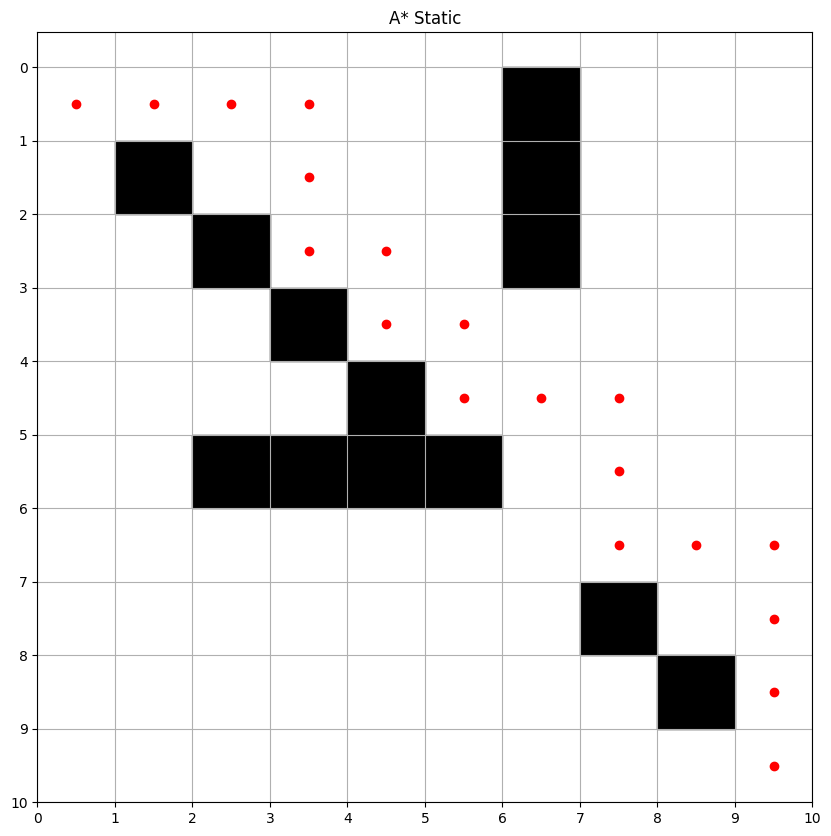

Running A* (dynamic)...


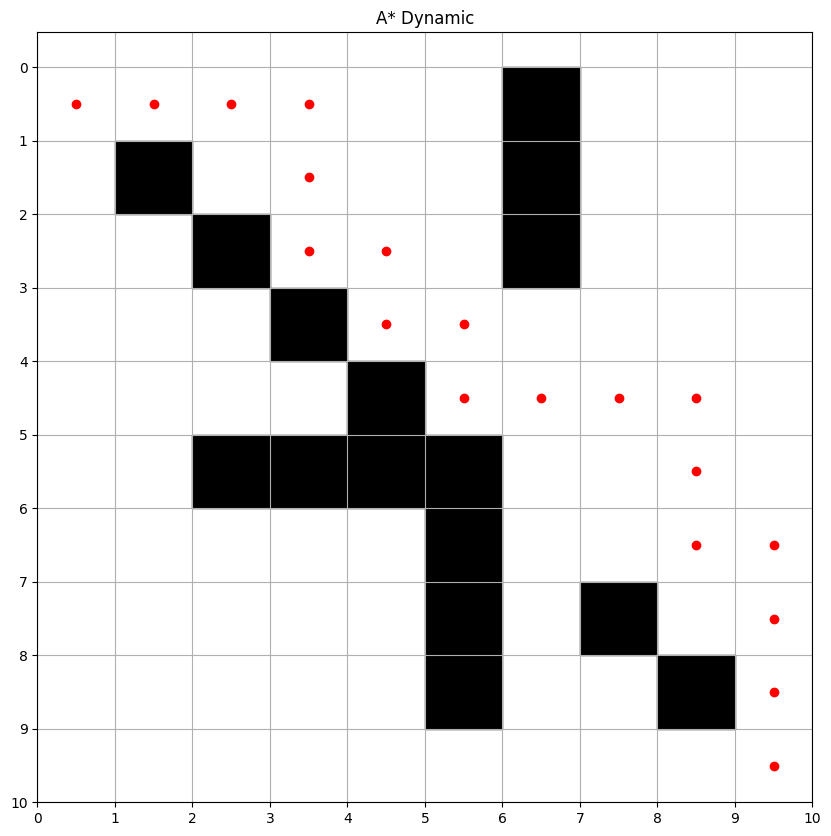

Running D*-Lite (static)...


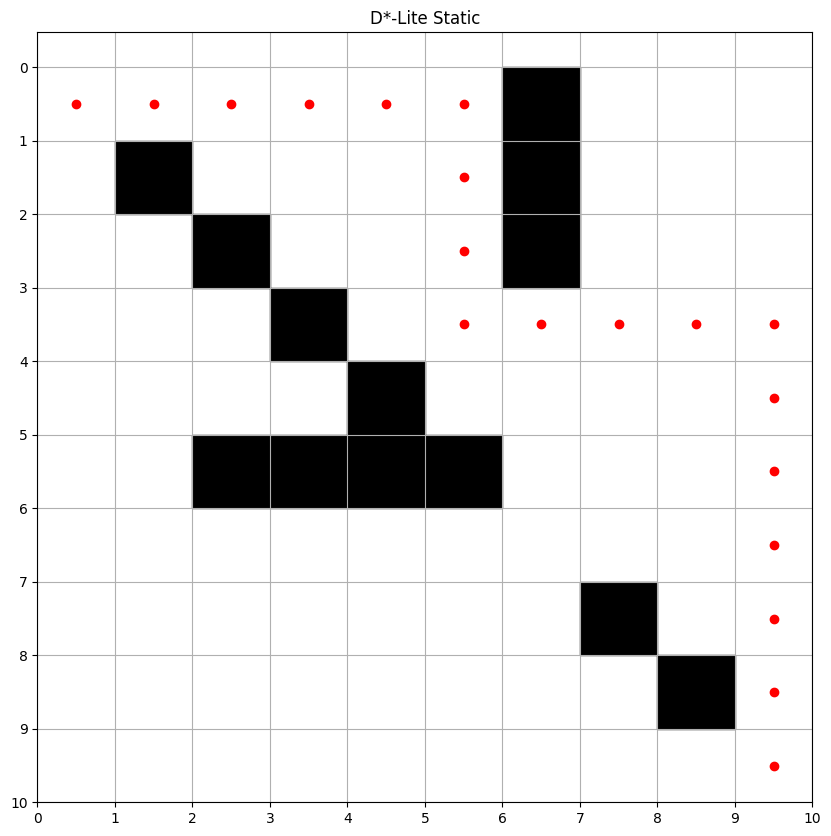

Running D*-Lite (dynamic)...


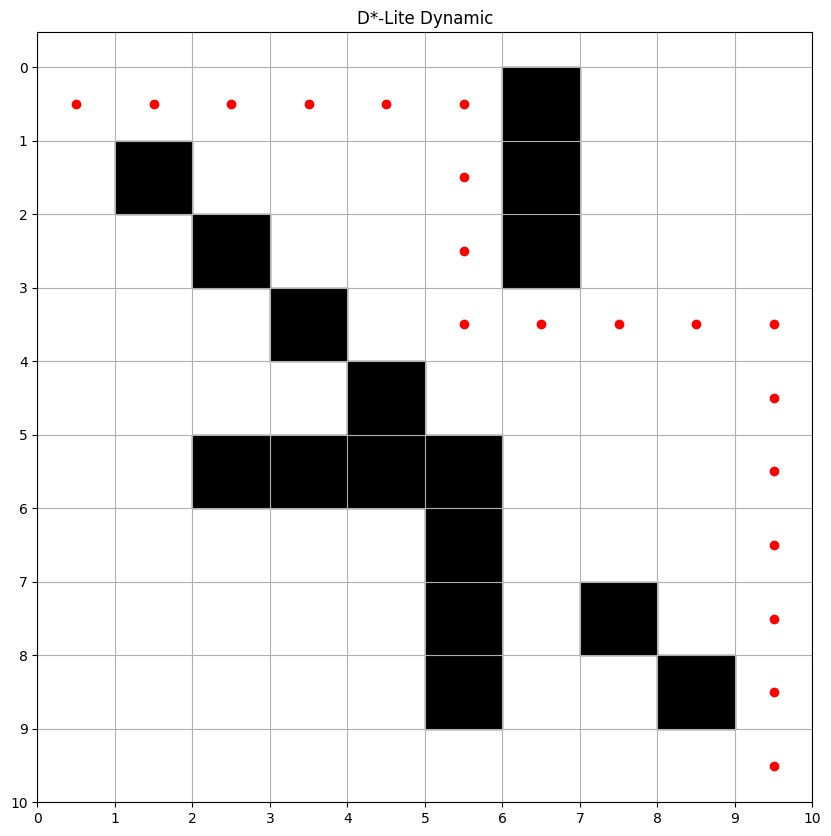


--- Summary Table ---
Algorithm                 Length     Time (s)  
A* (Static)               19         0.000698
A* (Dynamic)              19         0.000848
D*-Lite (Static)          19         0.005666
D*-Lite (Dynamic)         19         0.024622

--- 50x50 Grid ---
Running A* (static)...


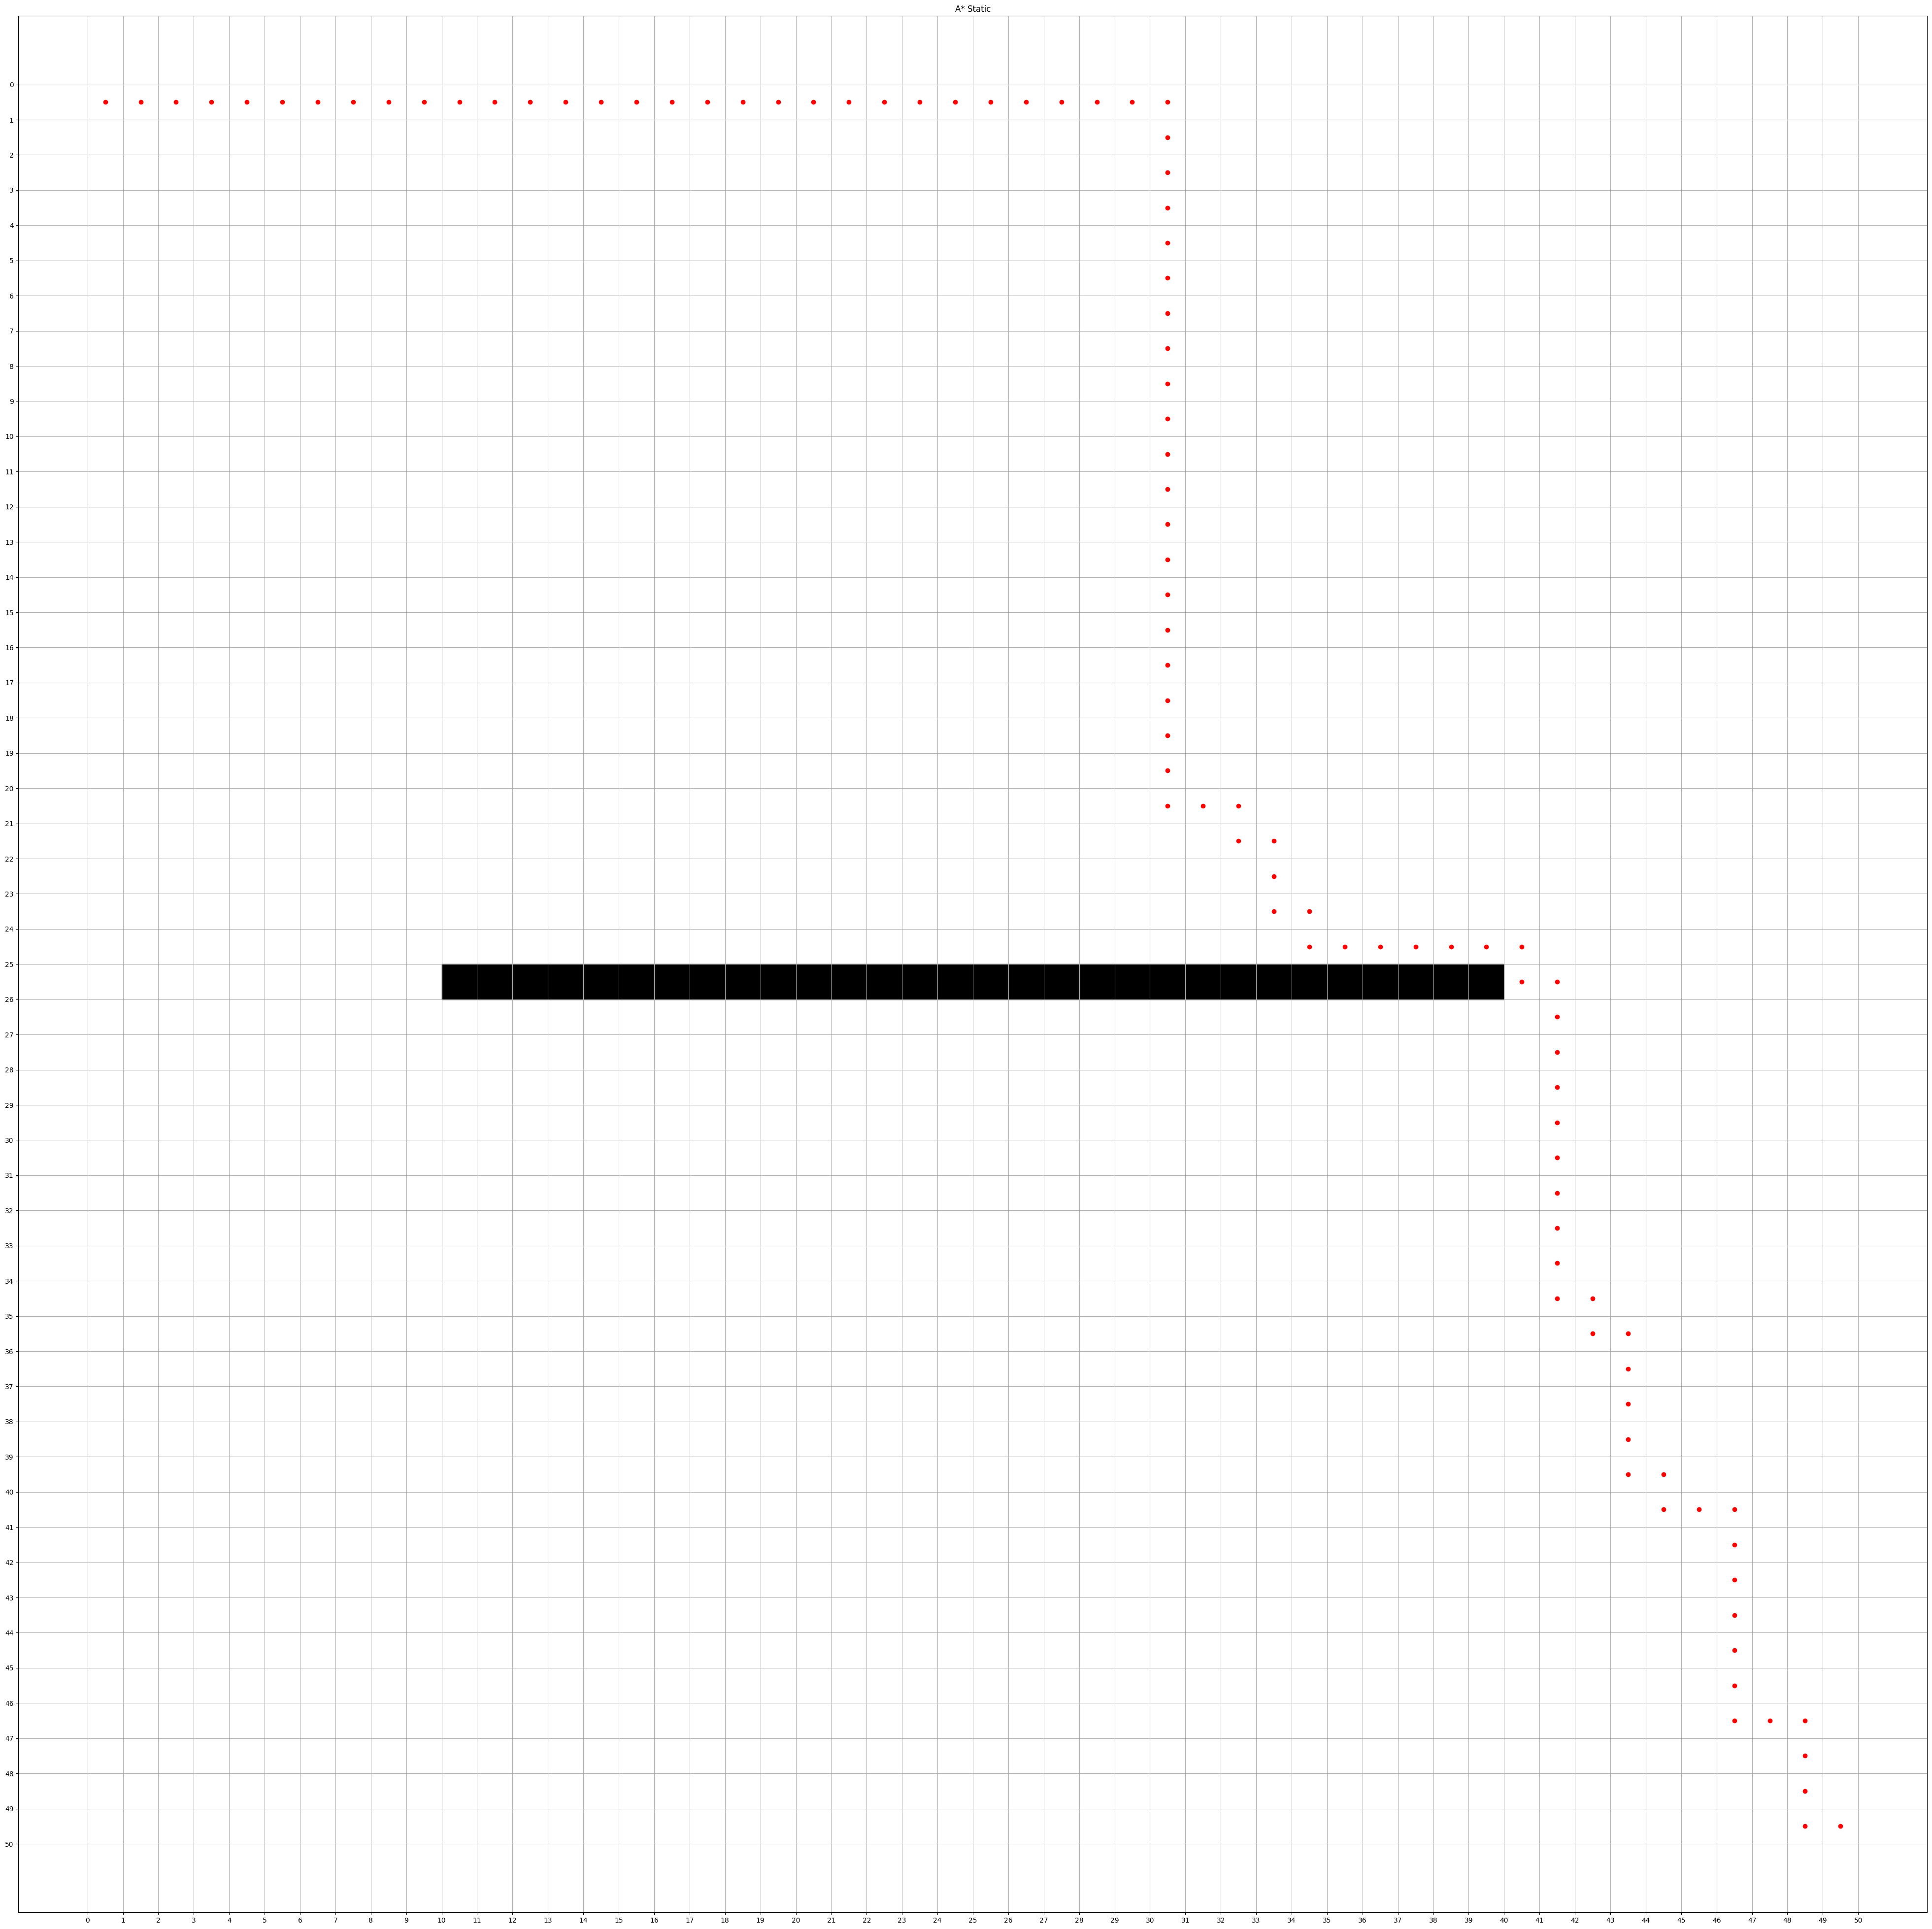

Running A* (dynamic)...


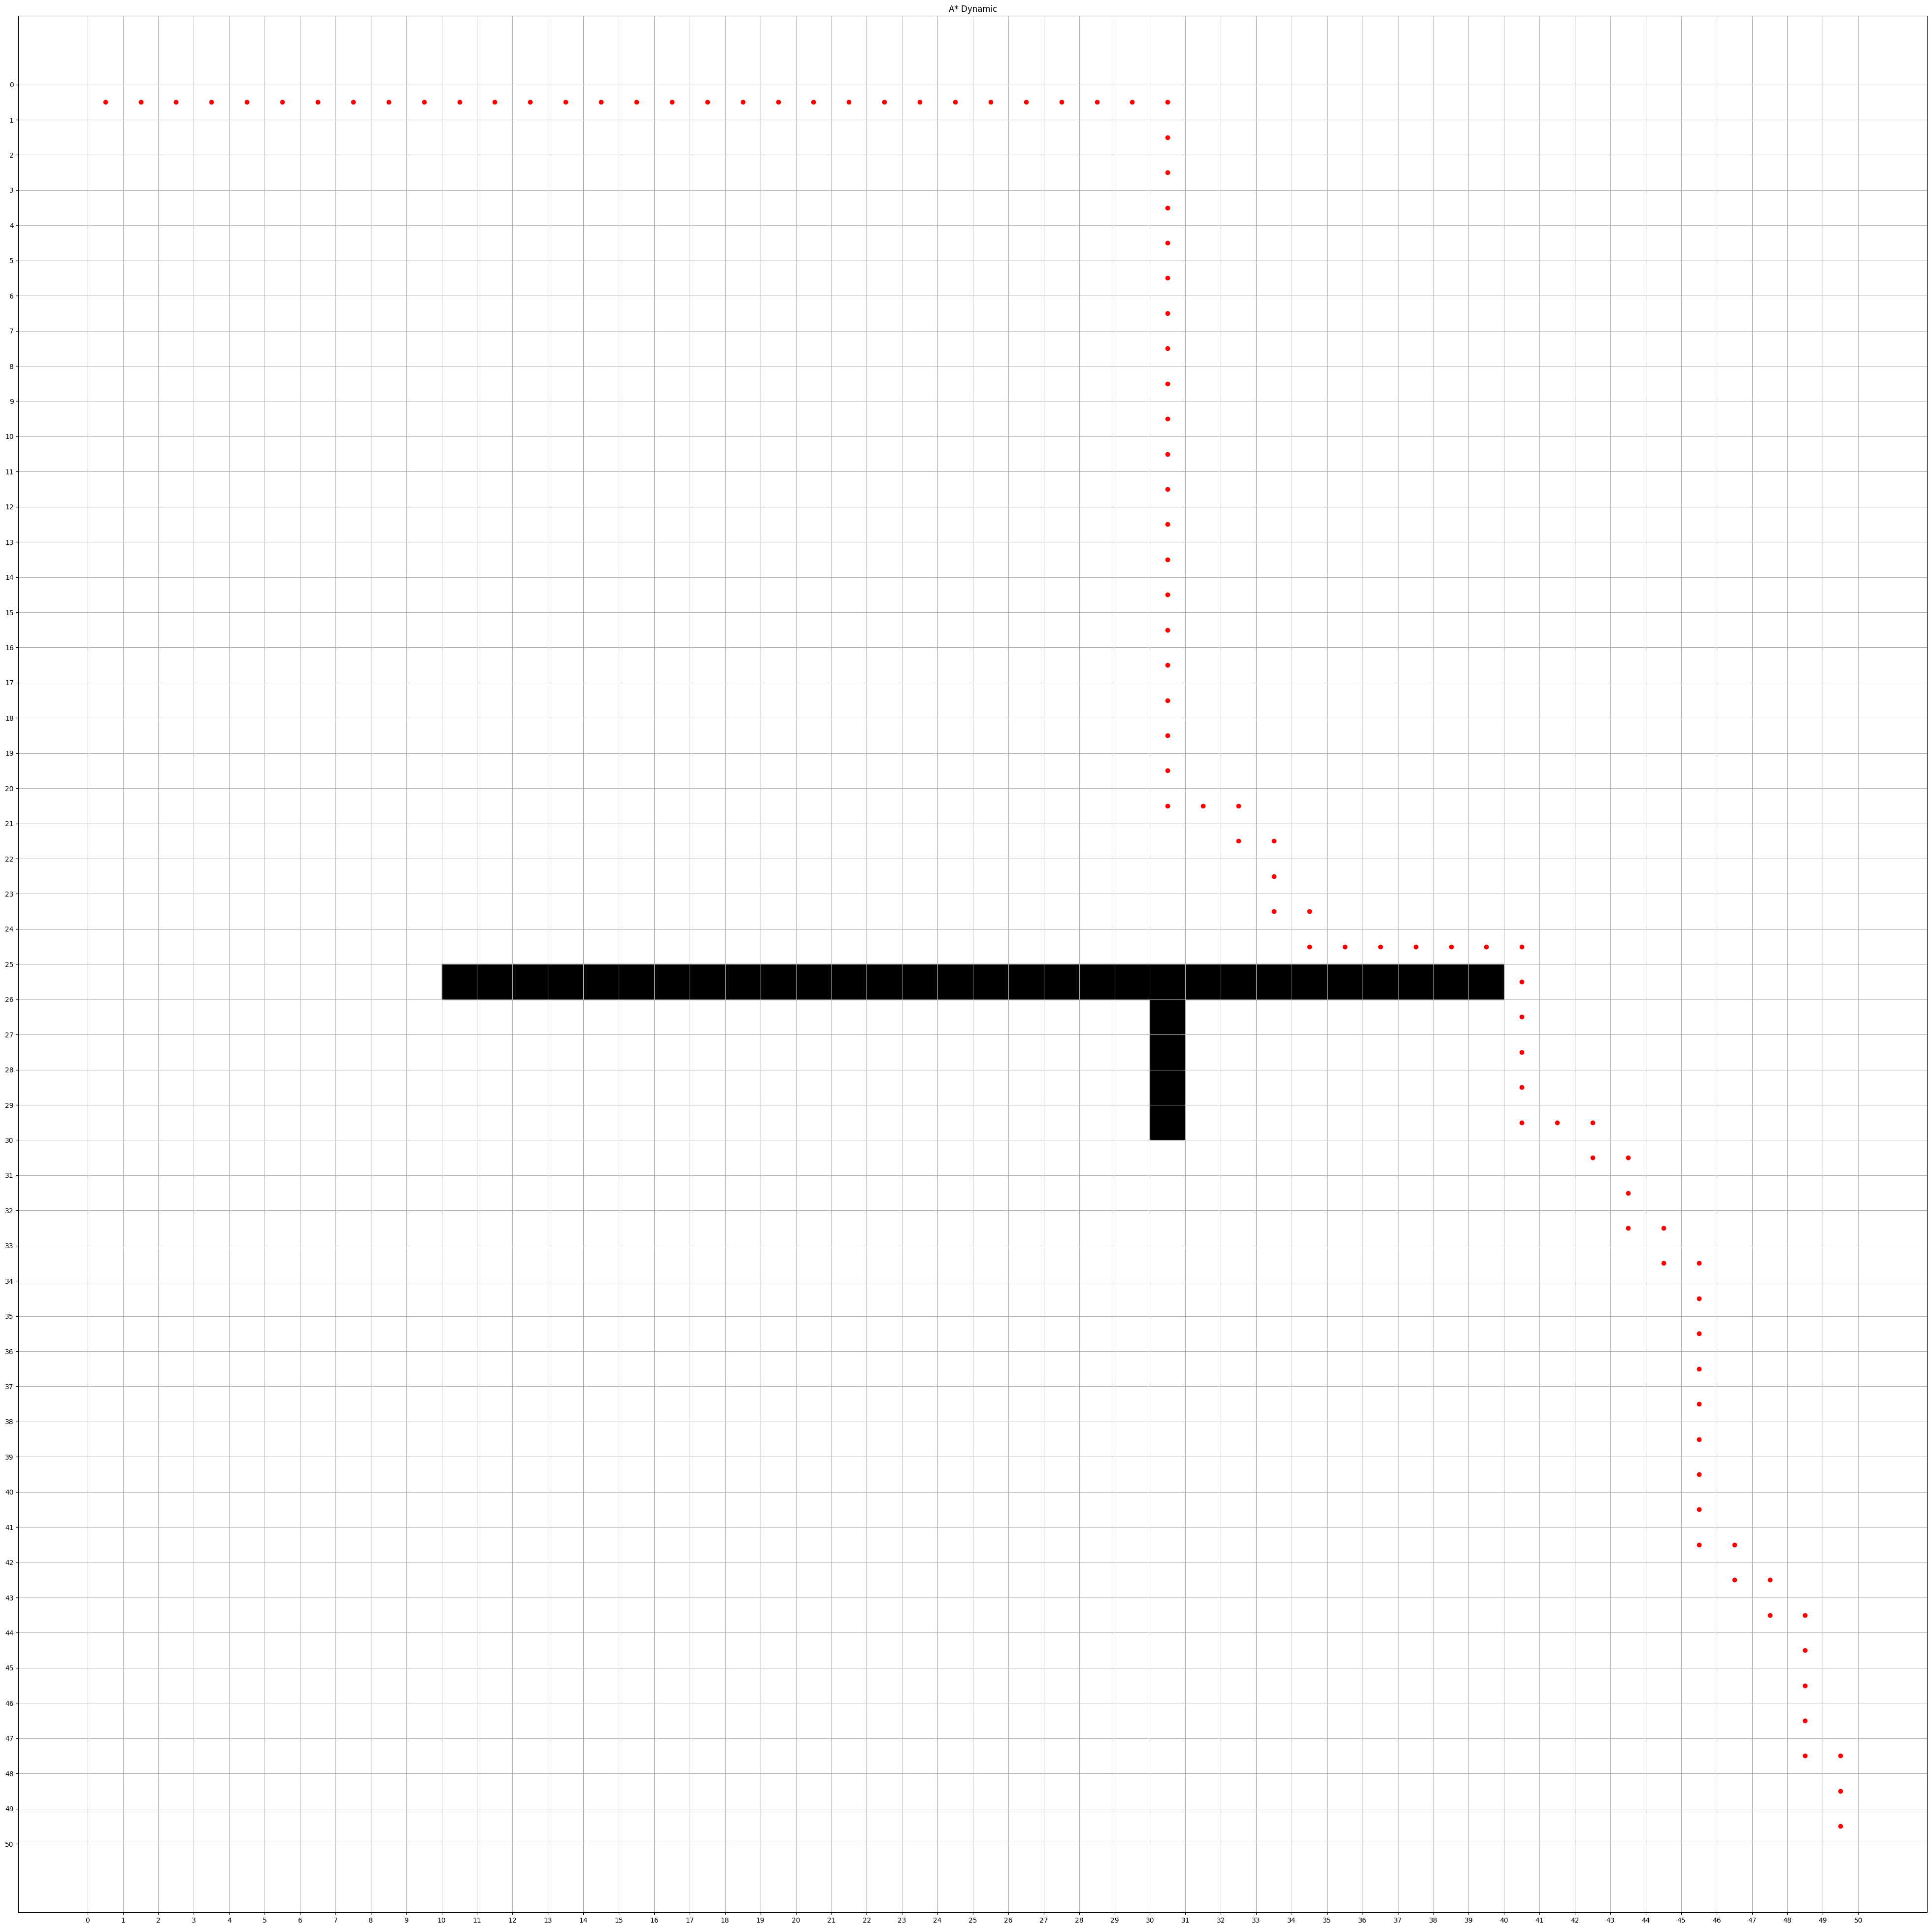

Running D*-Lite (static)...


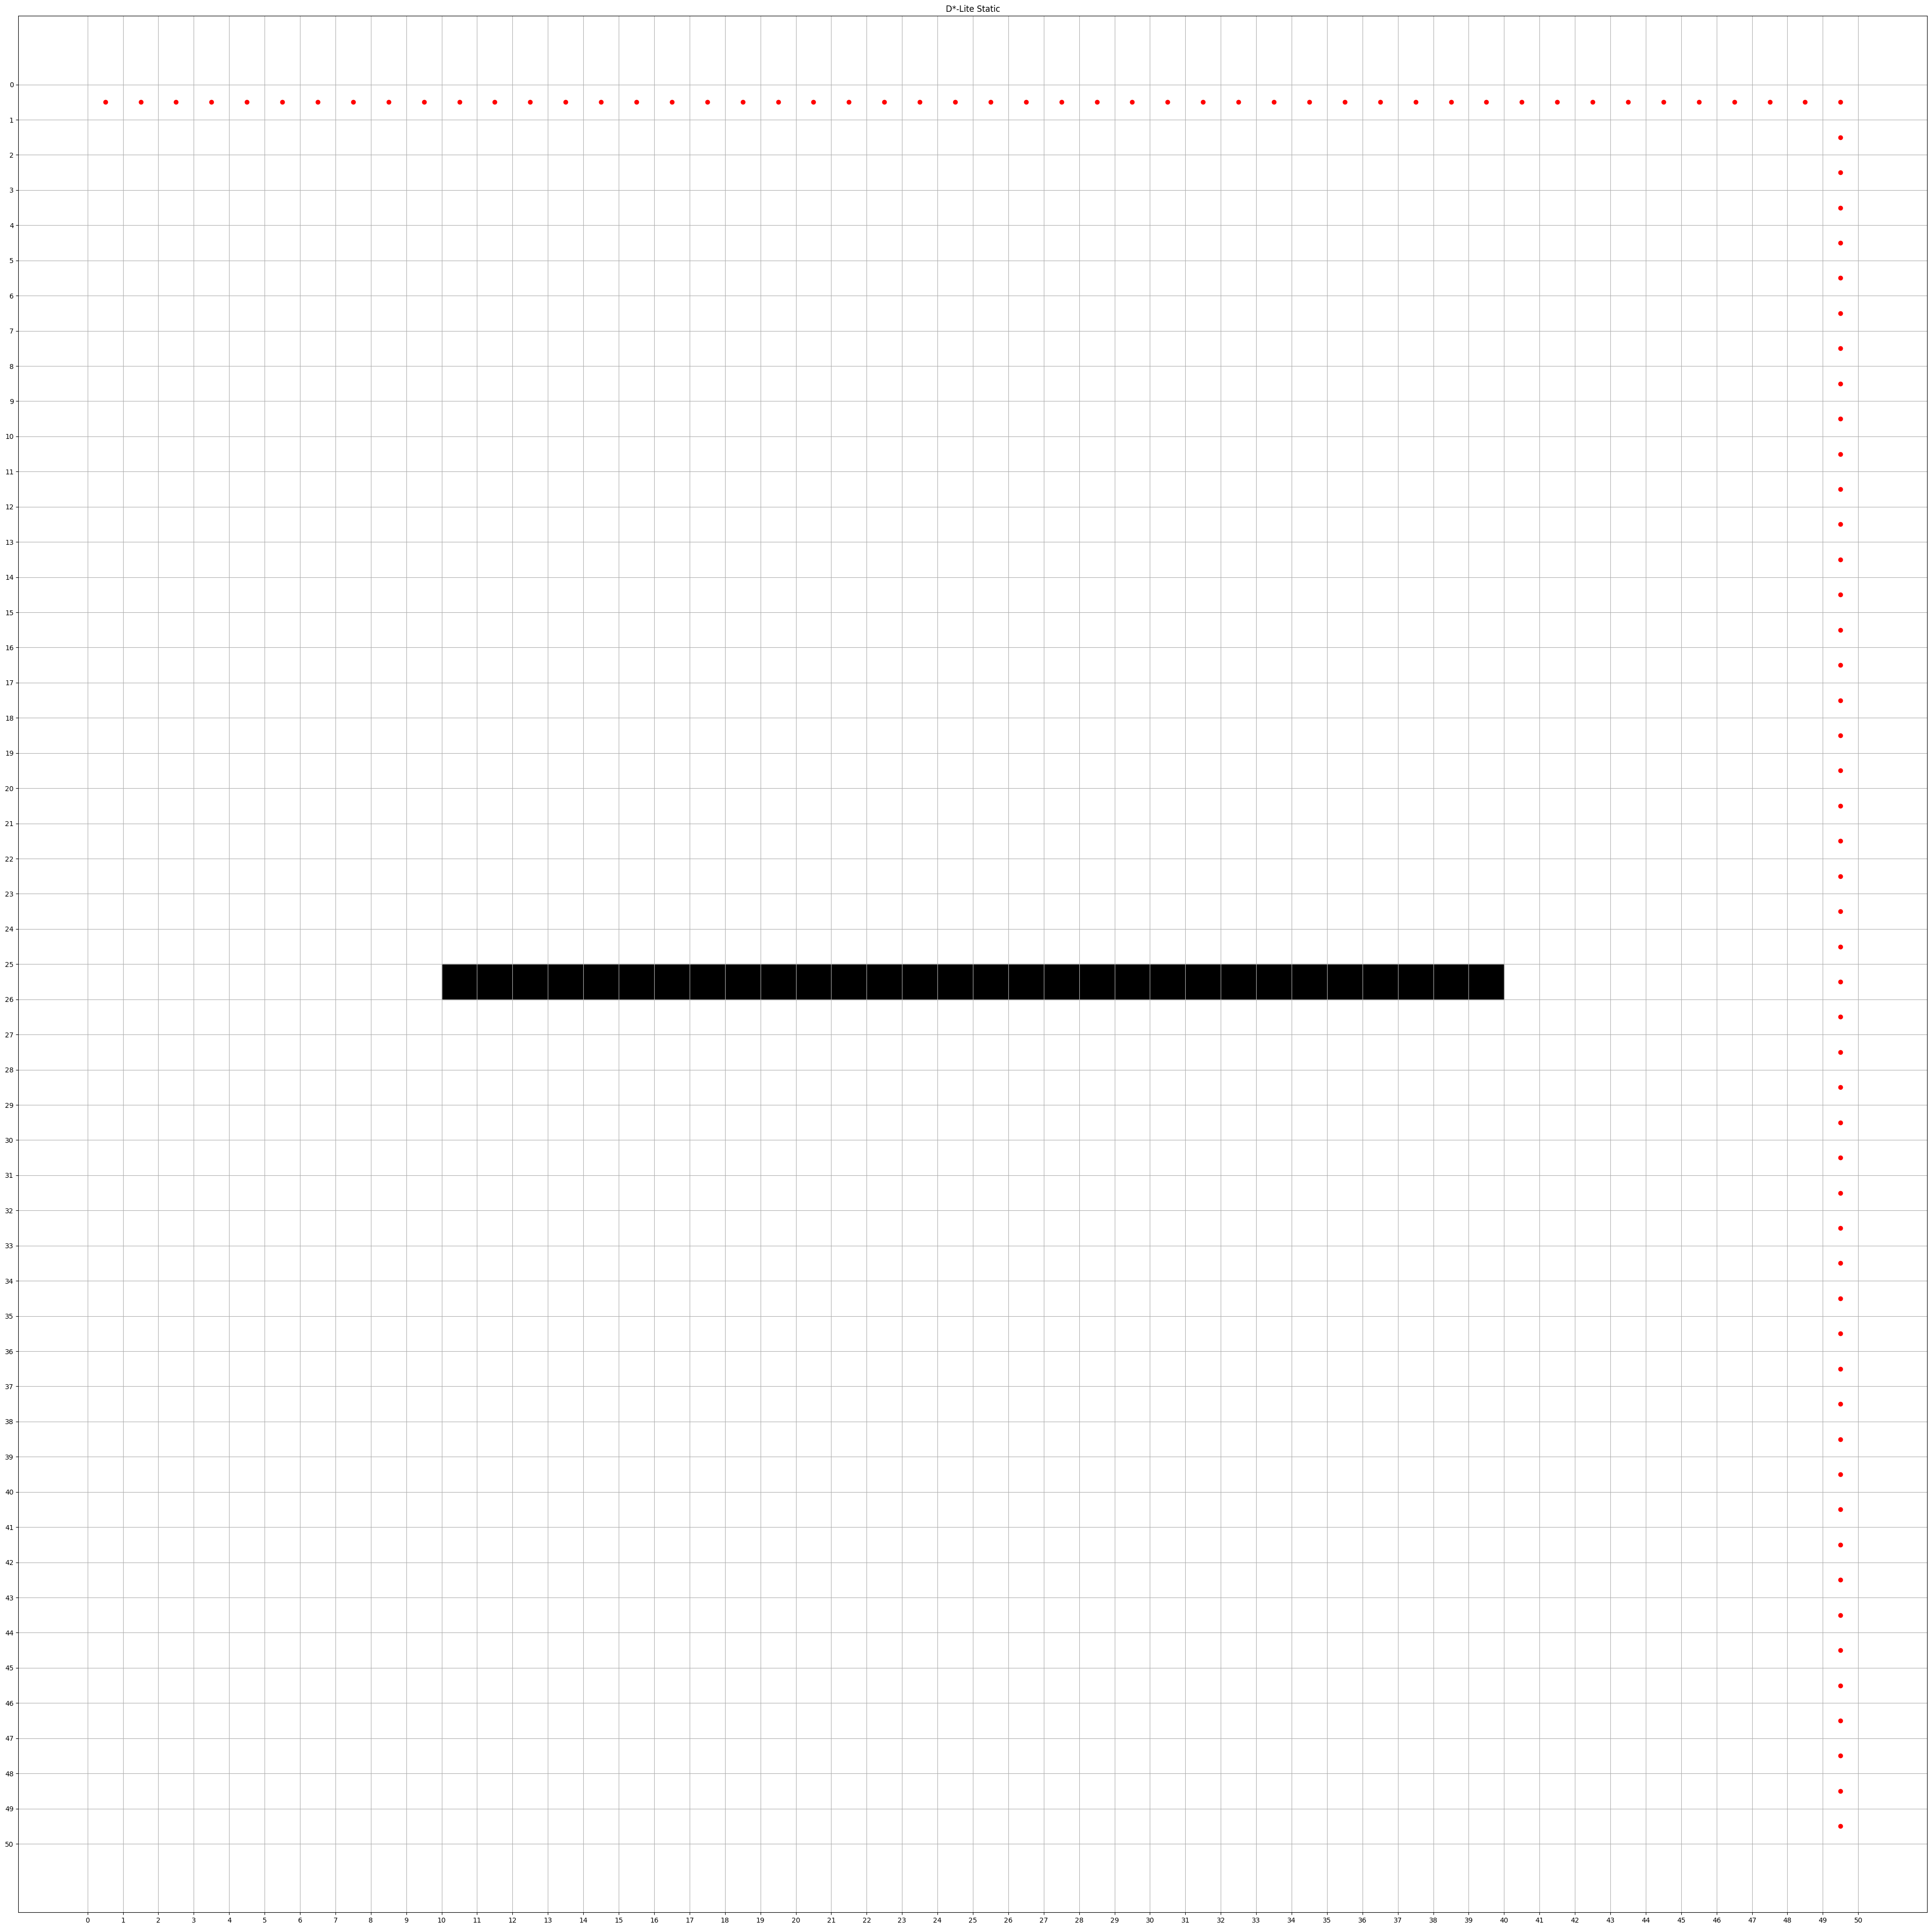

Running D*-Lite (dynamic)...


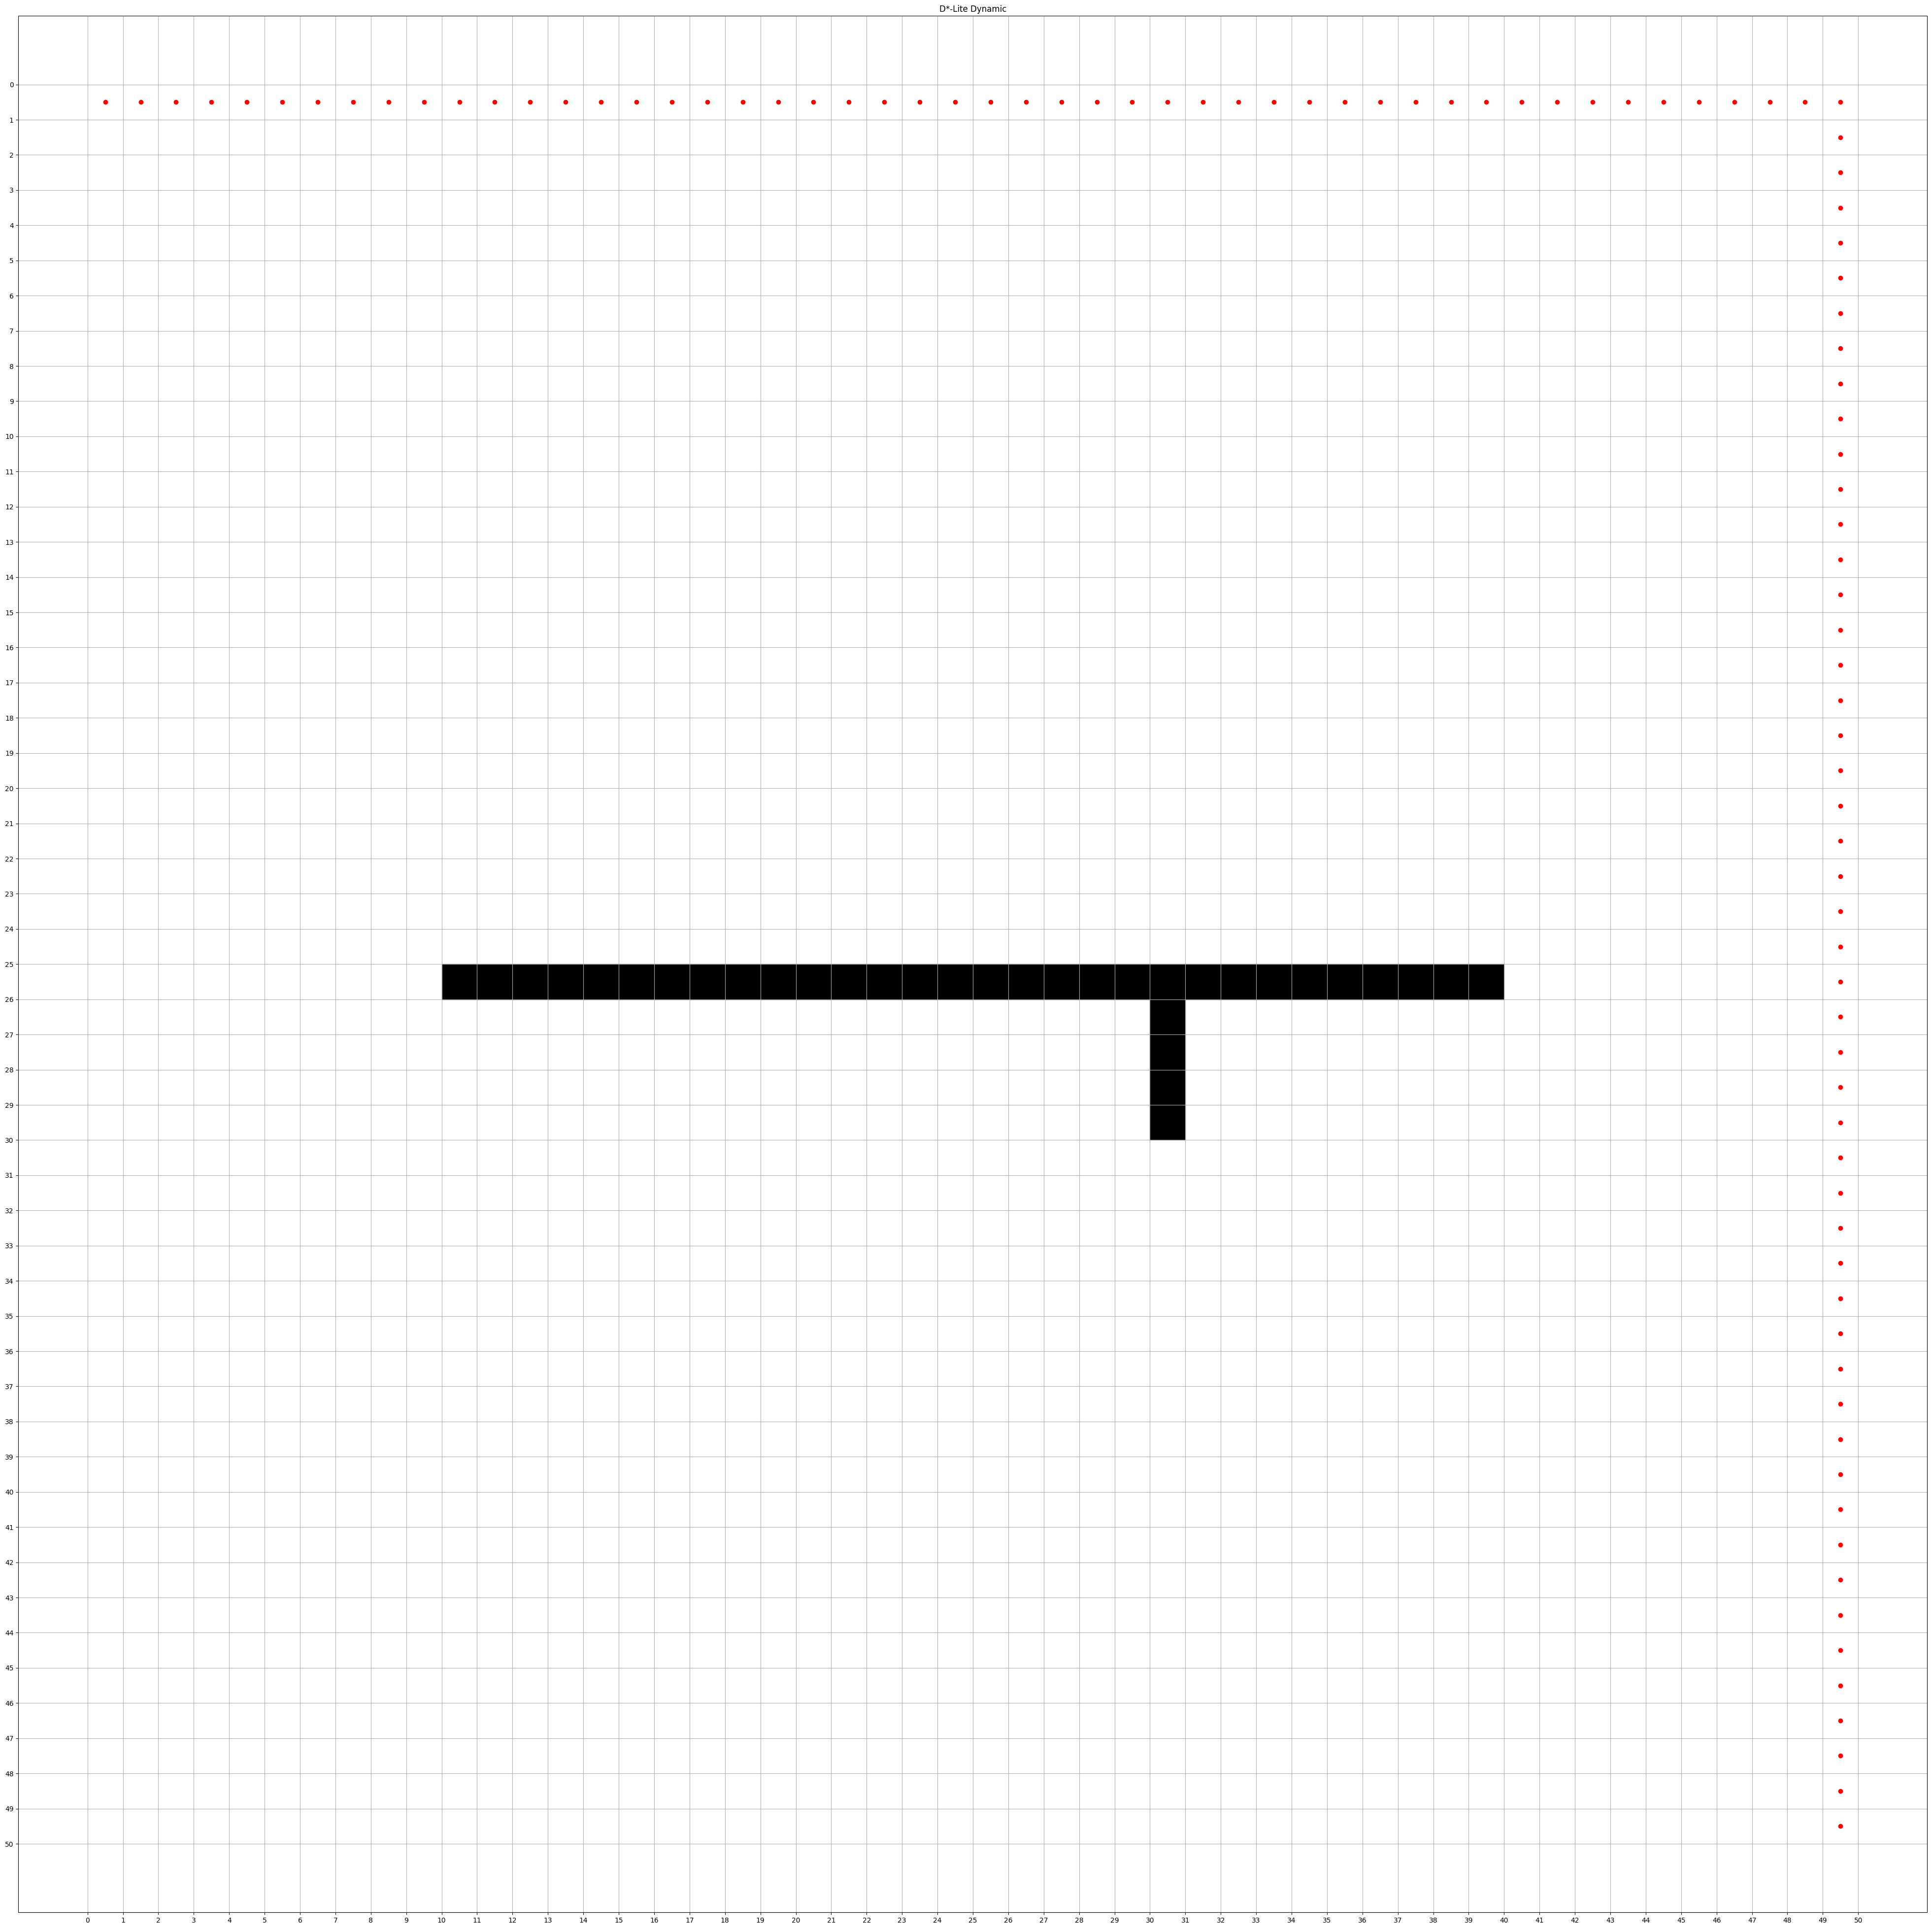


--- Summary Table ---
Algorithm                 Length     Time (s)  
A* (Static)               99         0.060848
A* (Dynamic)              99         0.087478
D*-Lite (Static)          99         0.136501
D*-Lite (Dynamic)         99         0.122658


In [ ]:
# Robot Path Planning using A* and D*-Lite
# Sources:
# - AIMA Python: https://github.com/aimacode/aima-python/blob/master/search.py
# - Koenig & Likhachev (2002), D*-Lite: https://idm-lab.org/bib/abstracts/papers/aaai02b.pdf
# - mdeyo D*-Lite GitHub: https://github.com/mdeyo/d-star-lite/blob/master/d_star_lite.py
# - Atsushi Sakai's PythonRobotics A*: https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/AStar/a_star.py - Influenced A* structure and grid design
# - Visualization (grids) code inspired by ChatGPT assistance

import numpy as np
import matplotlib.pyplot as plt
import heapq
import time
from collections import defaultdict

# -----------------------------
# AIMA-style Node Class (from AIMA Python)
# -----------------------------
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __lt__(self, other):
        return self.path_cost < other.path_cost

    def path(self):
        node, path_back = self, []
        while node:
            path_back.append(node.state)
            node = node.parent
        return list(reversed(path_back))

# -----------------------------
# Grid Problem for Static and Dynamic Pathfinding (AIMA)
# -----------------------------
class GridProblem:
    def __init__(self, grid, initial, goal):
        self.grid = grid
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        x, y = state
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.grid.shape[1] and 0 <= ny < self.grid.shape[0] and self.grid[ny][nx] >= 0:
                yield (nx, ny)

    def result(self, state, action):
        return action

    def goal_test(self, state):
        return state == self.goal

# -----------------------------
# A* Search (based on AIMA best-first graph search and PythonRobotics)
# -----------------------------
def astar_search(problem, h, dynamic_blocks=None):
    node = Node(problem.initial)
    frontier = [(h(node.state), node)]
    reached = {node.state: node}

    while frontier:
        _, current = heapq.heappop(frontier)
        if problem.goal_test(current.state):
            return current.path()
        if dynamic_blocks and current.state in dynamic_blocks:
            continue
        for action in problem.actions(current.state):
            if dynamic_blocks and action in dynamic_blocks:
                continue
            child_state = problem.result(current.state, action)
            cost = current.path_cost + 1
            if child_state not in reached or cost < reached[child_state].path_cost:
                child_node = Node(child_state, current, action, cost)
                reached[child_state] = child_node
                heapq.heappush(frontier, (child_node.path_cost + h(child_state), child_node))
    return []

# -----------------------------
# D*-Lite Implementation (based on Koenig & Likhachev and mdeyo)
# -----------------------------
class GraphNode:
    def __init__(self):
        self.g = float('inf')
        self.rhs = float('inf')
        self.children = {}
        self.parents = {}

class DStarLiteGraph:
    def __init__(self, grid, start, goal):
        self.cells = grid
        self.goal = goal
        self.start = start
        self.graph = defaultdict(GraphNode)
        for y in range(grid.shape[0]):
            for x in range(grid.shape[1]):
                if grid[y][x] >= 0:
                    self._link_neighbors((x, y))

    def _link_neighbors(self, state):
        x, y = state
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            neighbor = (nx, ny)
            if 0 <= nx < self.cells.shape[1] and 0 <= ny < self.cells.shape[0] and self.cells[ny][nx] >= 0:
                self.graph[state].children[neighbor] = 1
                self.graph[neighbor].parents[state] = 1

def manhattan(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def euclidean(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def calculate_key(graph, state, s_start, k_m):
    node = graph.graph[state]
    return (min(node.g, node.rhs) + manhattan(state, s_start) + k_m, min(node.g, node.rhs))

def update_vertex(graph, queue, state, s_start, k_m):
    node = graph.graph[state]
    if state != graph.goal and node.children:
        node.rhs = min([graph.graph[s].g + cost for s, cost in node.children.items()])
    for i in range(len(queue)):
        if queue[i][2] == state:
            queue.pop(i)
            break
    if node.g != node.rhs:
        heapq.heappush(queue, calculate_key(graph, state, s_start, k_m) + (state,))

def compute_shortest_path(graph, queue, s_start, k_m):
    while queue and (graph.graph[s_start].rhs != graph.graph[s_start].g or queue[0][:2] < calculate_key(graph, s_start, s_start, k_m)):
        k_old = queue[0][:2]
        u = heapq.heappop(queue)[2]
        node_u = graph.graph[u]
        if k_old < calculate_key(graph, u, s_start, k_m):
            heapq.heappush(queue, calculate_key(graph, u, s_start, k_m) + (u,))
        elif node_u.g > node_u.rhs:
            node_u.g = node_u.rhs
            for s in node_u.parents:
                update_vertex(graph, queue, s, s_start, k_m)
        else:
            node_u.g = float('inf')
            update_vertex(graph, queue, u, s_start, k_m)
            for s in node_u.parents:
                update_vertex(graph, queue, s, s_start, k_m)

def d_star_lite(grid, start, goal):
    graph = DStarLiteGraph(grid, start, goal)
    graph.graph[goal].rhs = 0
    queue = []
    k_m = 0
    heapq.heappush(queue, calculate_key(graph, goal, start, k_m) + (goal,))
    compute_shortest_path(graph, queue, start, k_m)

    path = [start]
    current = start
    while current != goal:
        next_states = list(graph.graph[current].children)
        if not next_states:
            break
        current = min(next_states, key=lambda s: graph.graph[s].g + graph.graph[current].children[s])
        path.append(current)
    return path

# -----------------------------
# Visualization and Main
# -----------------------------
def draw_grid(grid, path, title):
    plt.figure(figsize=(grid.shape[1], grid.shape[0]))
    for y in range(grid.shape[0]):
        for x in range(grid.shape[1]):
            if grid[y][x] == -1:
                plt.fill_between([x, x+1], y, y+1, color='black')
    for (x, y) in path:
        plt.plot(x + 0.5, y + 0.5, 'ro')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid(True, which='both')
    plt.xticks(np.arange(0, grid.shape[1]+1, 1))
    plt.yticks(np.arange(0, grid.shape[0]+1, 1))
    plt.show()

def run_experiment(rows, cols, obstacles, dynamic_blocks, start, goal):
    grid = np.zeros((rows, cols), dtype=int)
    for (x, y) in obstacles:
        grid[y][x] = -1
    grid_dyn = grid.copy()
    for (x, y) in dynamic_blocks:
        grid_dyn[y][x] = -1

    print(f"\n--- {rows}x{cols} Grid ---")
    print("Running A* (static)...")
    static_problem = GridProblem(grid, start, goal)
    t1 = time.time()
    path_astar_static = astar_search(static_problem, lambda s: manhattan(s, goal))
    t2 = time.time()
    draw_grid(grid, path_astar_static, "A* Static")

    print("Running A* (dynamic)...")
    dynamic_problem = GridProblem(grid_dyn, start, goal)
    t3 = time.time()
    path_astar_dynamic = astar_search(dynamic_problem, lambda s: manhattan(s, goal), dynamic_blocks)
    t4 = time.time()
    draw_grid(grid_dyn, path_astar_dynamic, "A* Dynamic")

    print("Running D*-Lite (static)...")
    t5 = time.time()
    path_dstar_static = d_star_lite(grid, start, goal)
    t6 = time.time()
    draw_grid(grid, path_dstar_static, "D*-Lite Static")

    print("Running D*-Lite (dynamic)...")
    t7 = time.time()
    path_dstar_dynamic = d_star_lite(grid_dyn, start, goal)
    t8 = time.time()
    draw_grid(grid_dyn, path_dstar_dynamic, "D*-Lite Dynamic")

    print("\n--- Summary Table ---")
    print("{:<25} {:<10} {:<10}".format("Algorithm", "Length", "Time (s)"))
    print("{:<25} {:<10} {:.6f}".format("A* (Static)", len(path_astar_static), t2 - t1))
    print("{:<25} {:<10} {:.6f}".format("A* (Dynamic)", len(path_astar_dynamic), t4 - t3))
    print("{:<25} {:<10} {:.6f}".format("D*-Lite (Static)", len(path_dstar_static), t6 - t5))
    print("{:<25} {:<10} {:.6f}".format("D*-Lite (Dynamic)", len(path_dstar_dynamic), t8 - t7))

def main():
    run_experiment(
        rows=10,
        cols=10,
        obstacles=[(1, 1), (2, 2), (3, 3), (4, 4), (6, 0), (6, 1), (6, 2), (2, 5), (3, 5), (4, 5), (5, 5), (7, 7), (8, 8)],
        dynamic_blocks={(5, 6), (5, 7), (5, 8)},
        start=(0, 0),
        goal=(9, 9)
    )

    run_experiment(
        rows=50,
        cols=50,
        obstacles=[(i, 25) for i in range(10, 40)],
        dynamic_blocks={(30, 26), (30, 27), (30, 28), (30, 29)},
        start=(0, 0),
        goal=(49, 49)
    )

if __name__ == '__main__':
    main()



--- 10x10 Grid ---

Run 1/10

Run 2/10

Run 3/10

Run 4/10

Run 5/10

Run 6/10

Run 7/10

Run 8/10

Run 9/10

Run 10/10


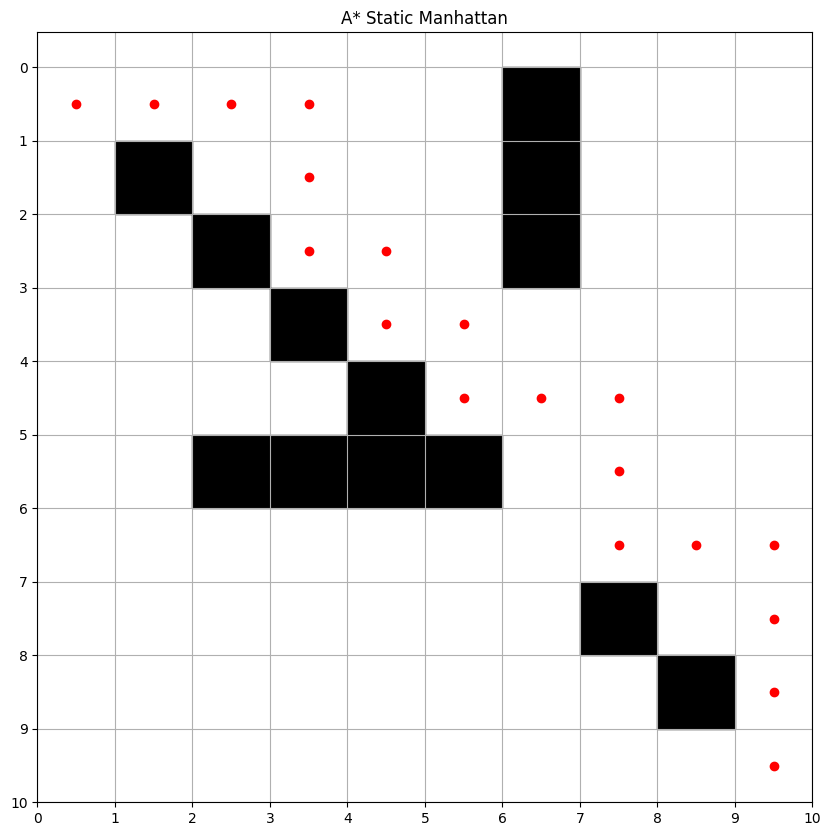

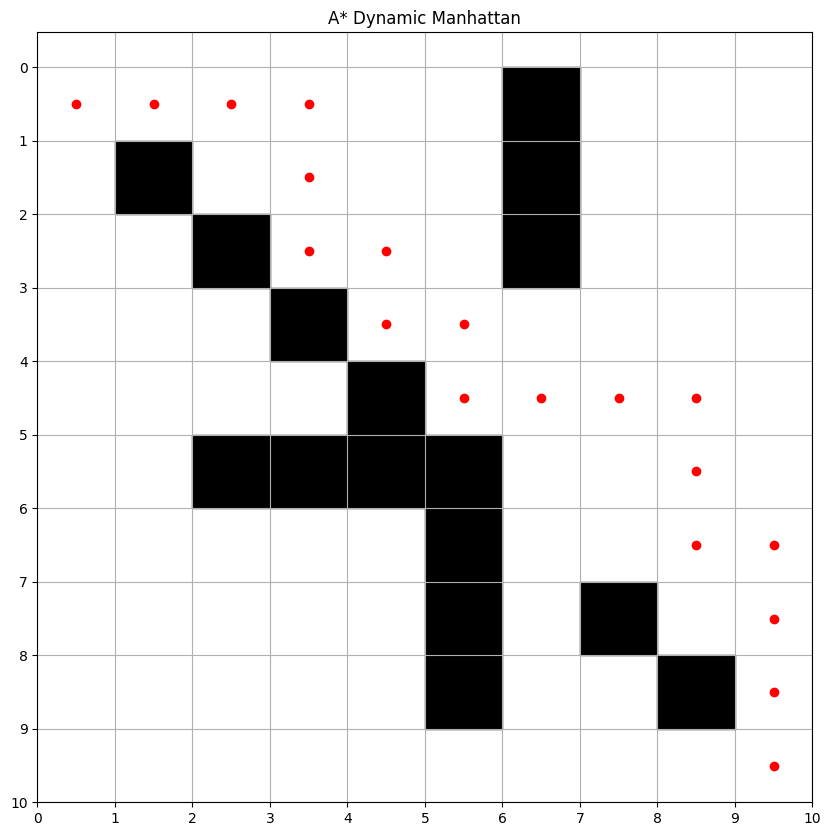

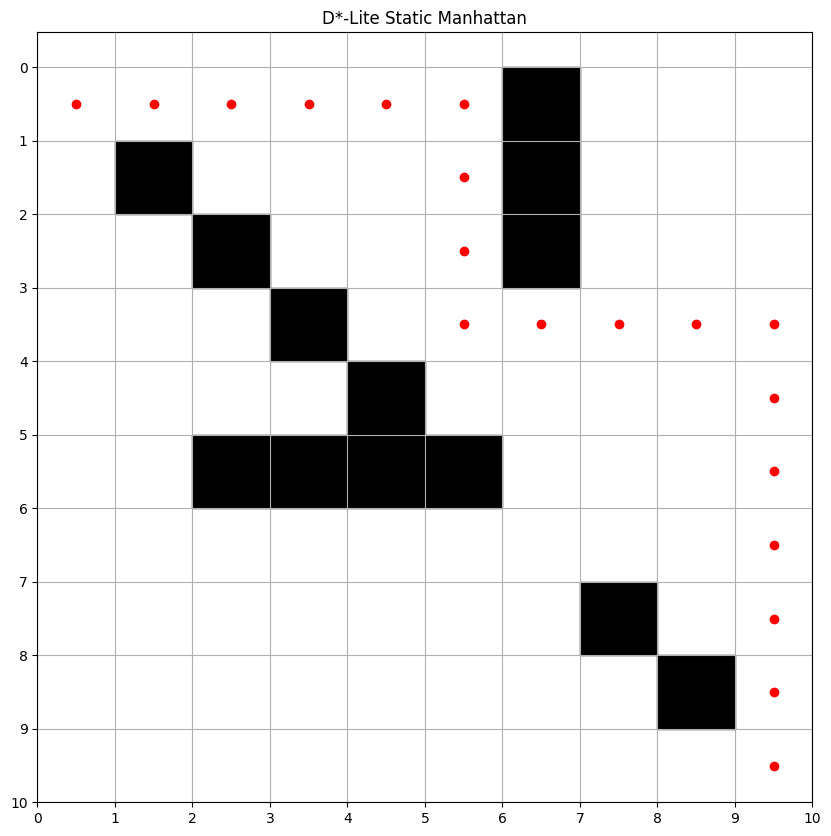

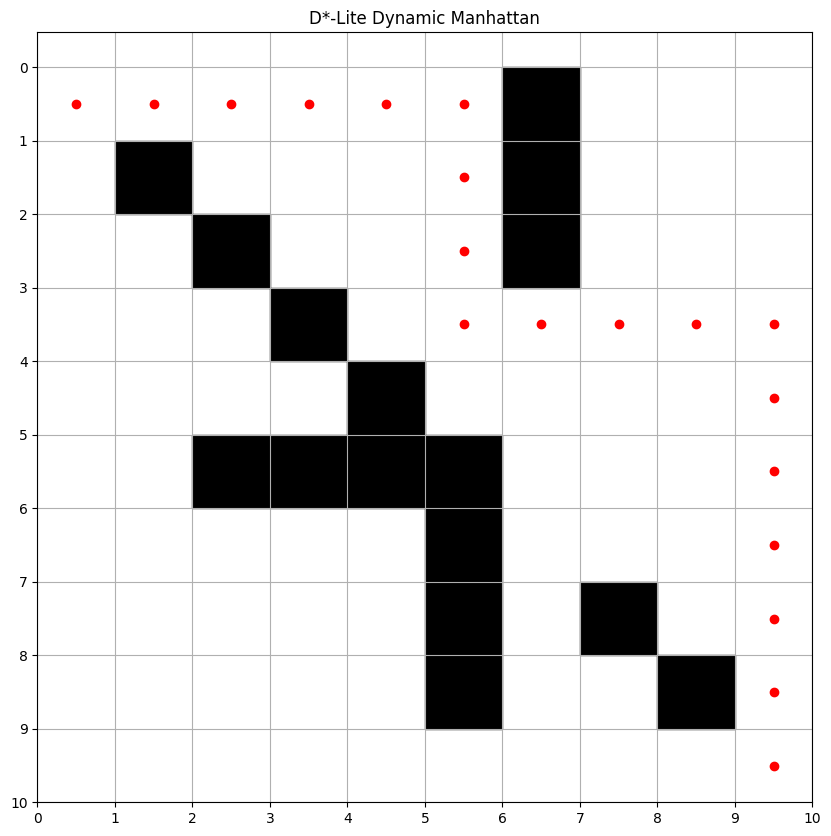

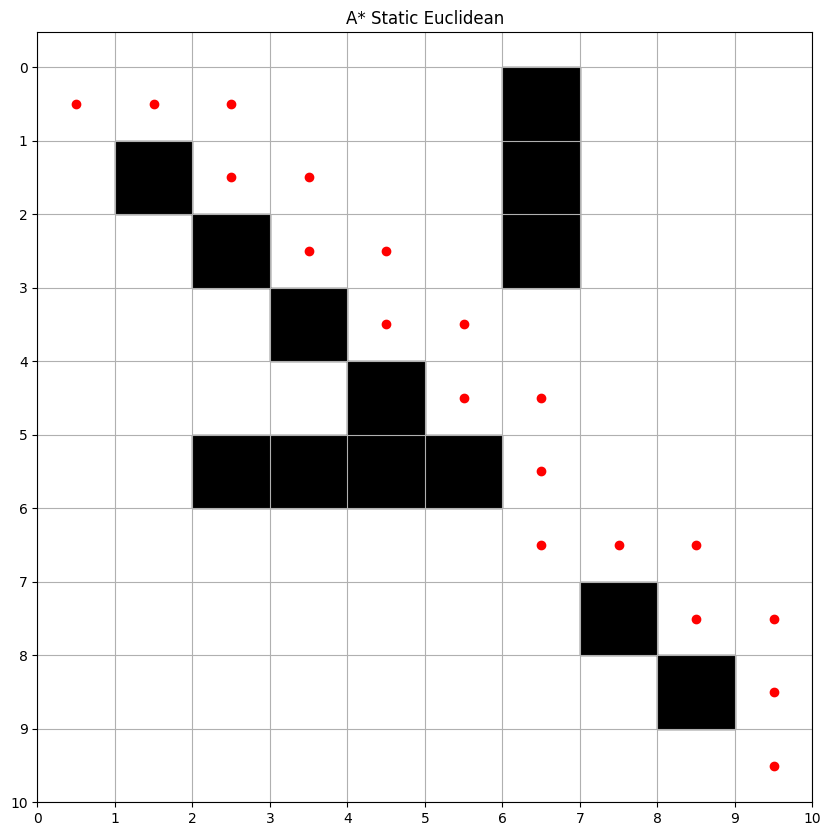

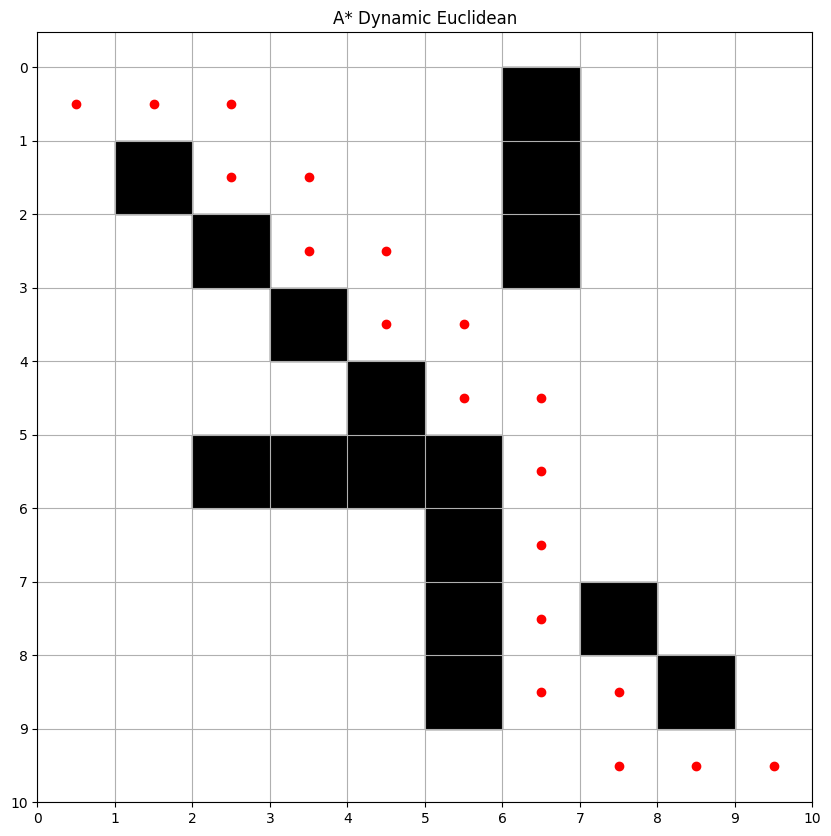

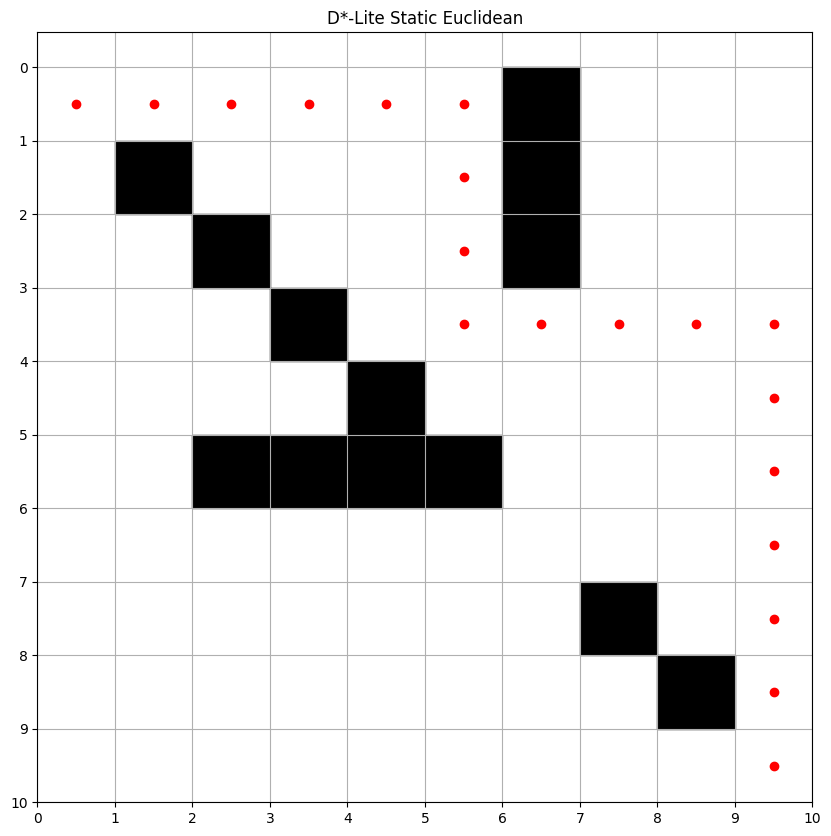

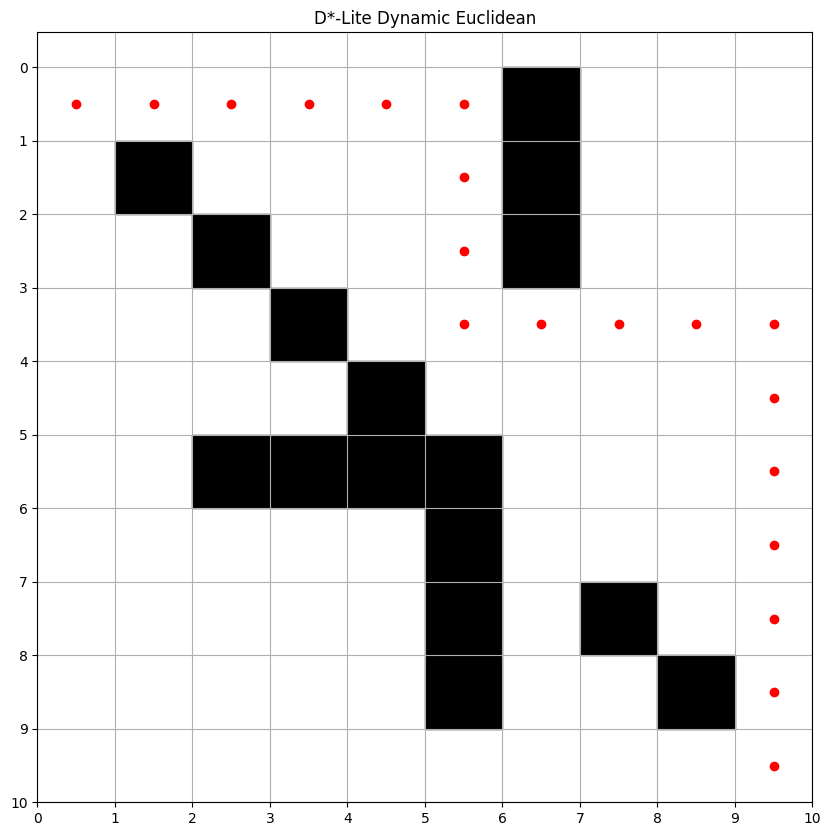

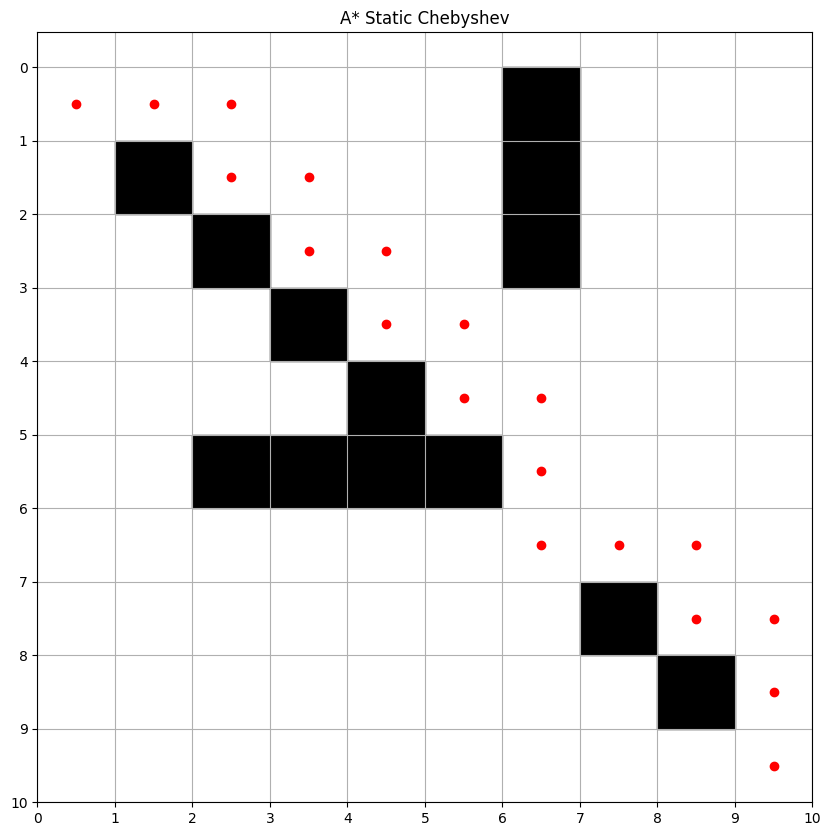

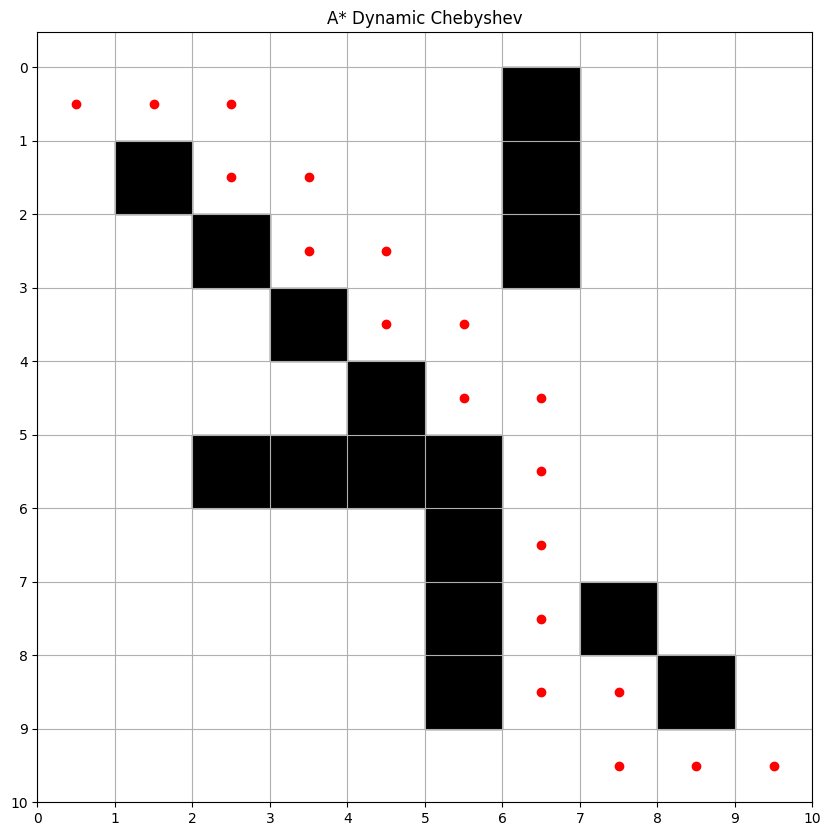

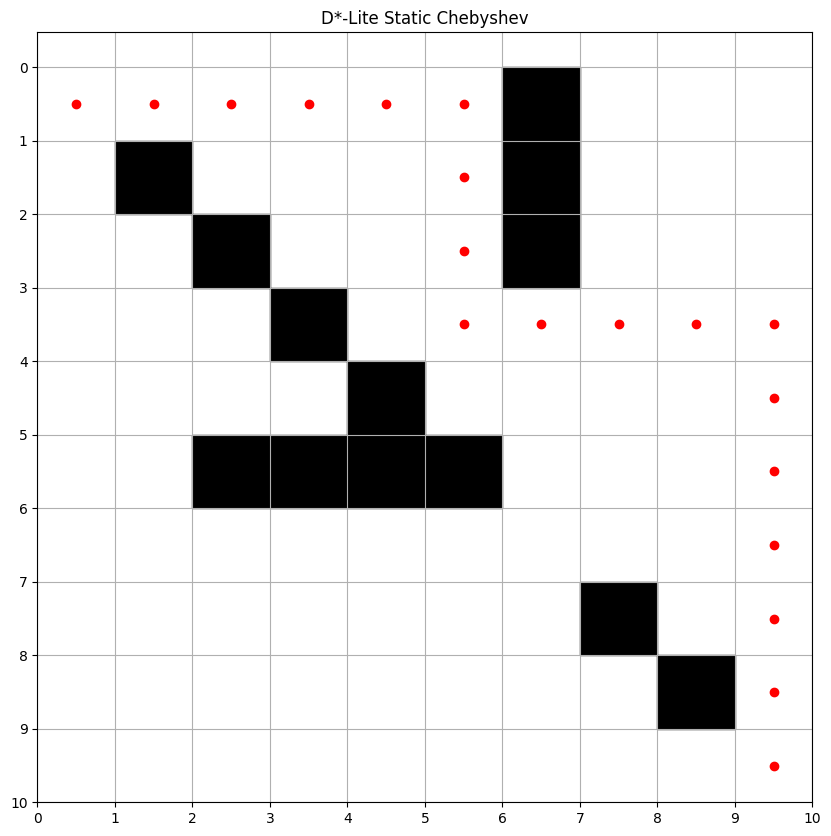

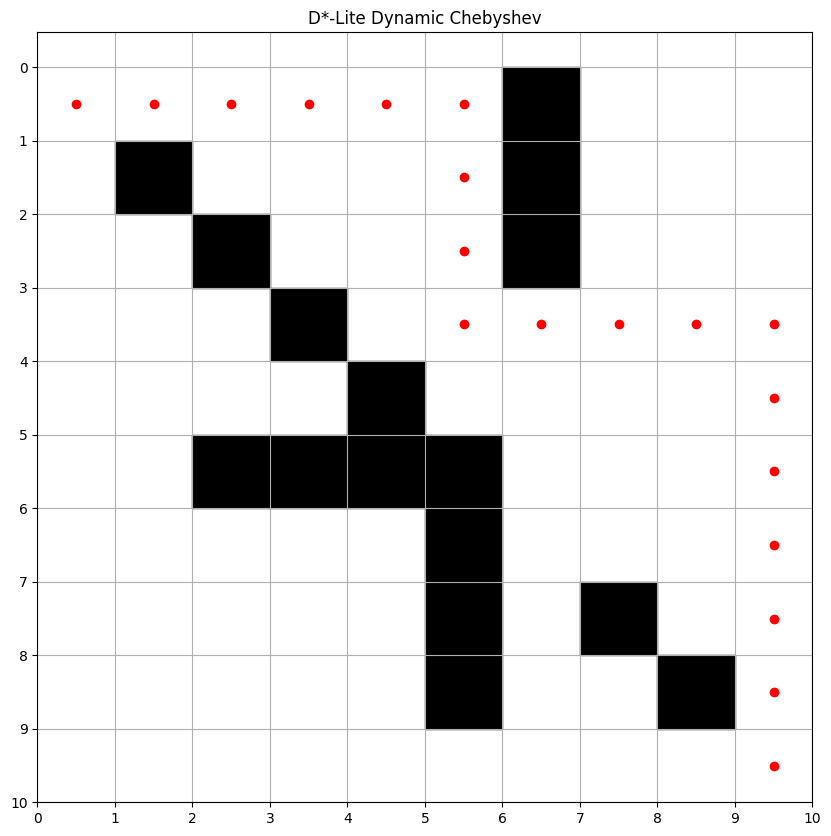


--- Summary Table (Averages over 10 runs) ---
Algorithm                      Length     Time (s)  
A* (Static, Manhattan)         19         0.001825
A* (Dynamic, Manhattan)        19         0.000696
D*-Lite (Static, Manhattan)    19         0.002965
D*-Lite (Dynamic, Manhattan)   19         0.004965
A* (Static, Euclidean)         19         0.001622
A* (Dynamic, Euclidean)        19         0.000860
D*-Lite (Static, Euclidean)    19         0.005737
D*-Lite (Dynamic, Euclidean)   19         0.008306
A* (Static, Chebyshev)         19         0.001801
A* (Dynamic, Chebyshev)        19         0.000699
D*-Lite (Static, Chebyshev)    19         0.004581
D*-Lite (Dynamic, Chebyshev)   19         0.006049

--- 50x50 Grid ---

Run 1/10

Run 2/10

Run 3/10

Run 4/10

Run 5/10

Run 6/10

Run 7/10

Run 8/10

Run 9/10

Run 10/10


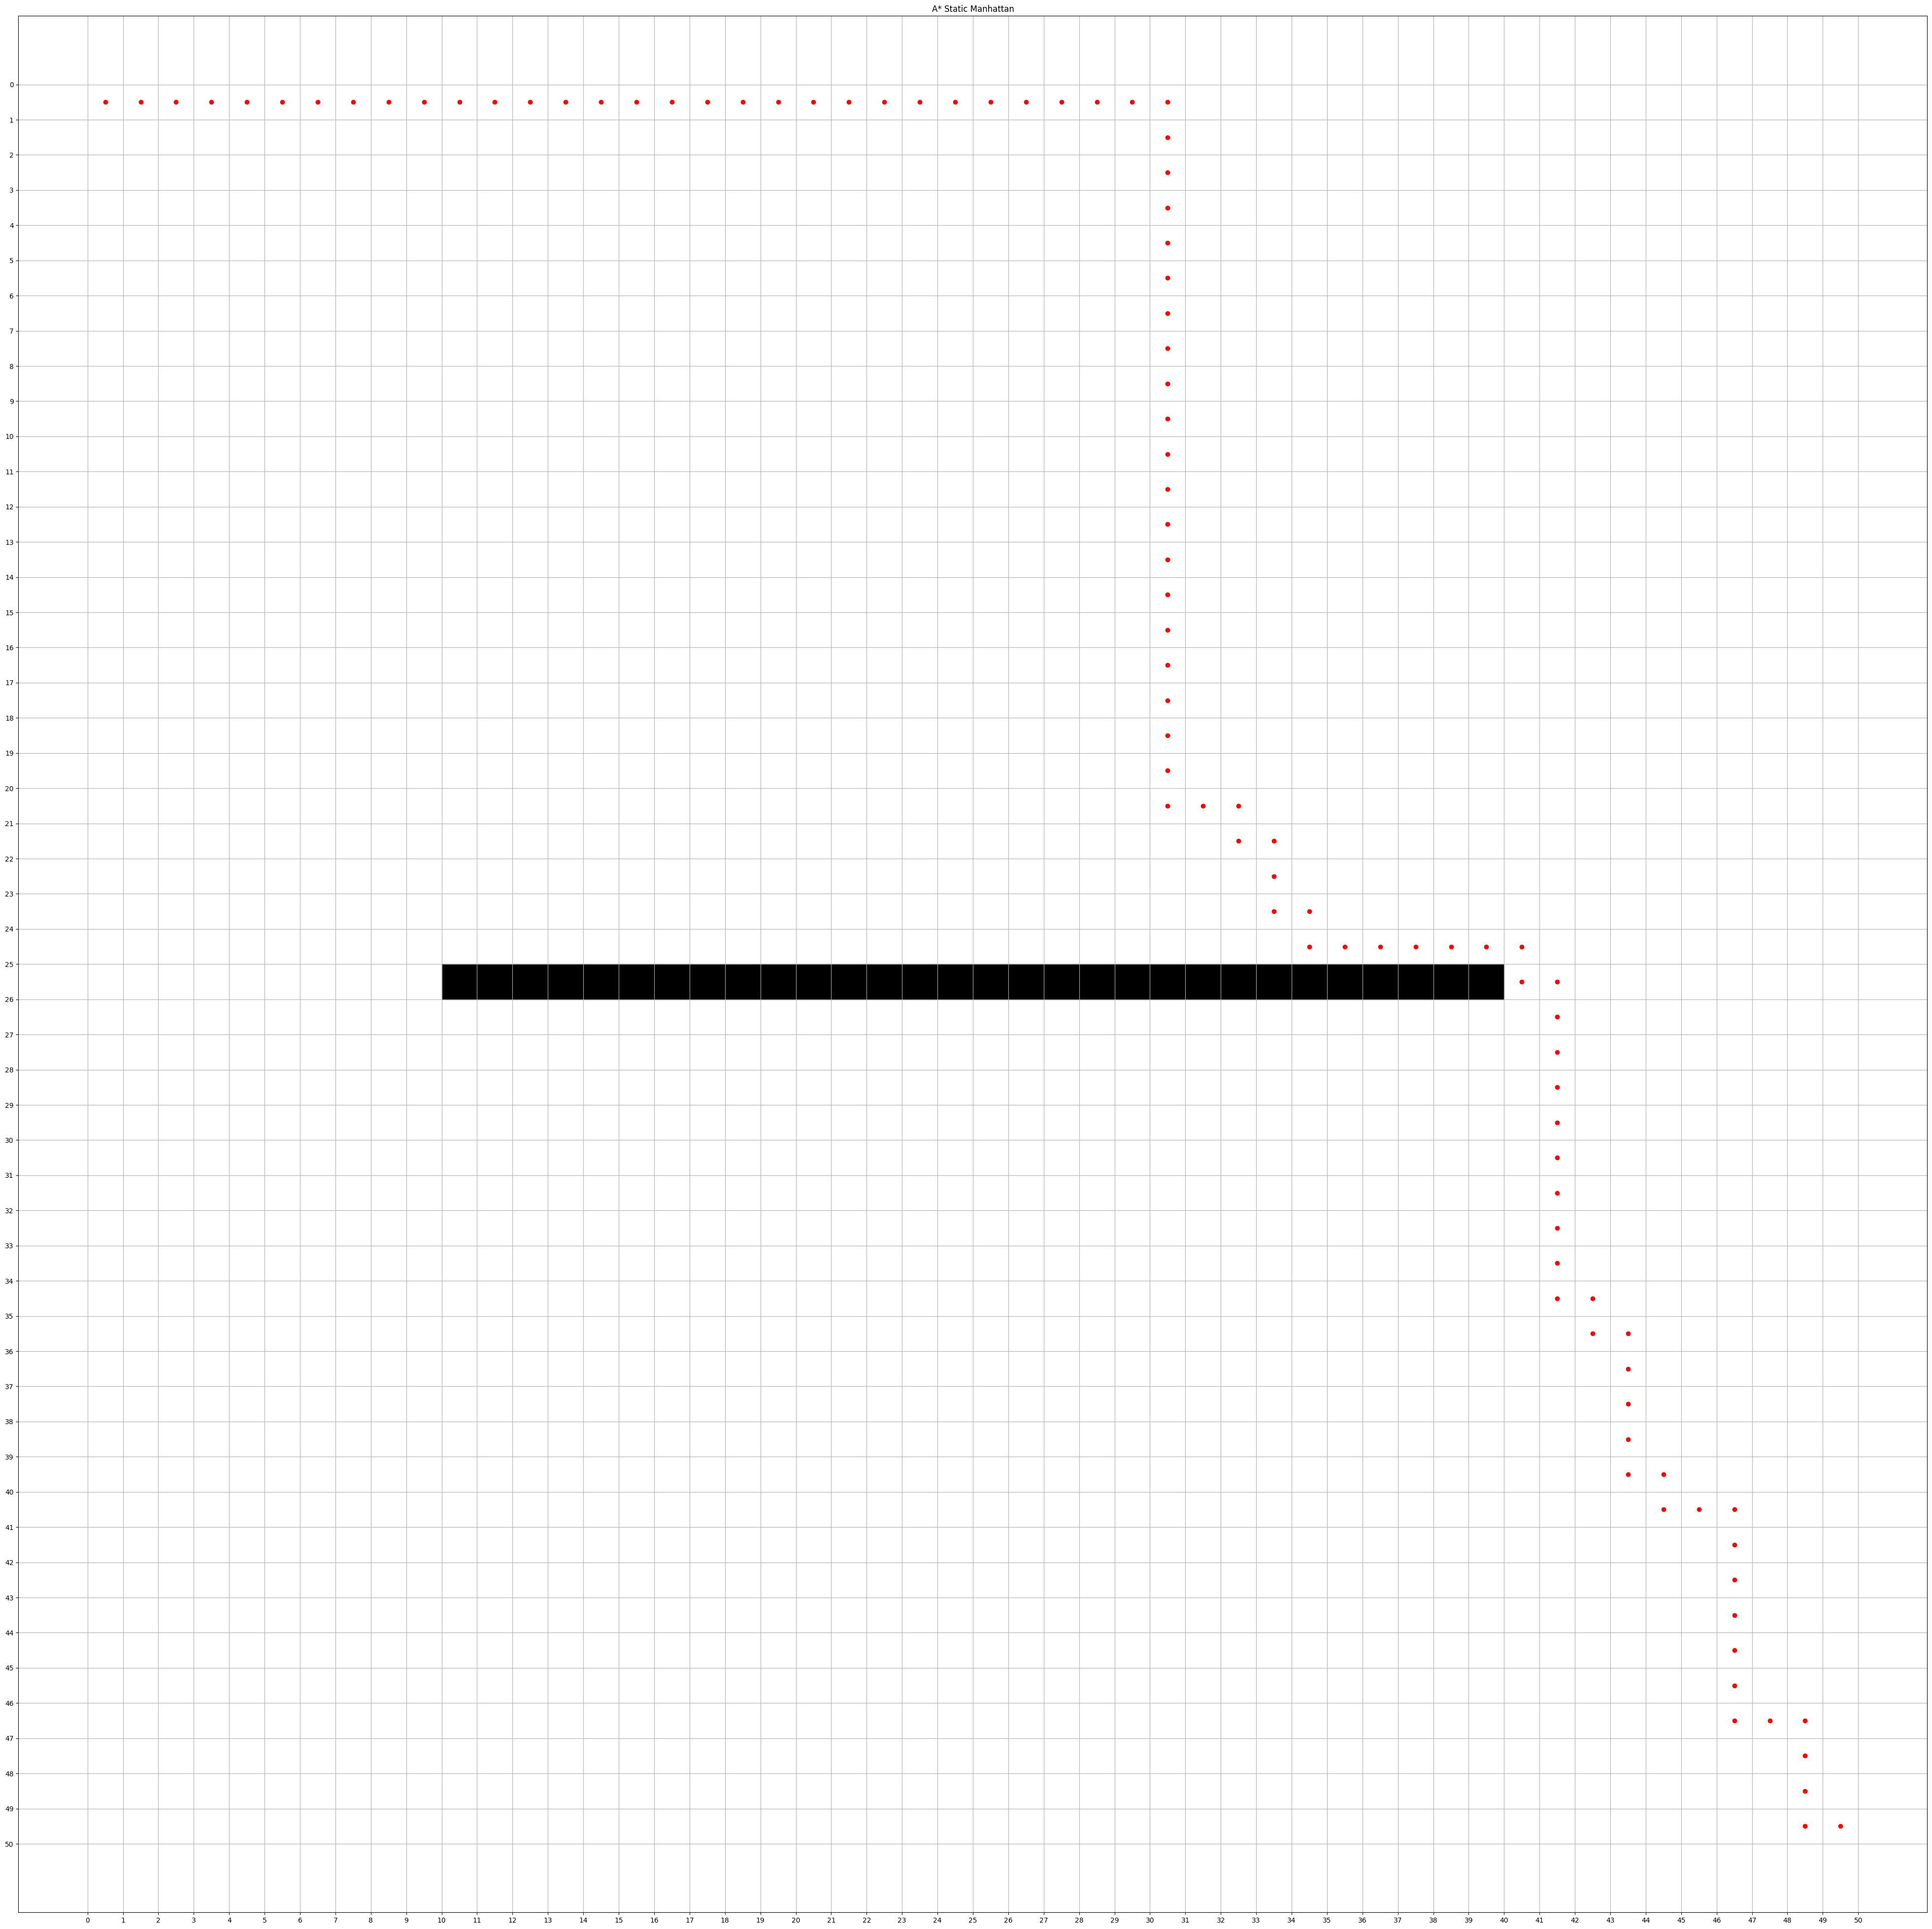

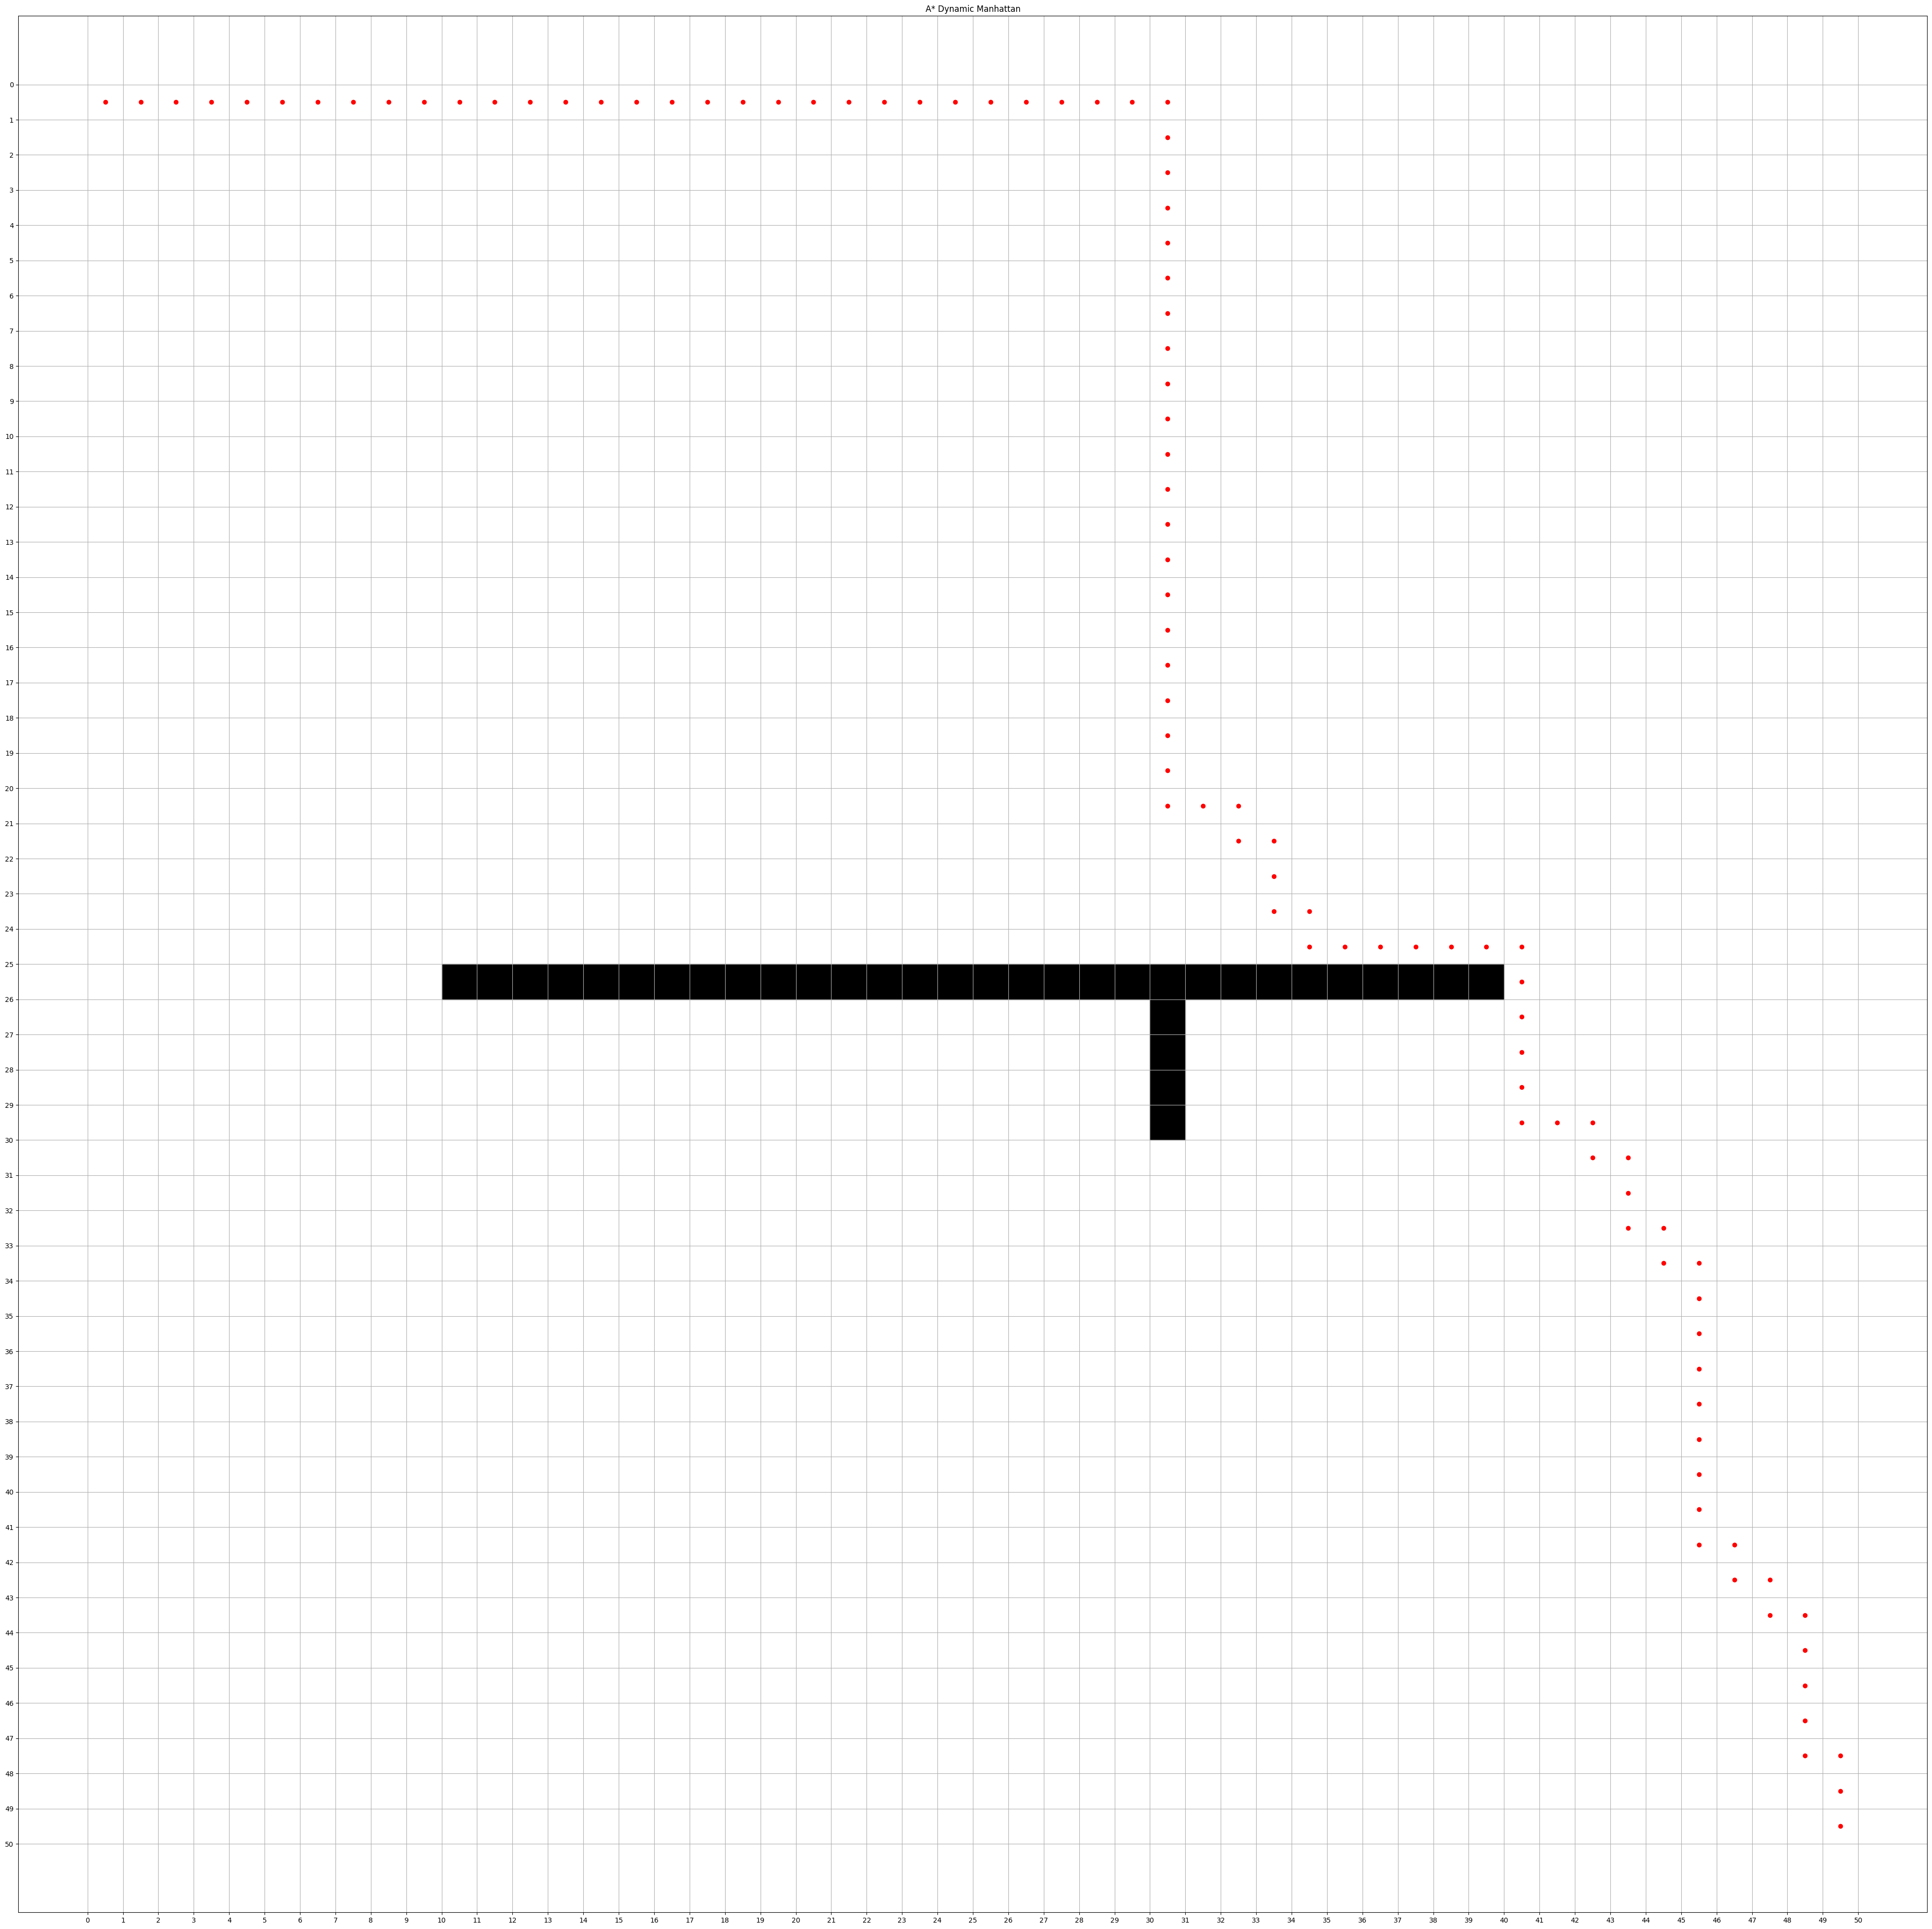

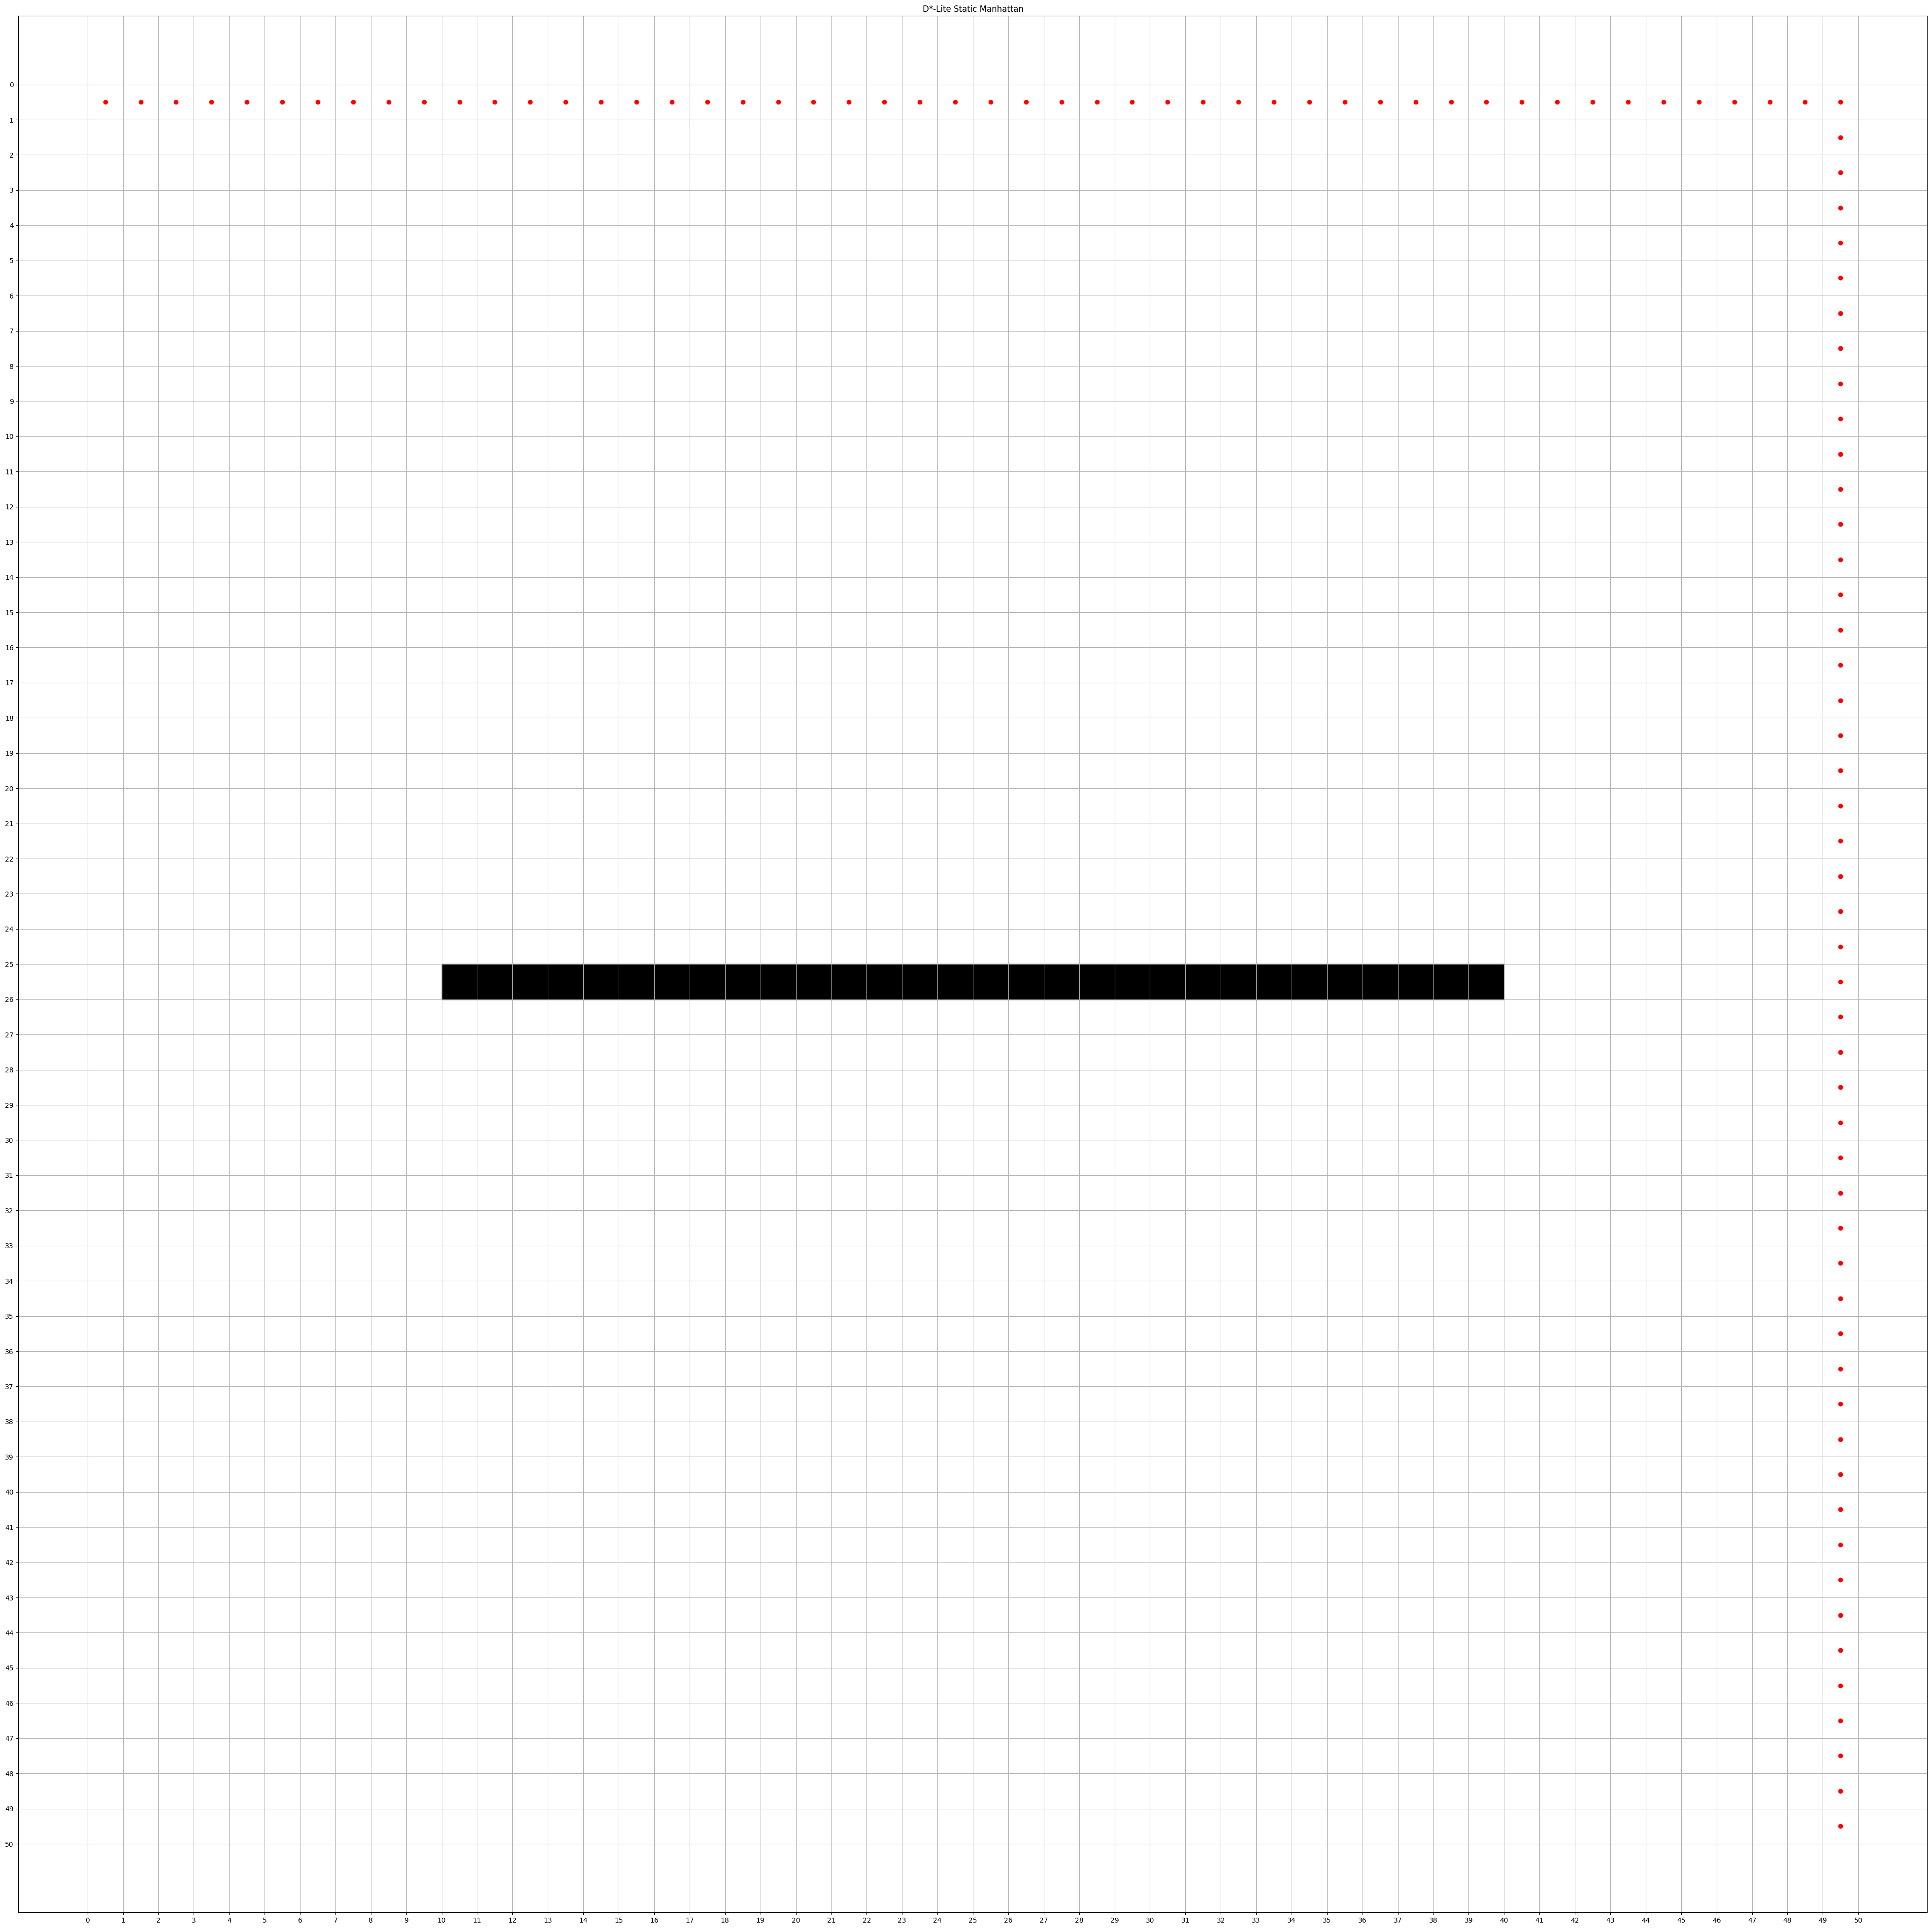

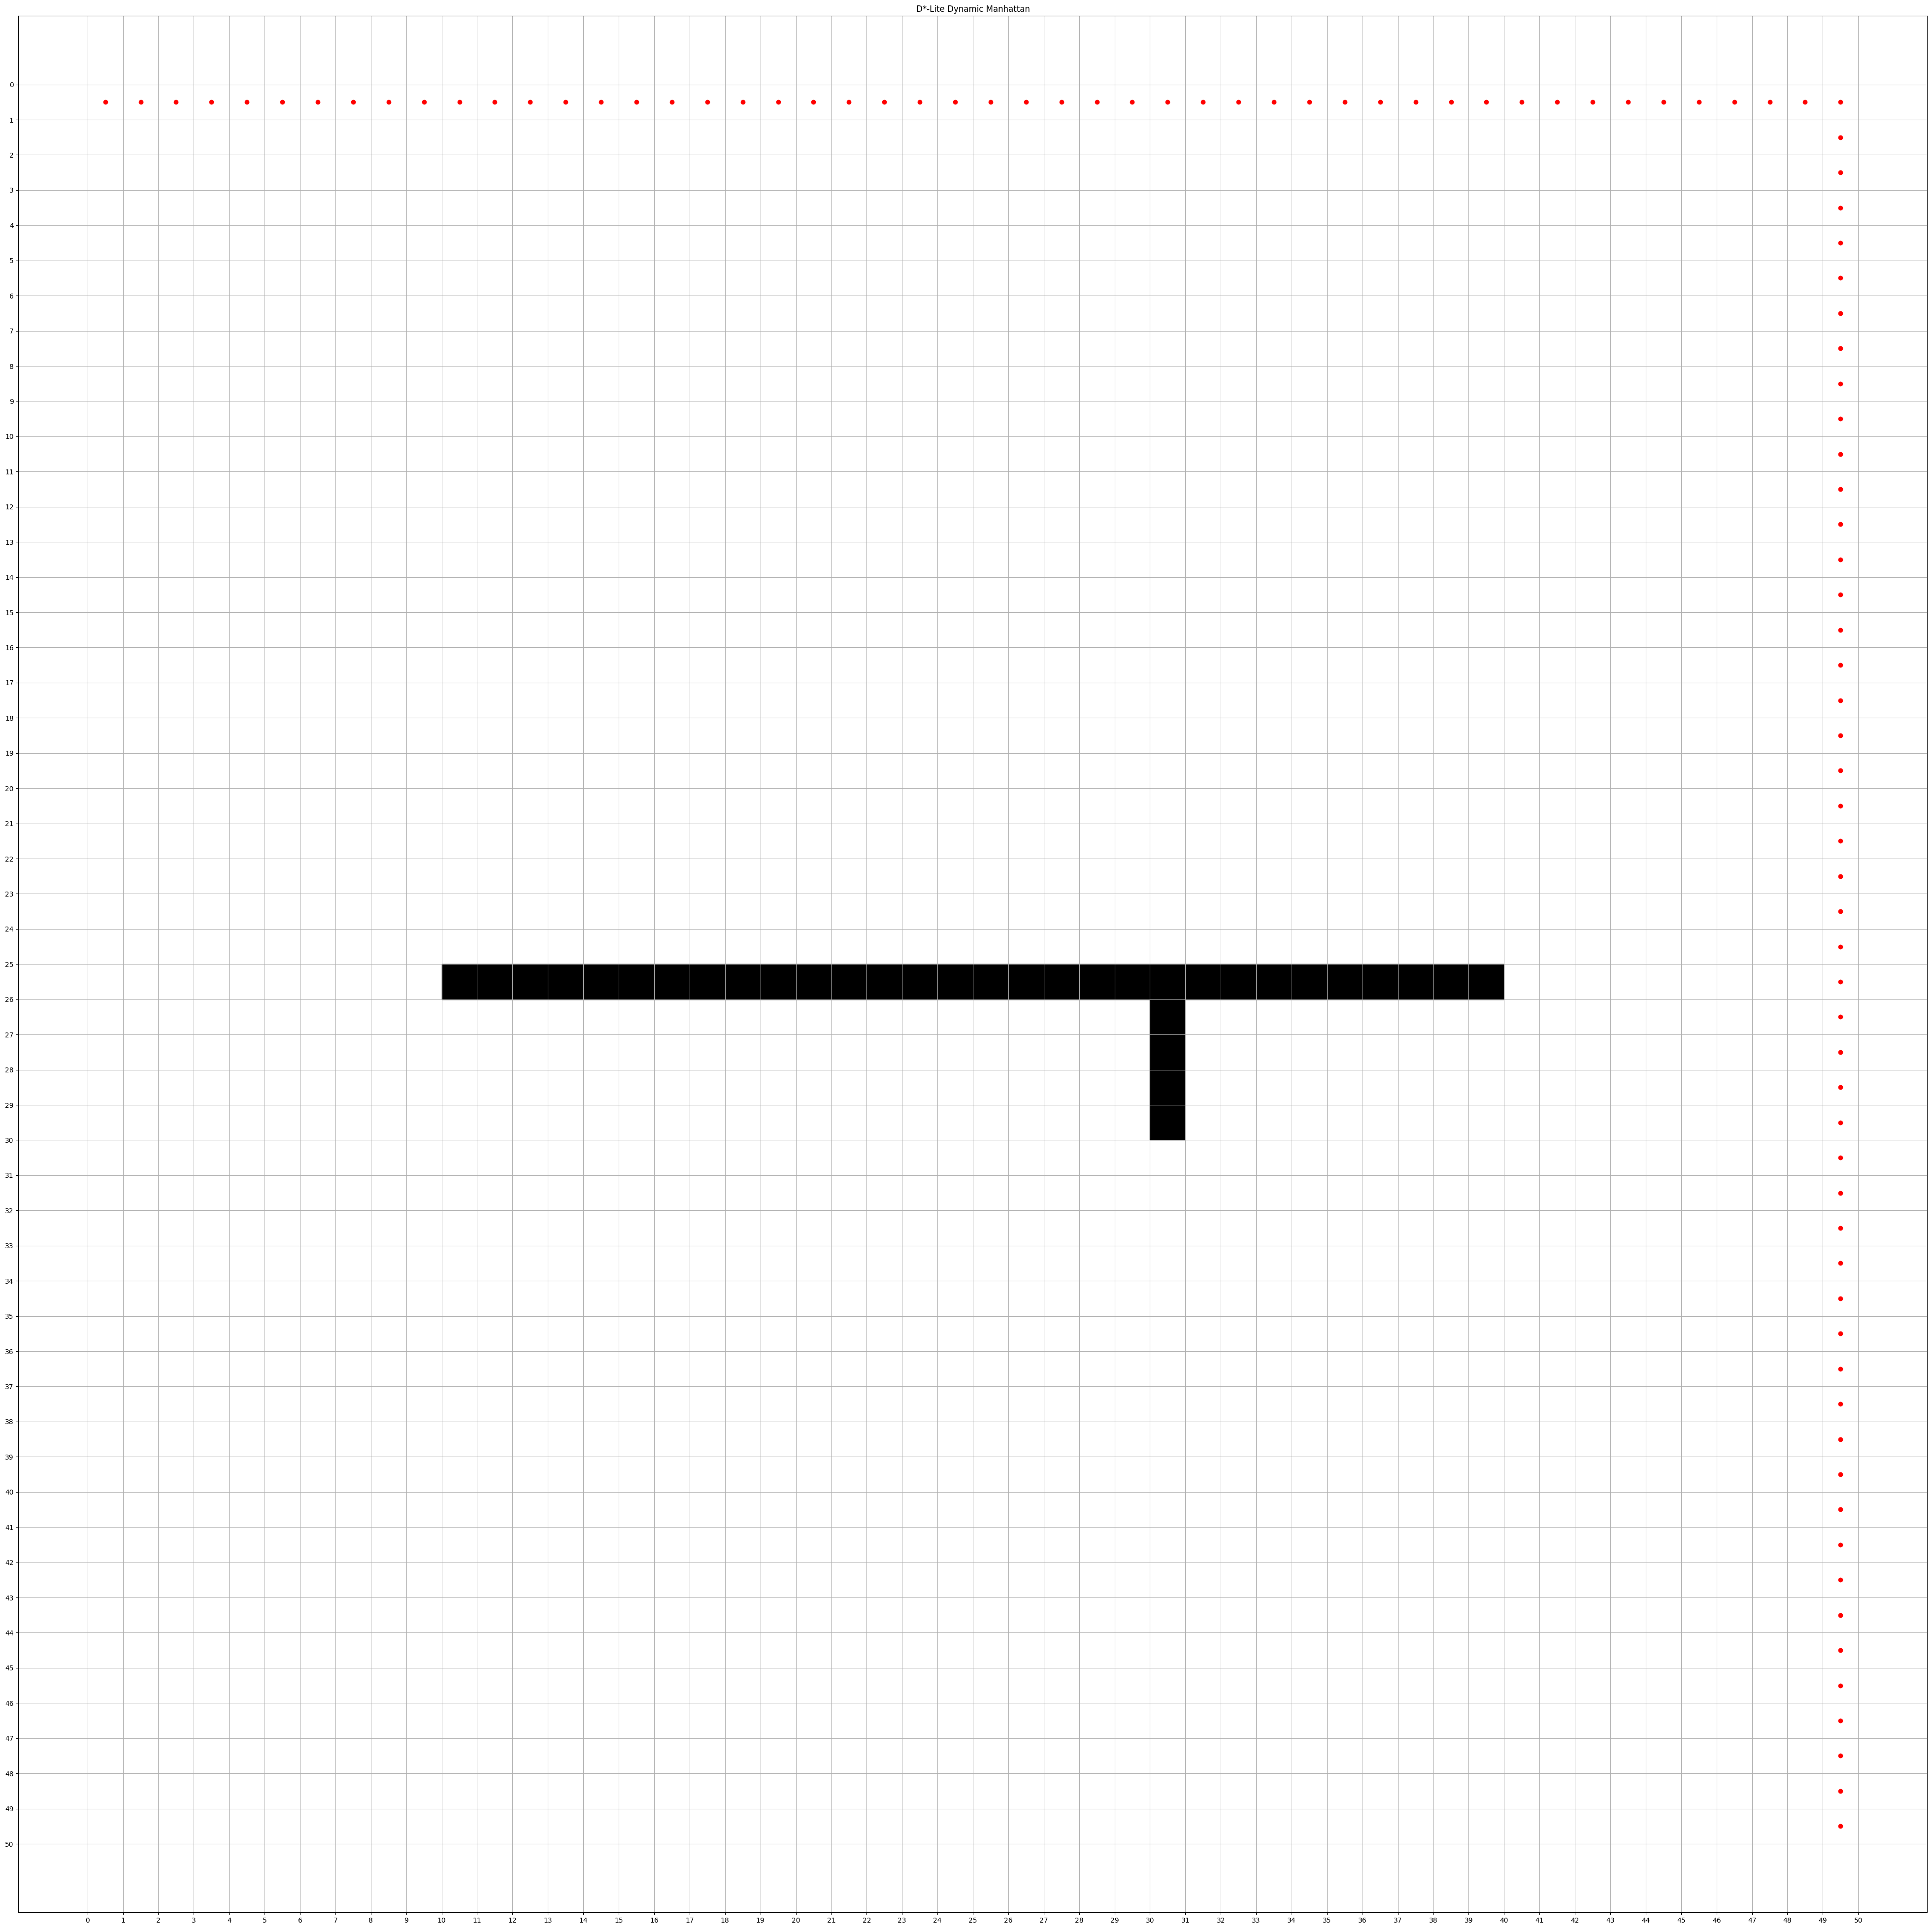

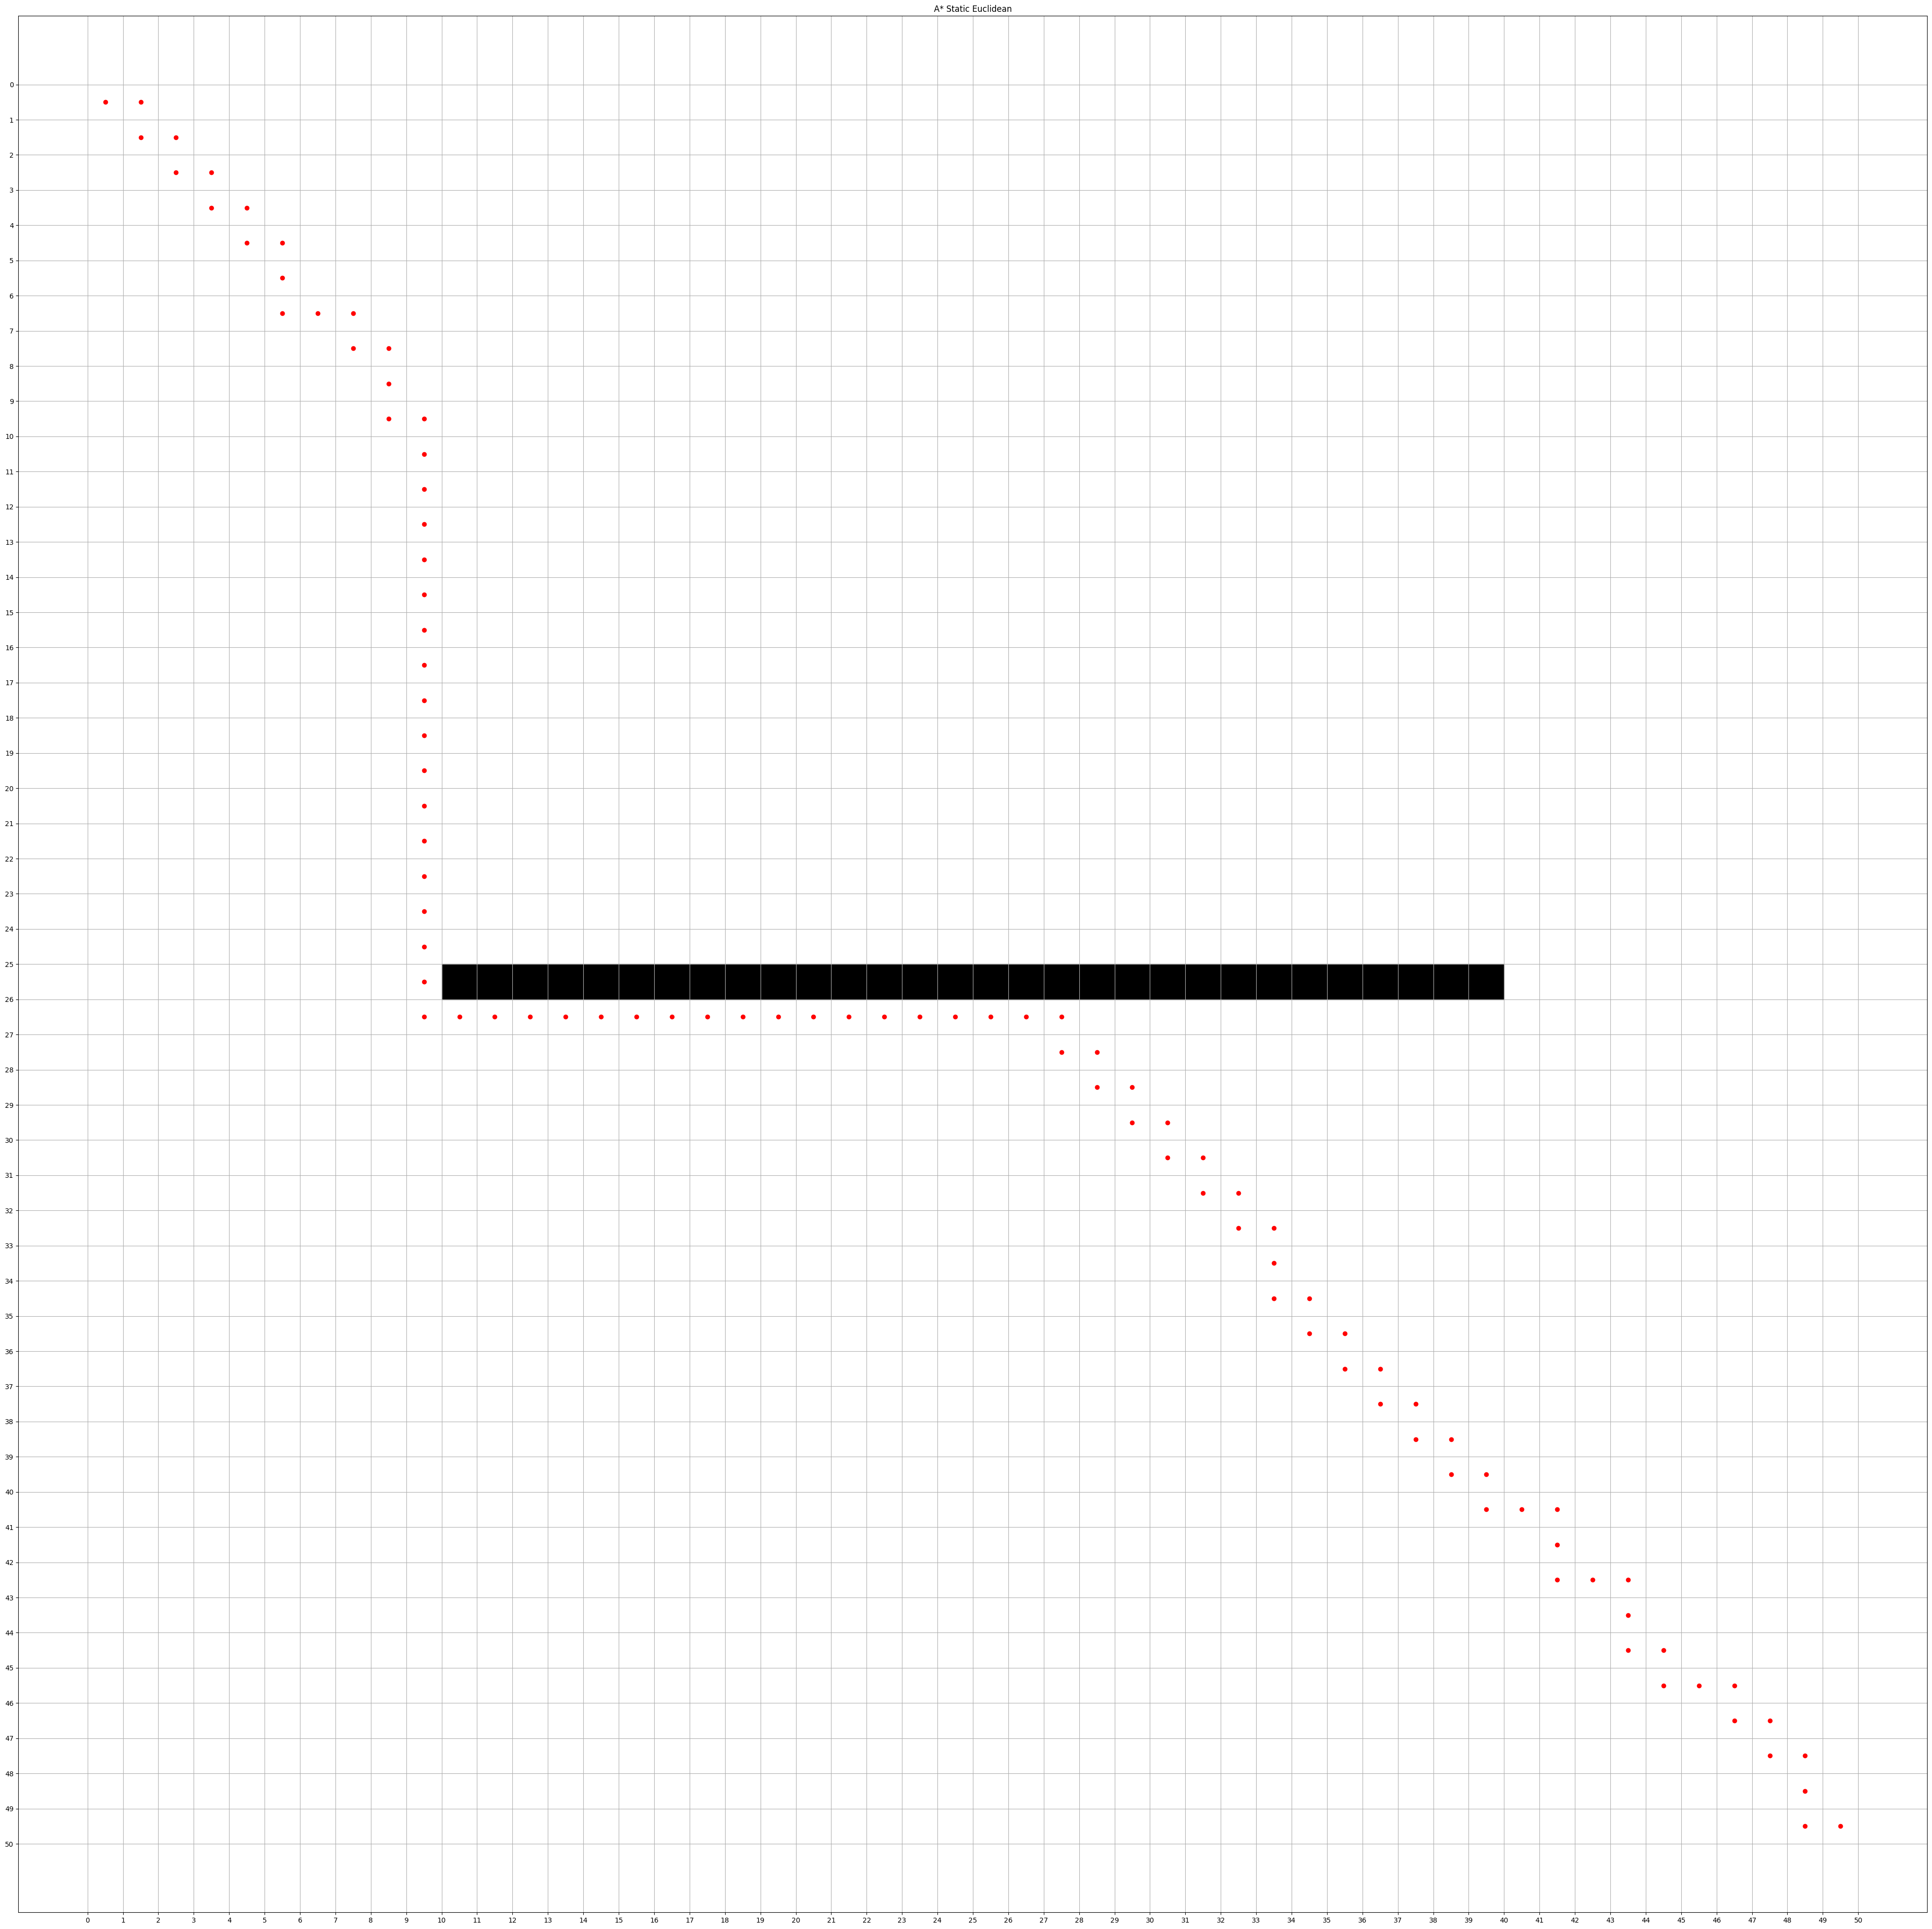

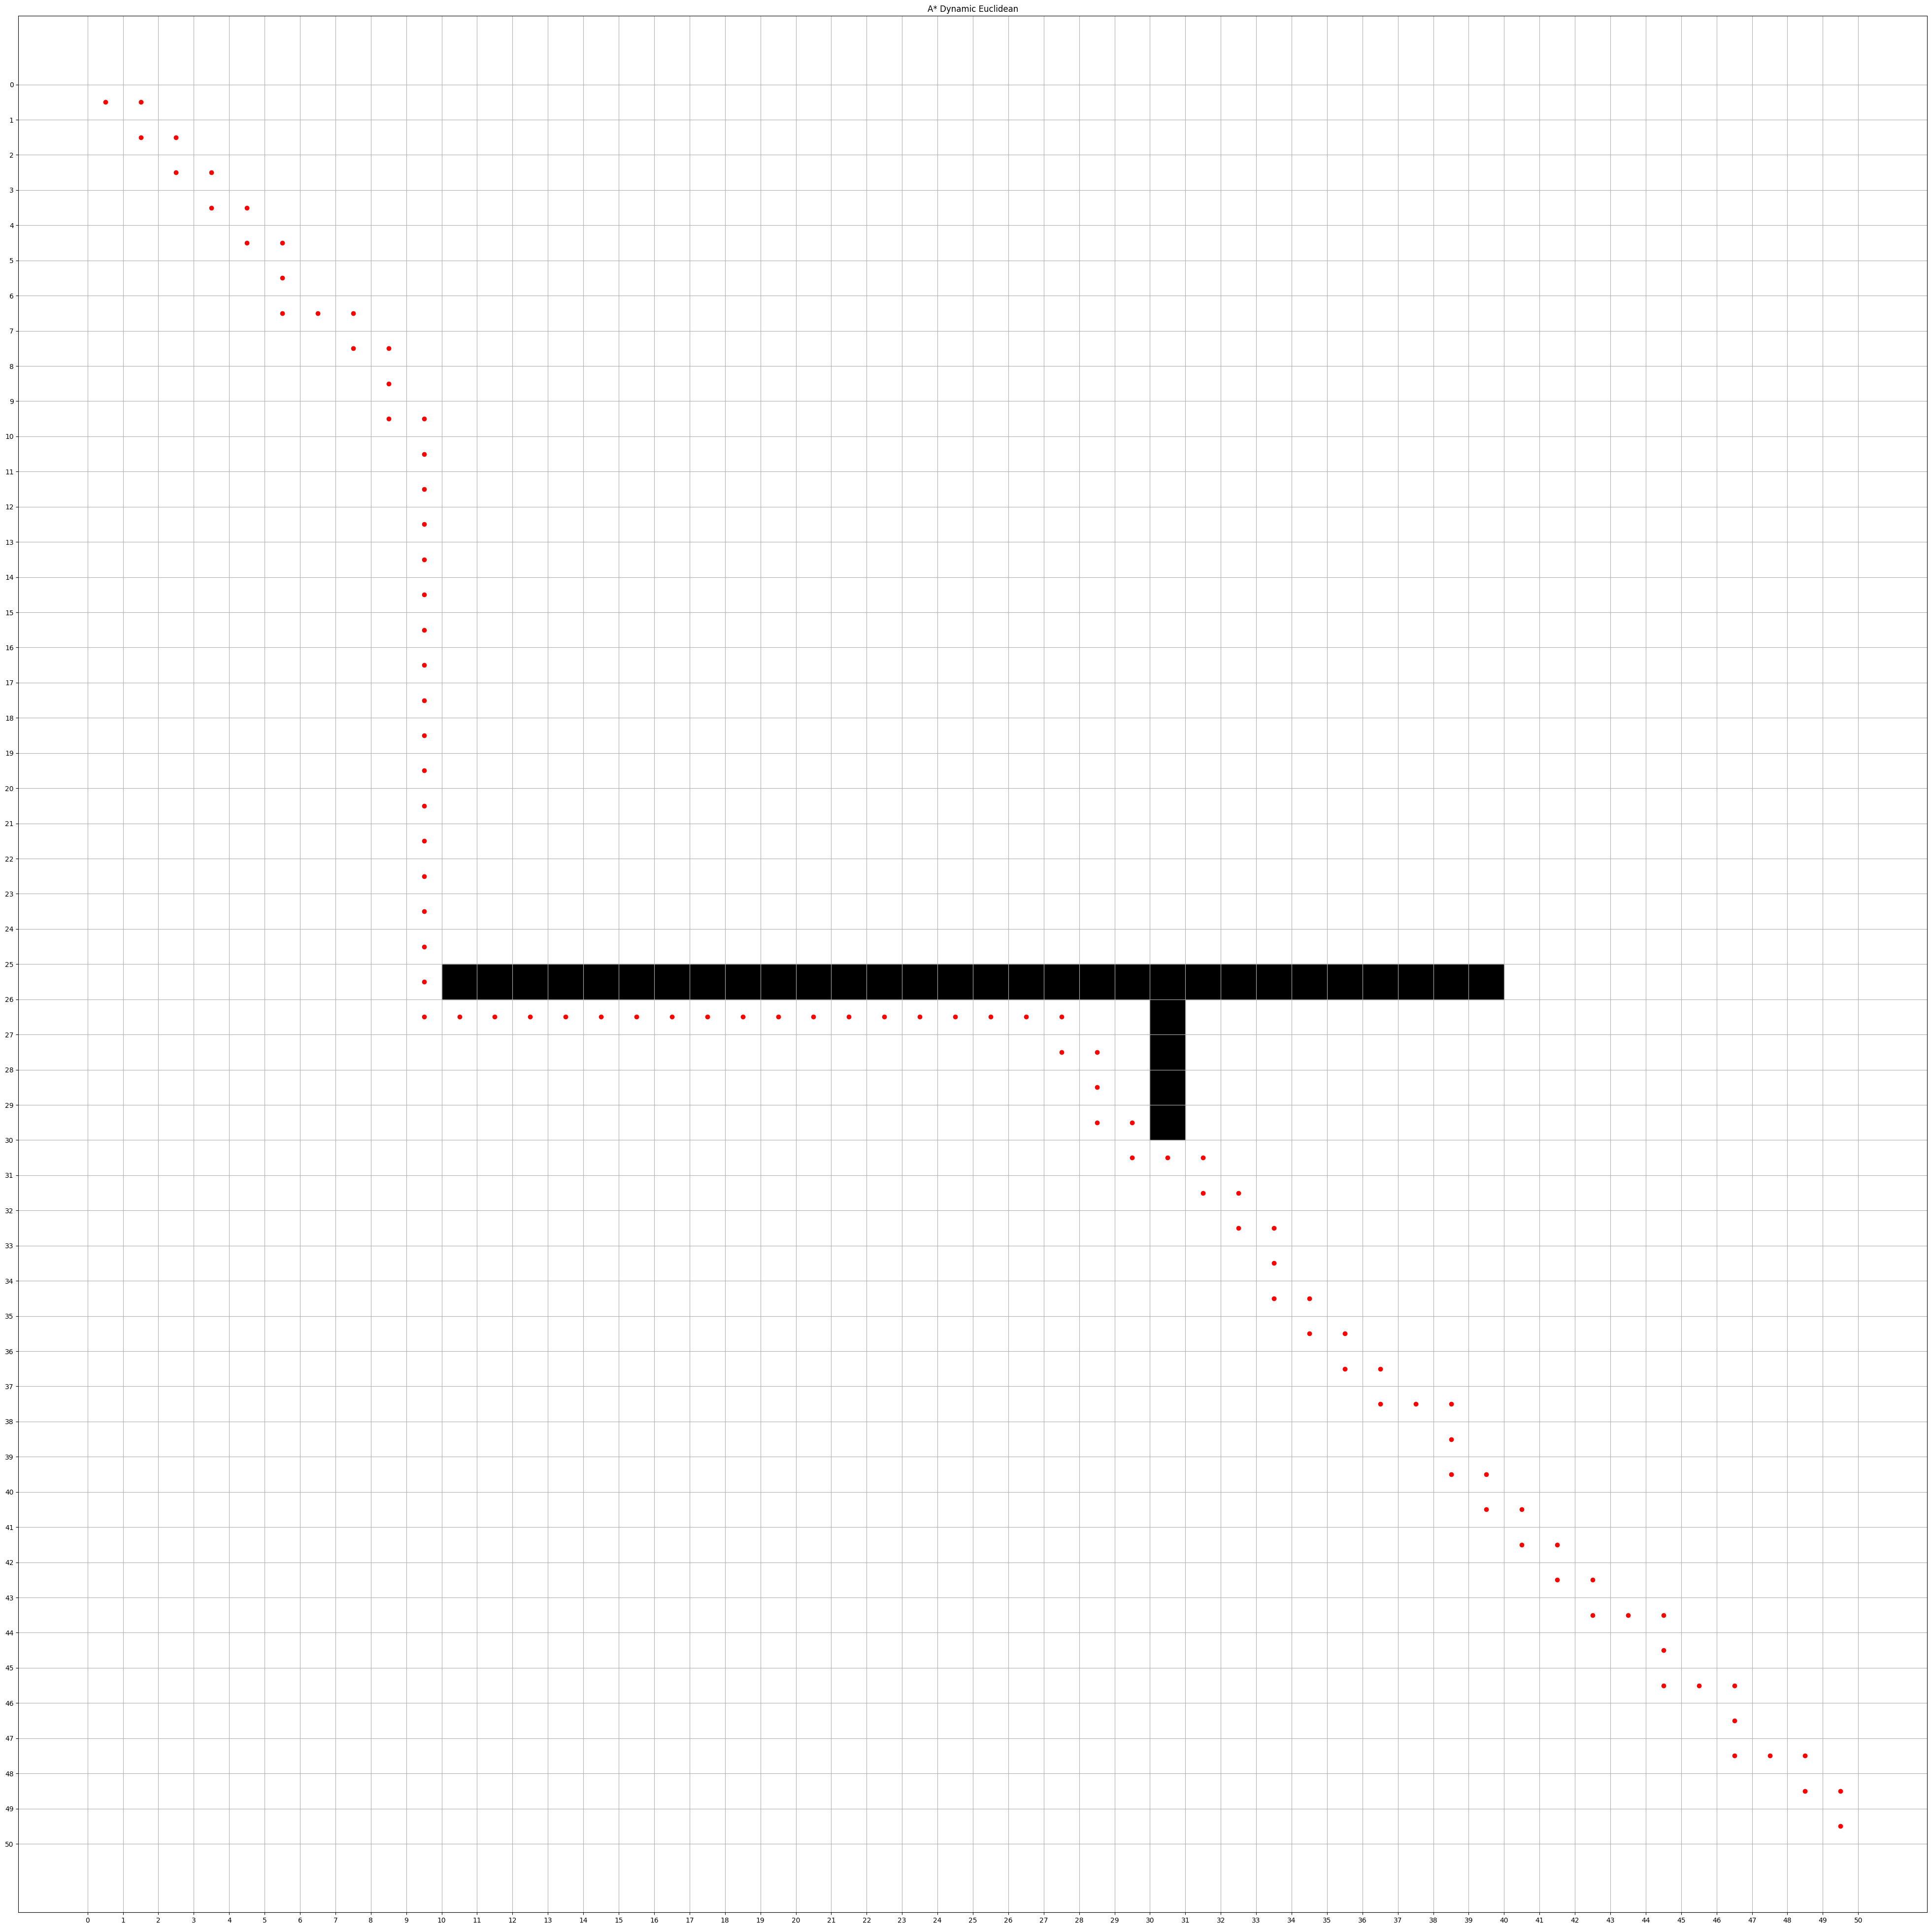

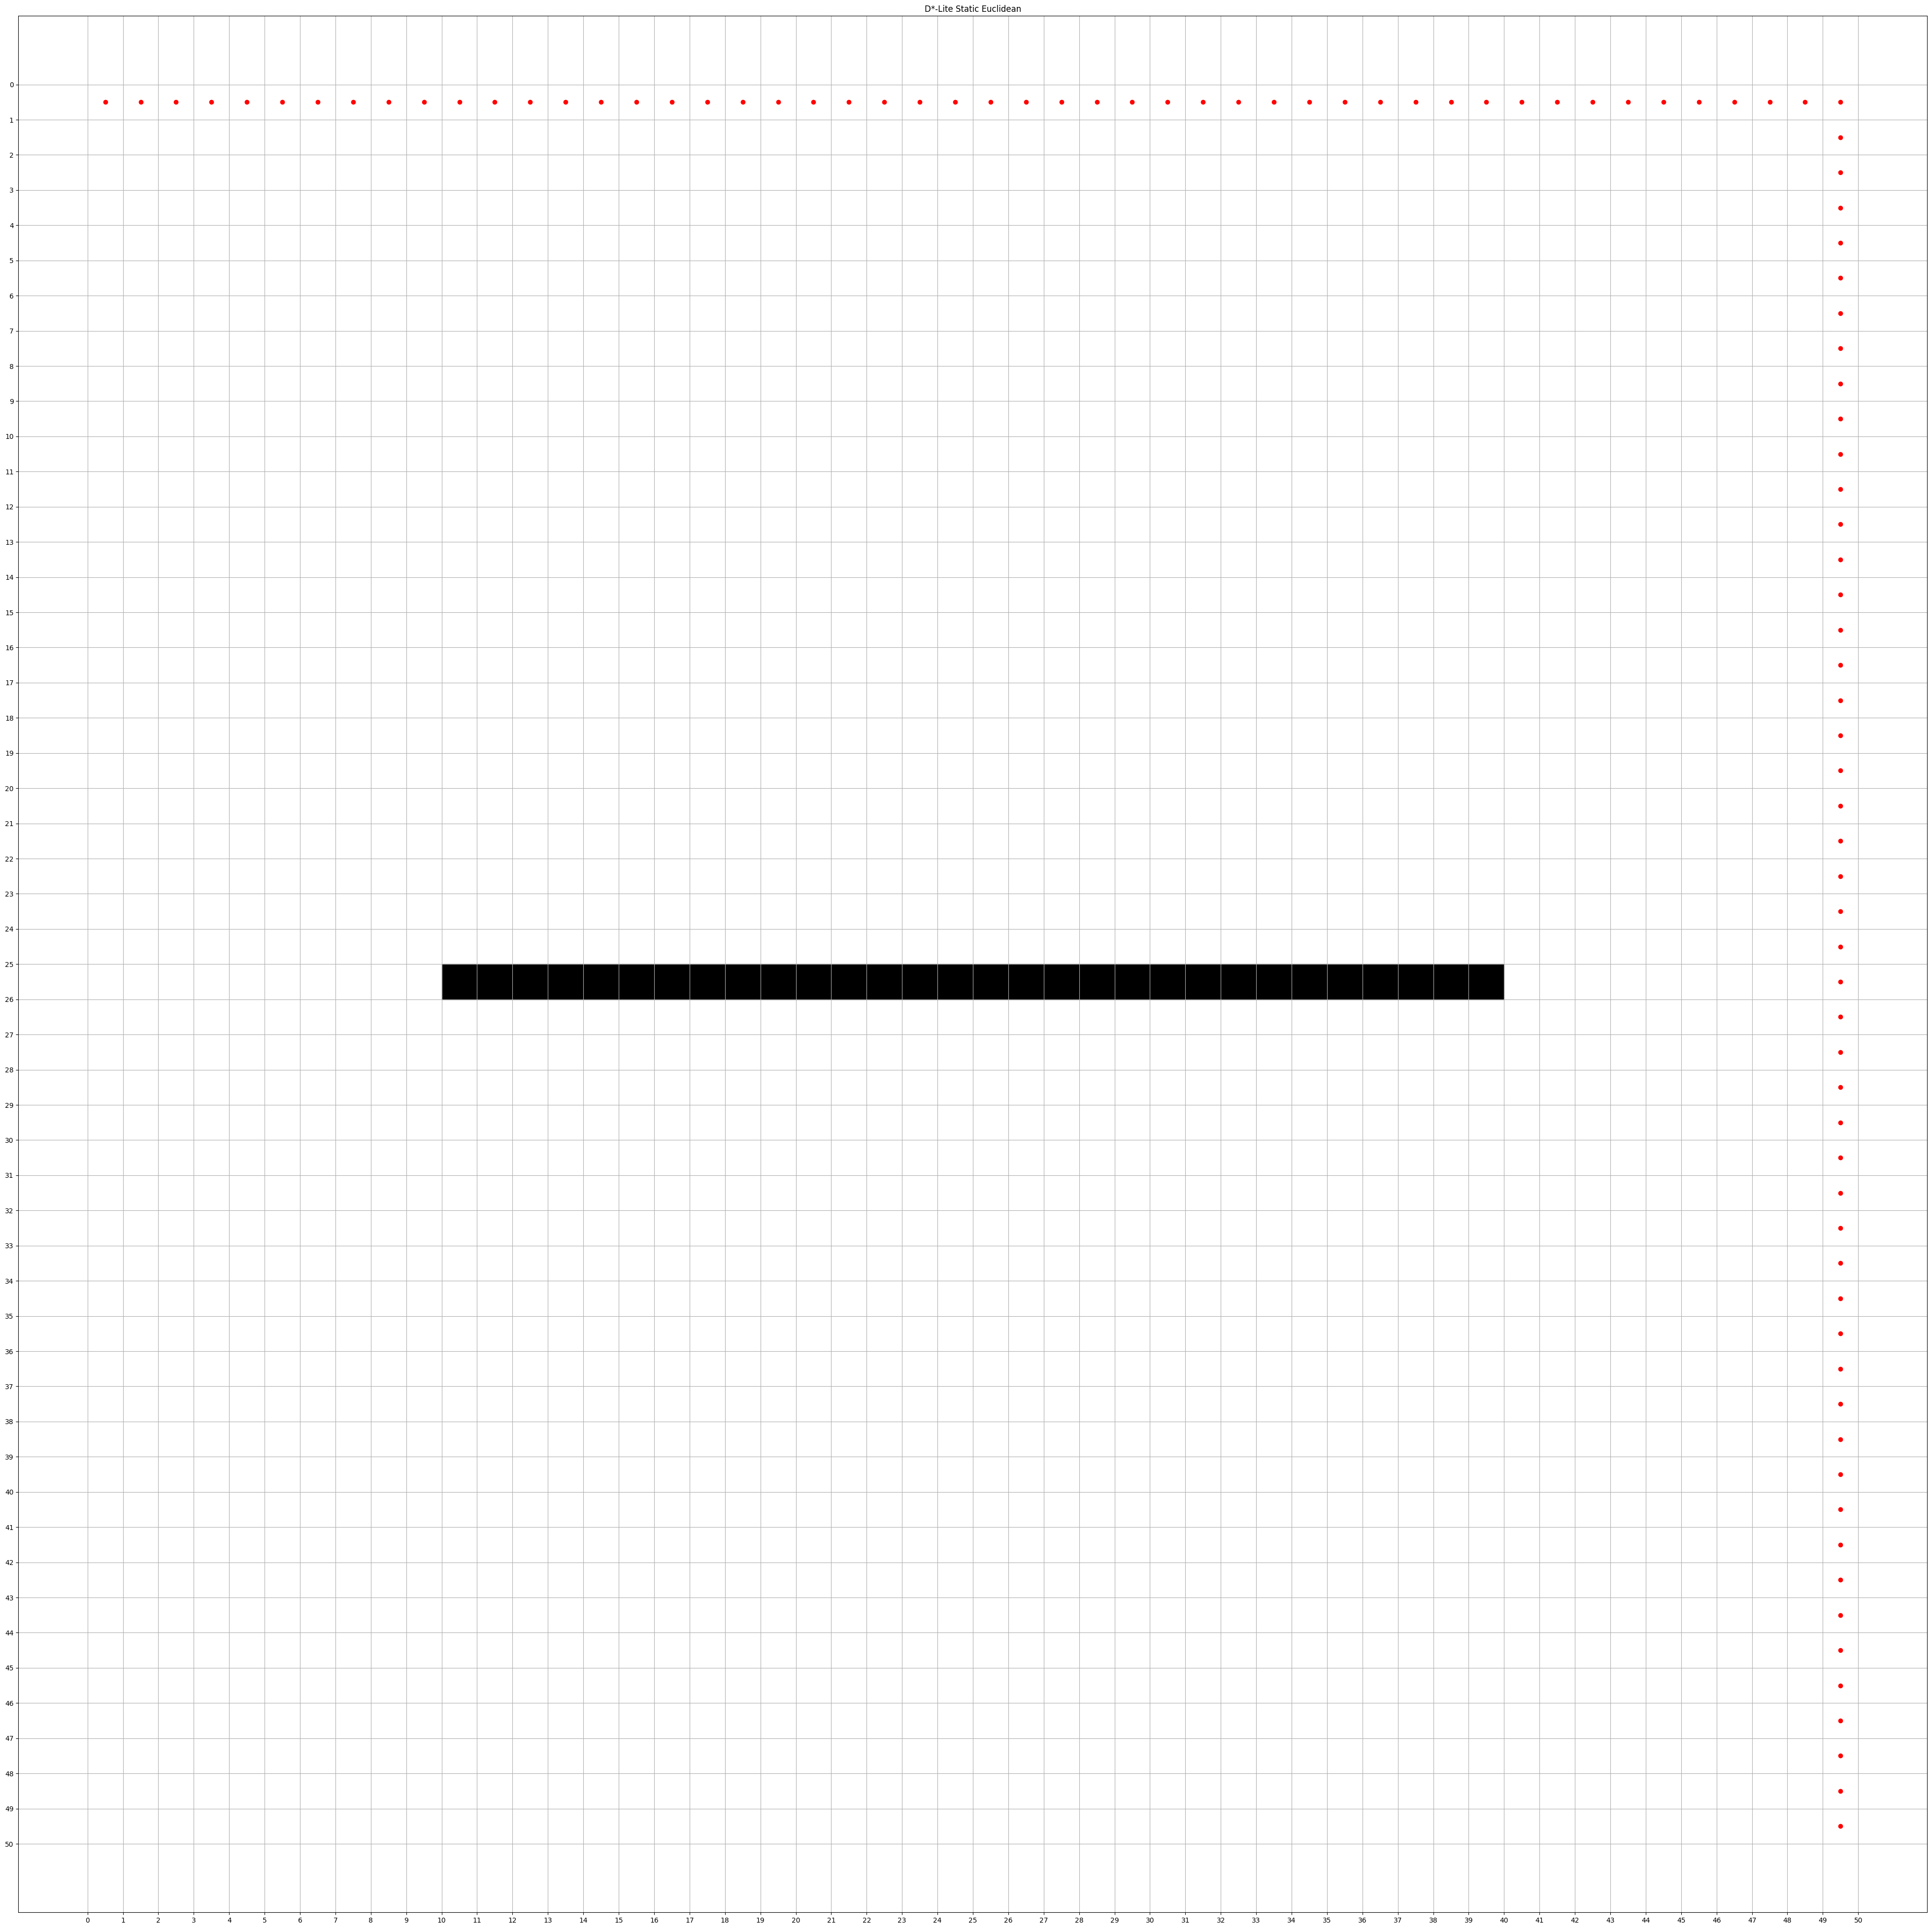

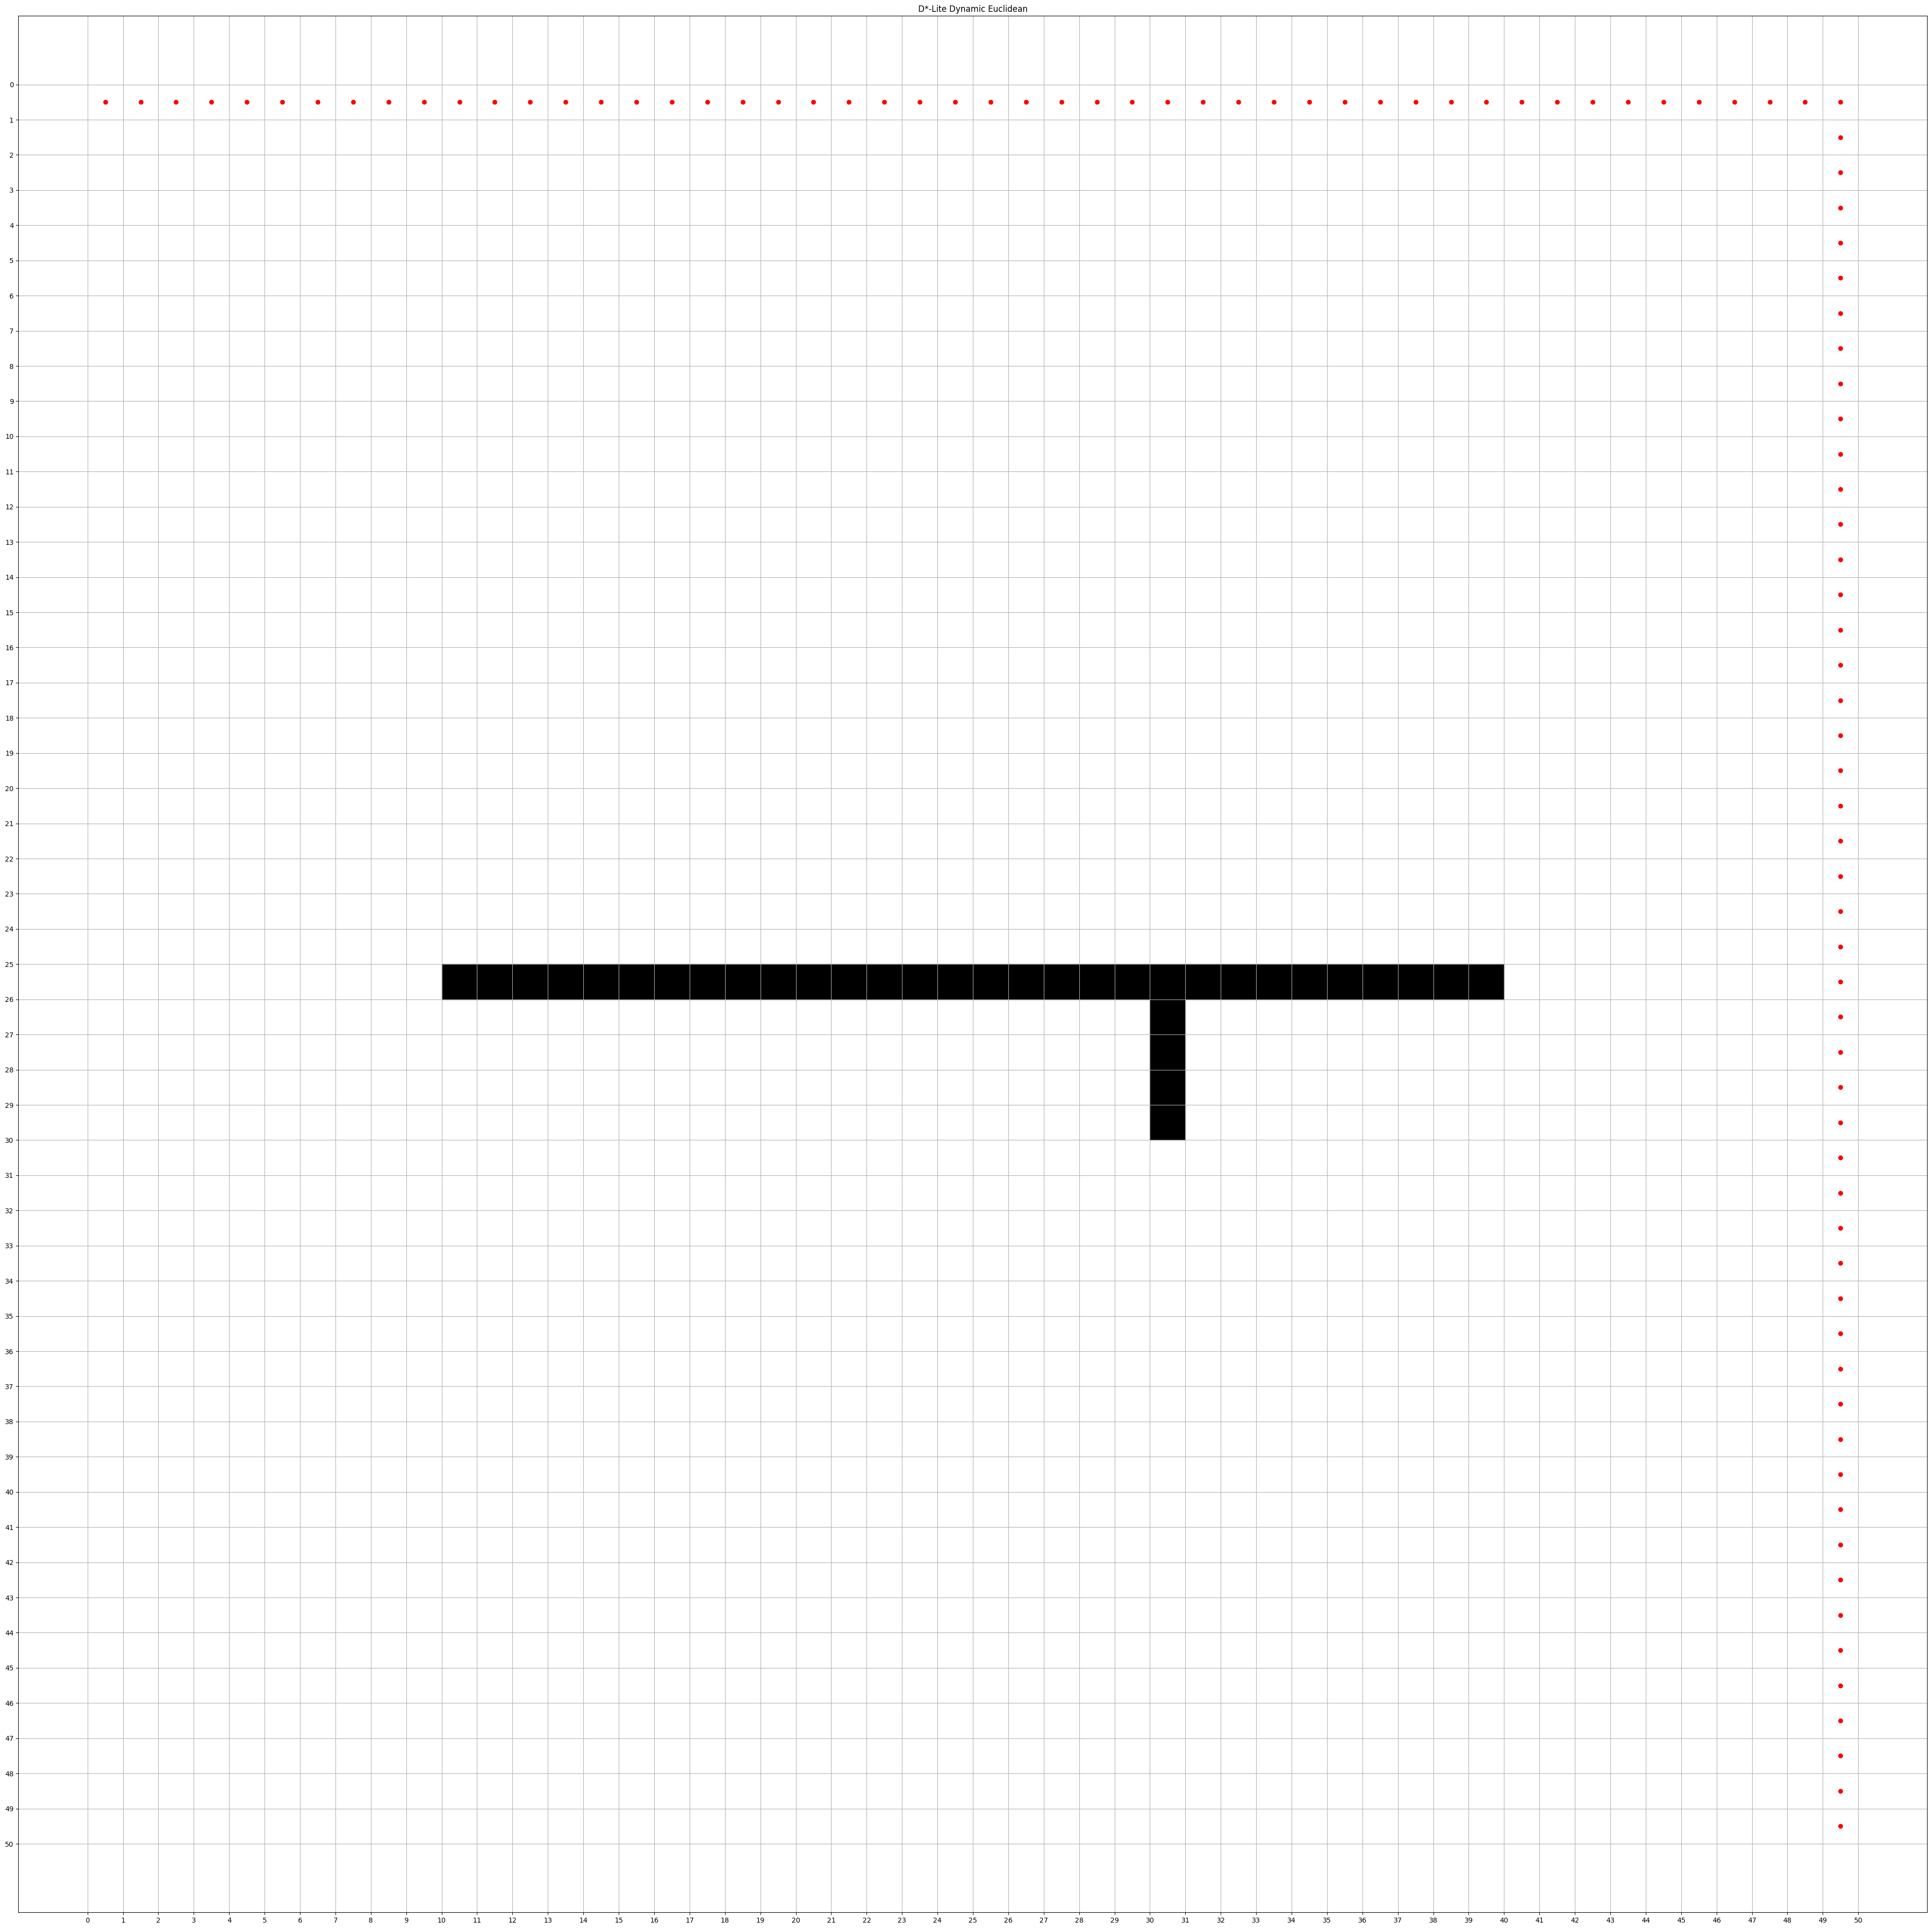

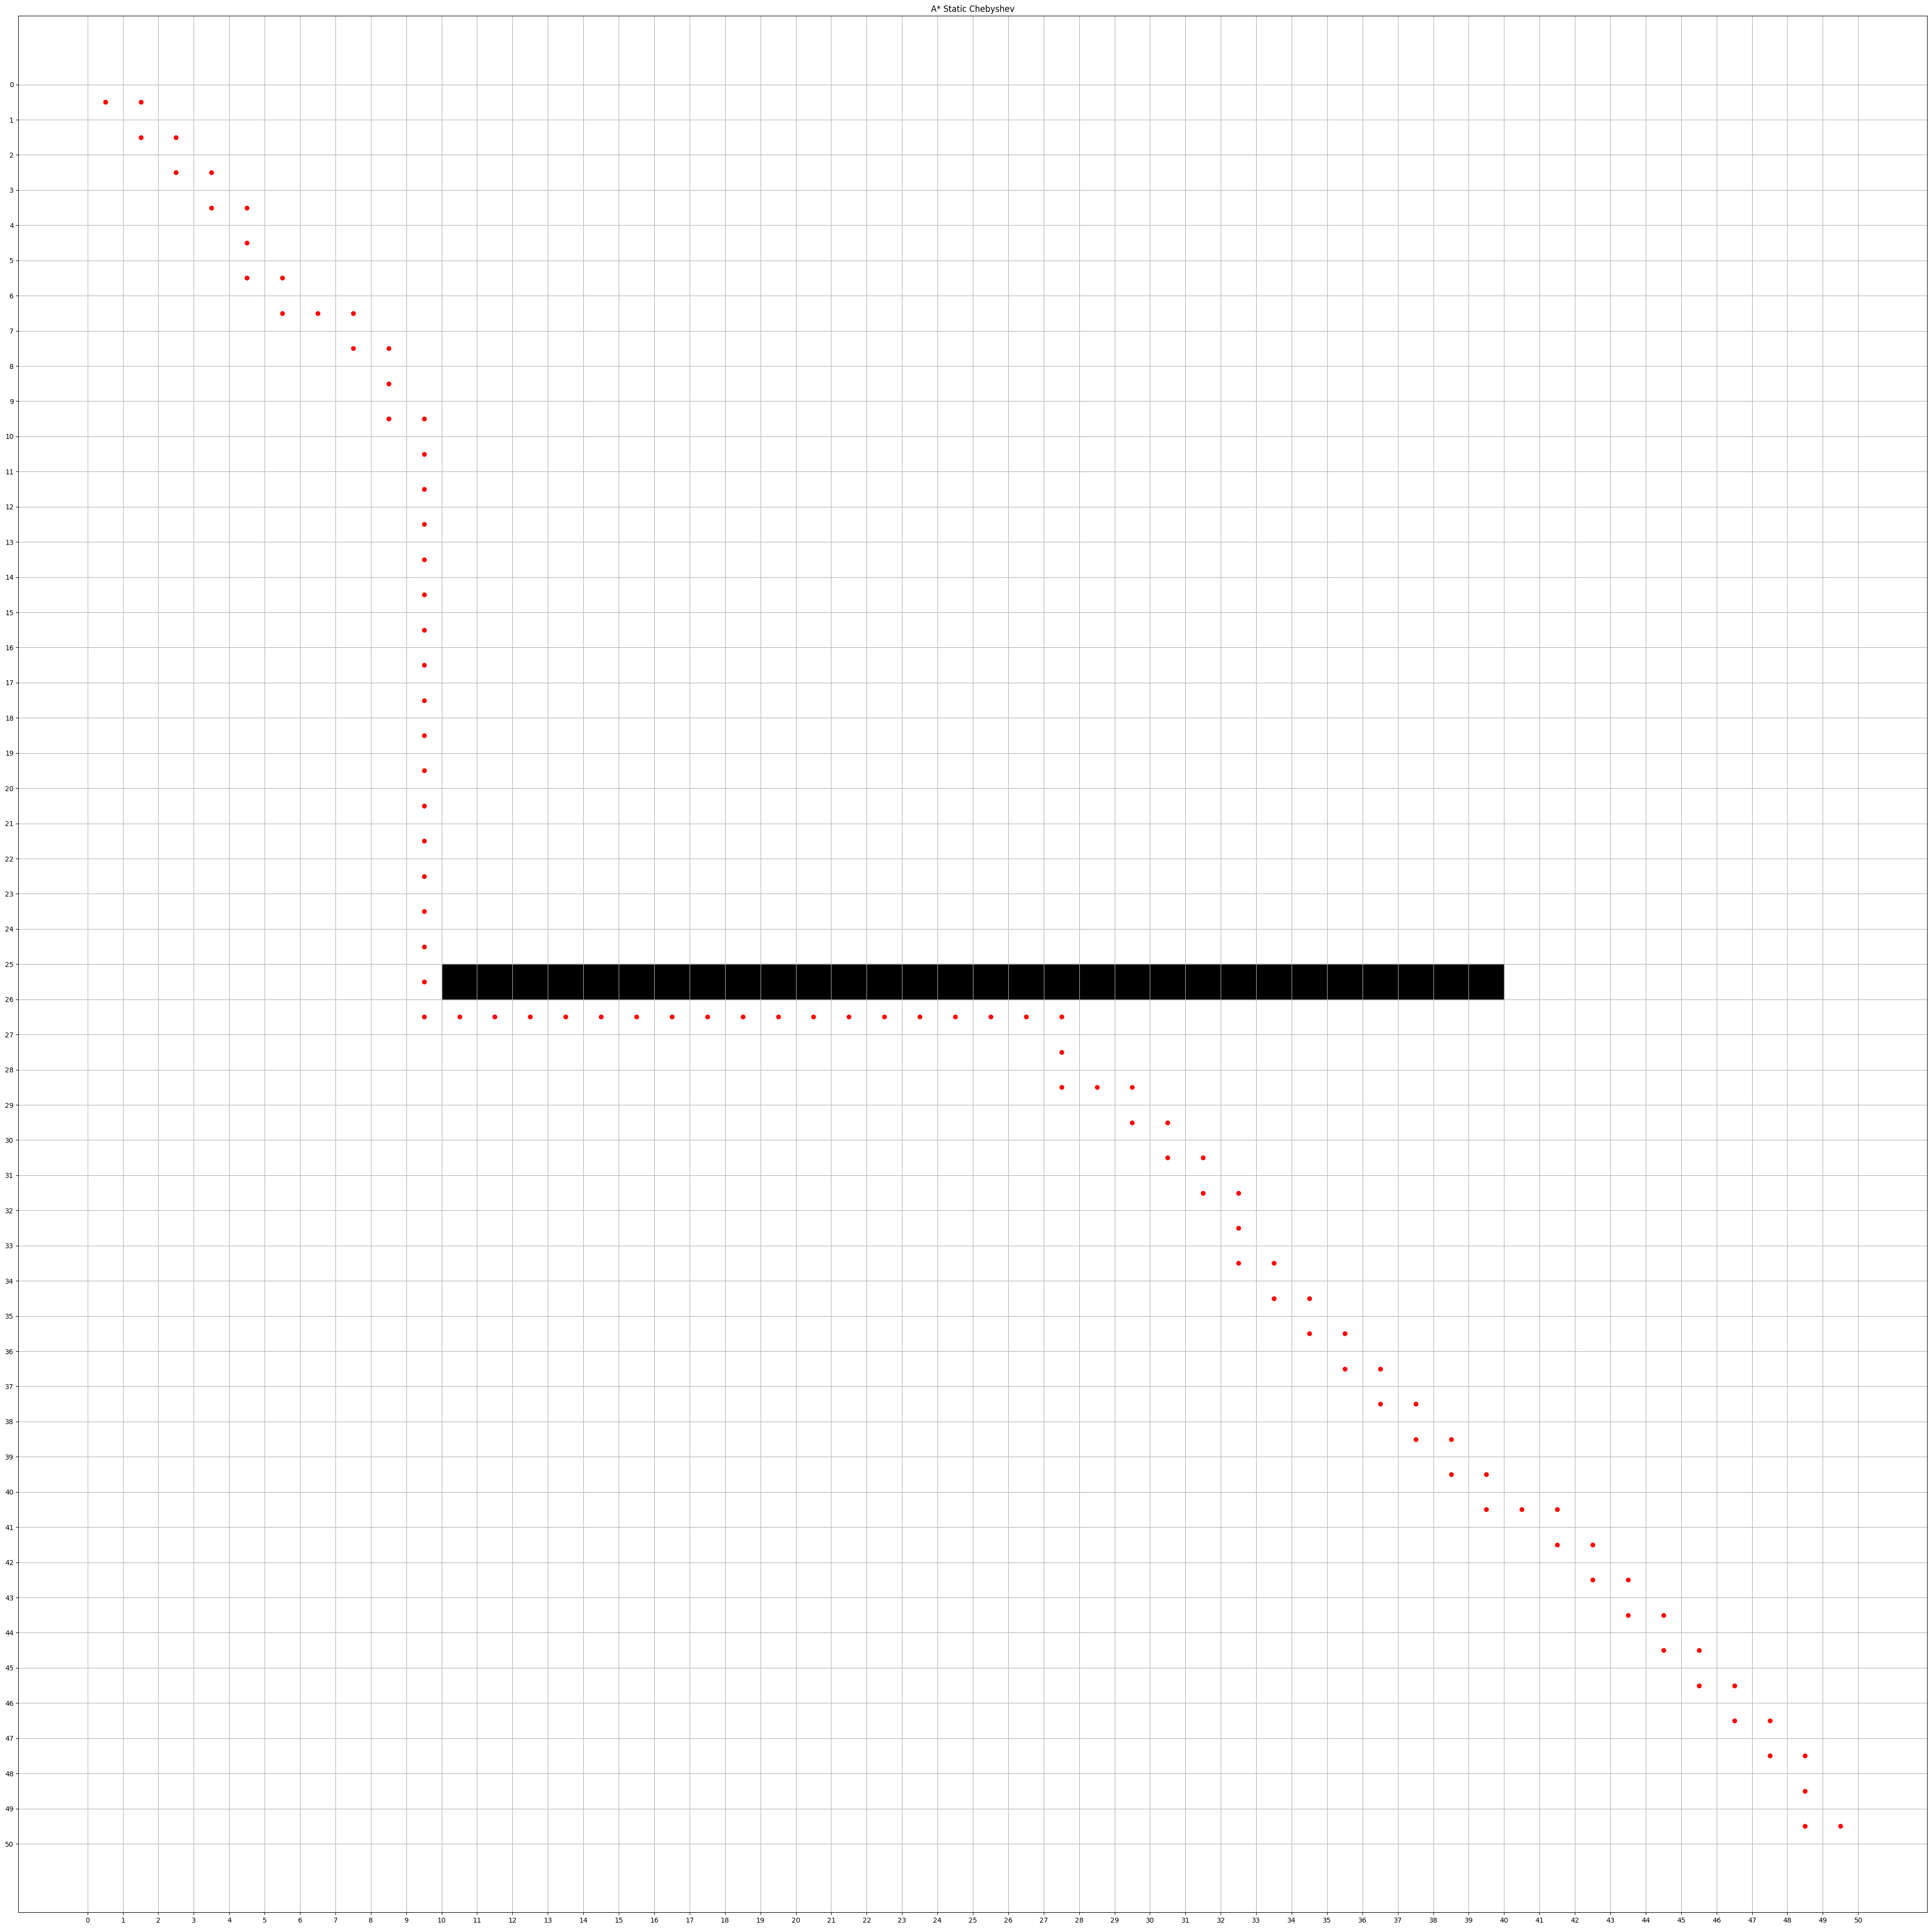

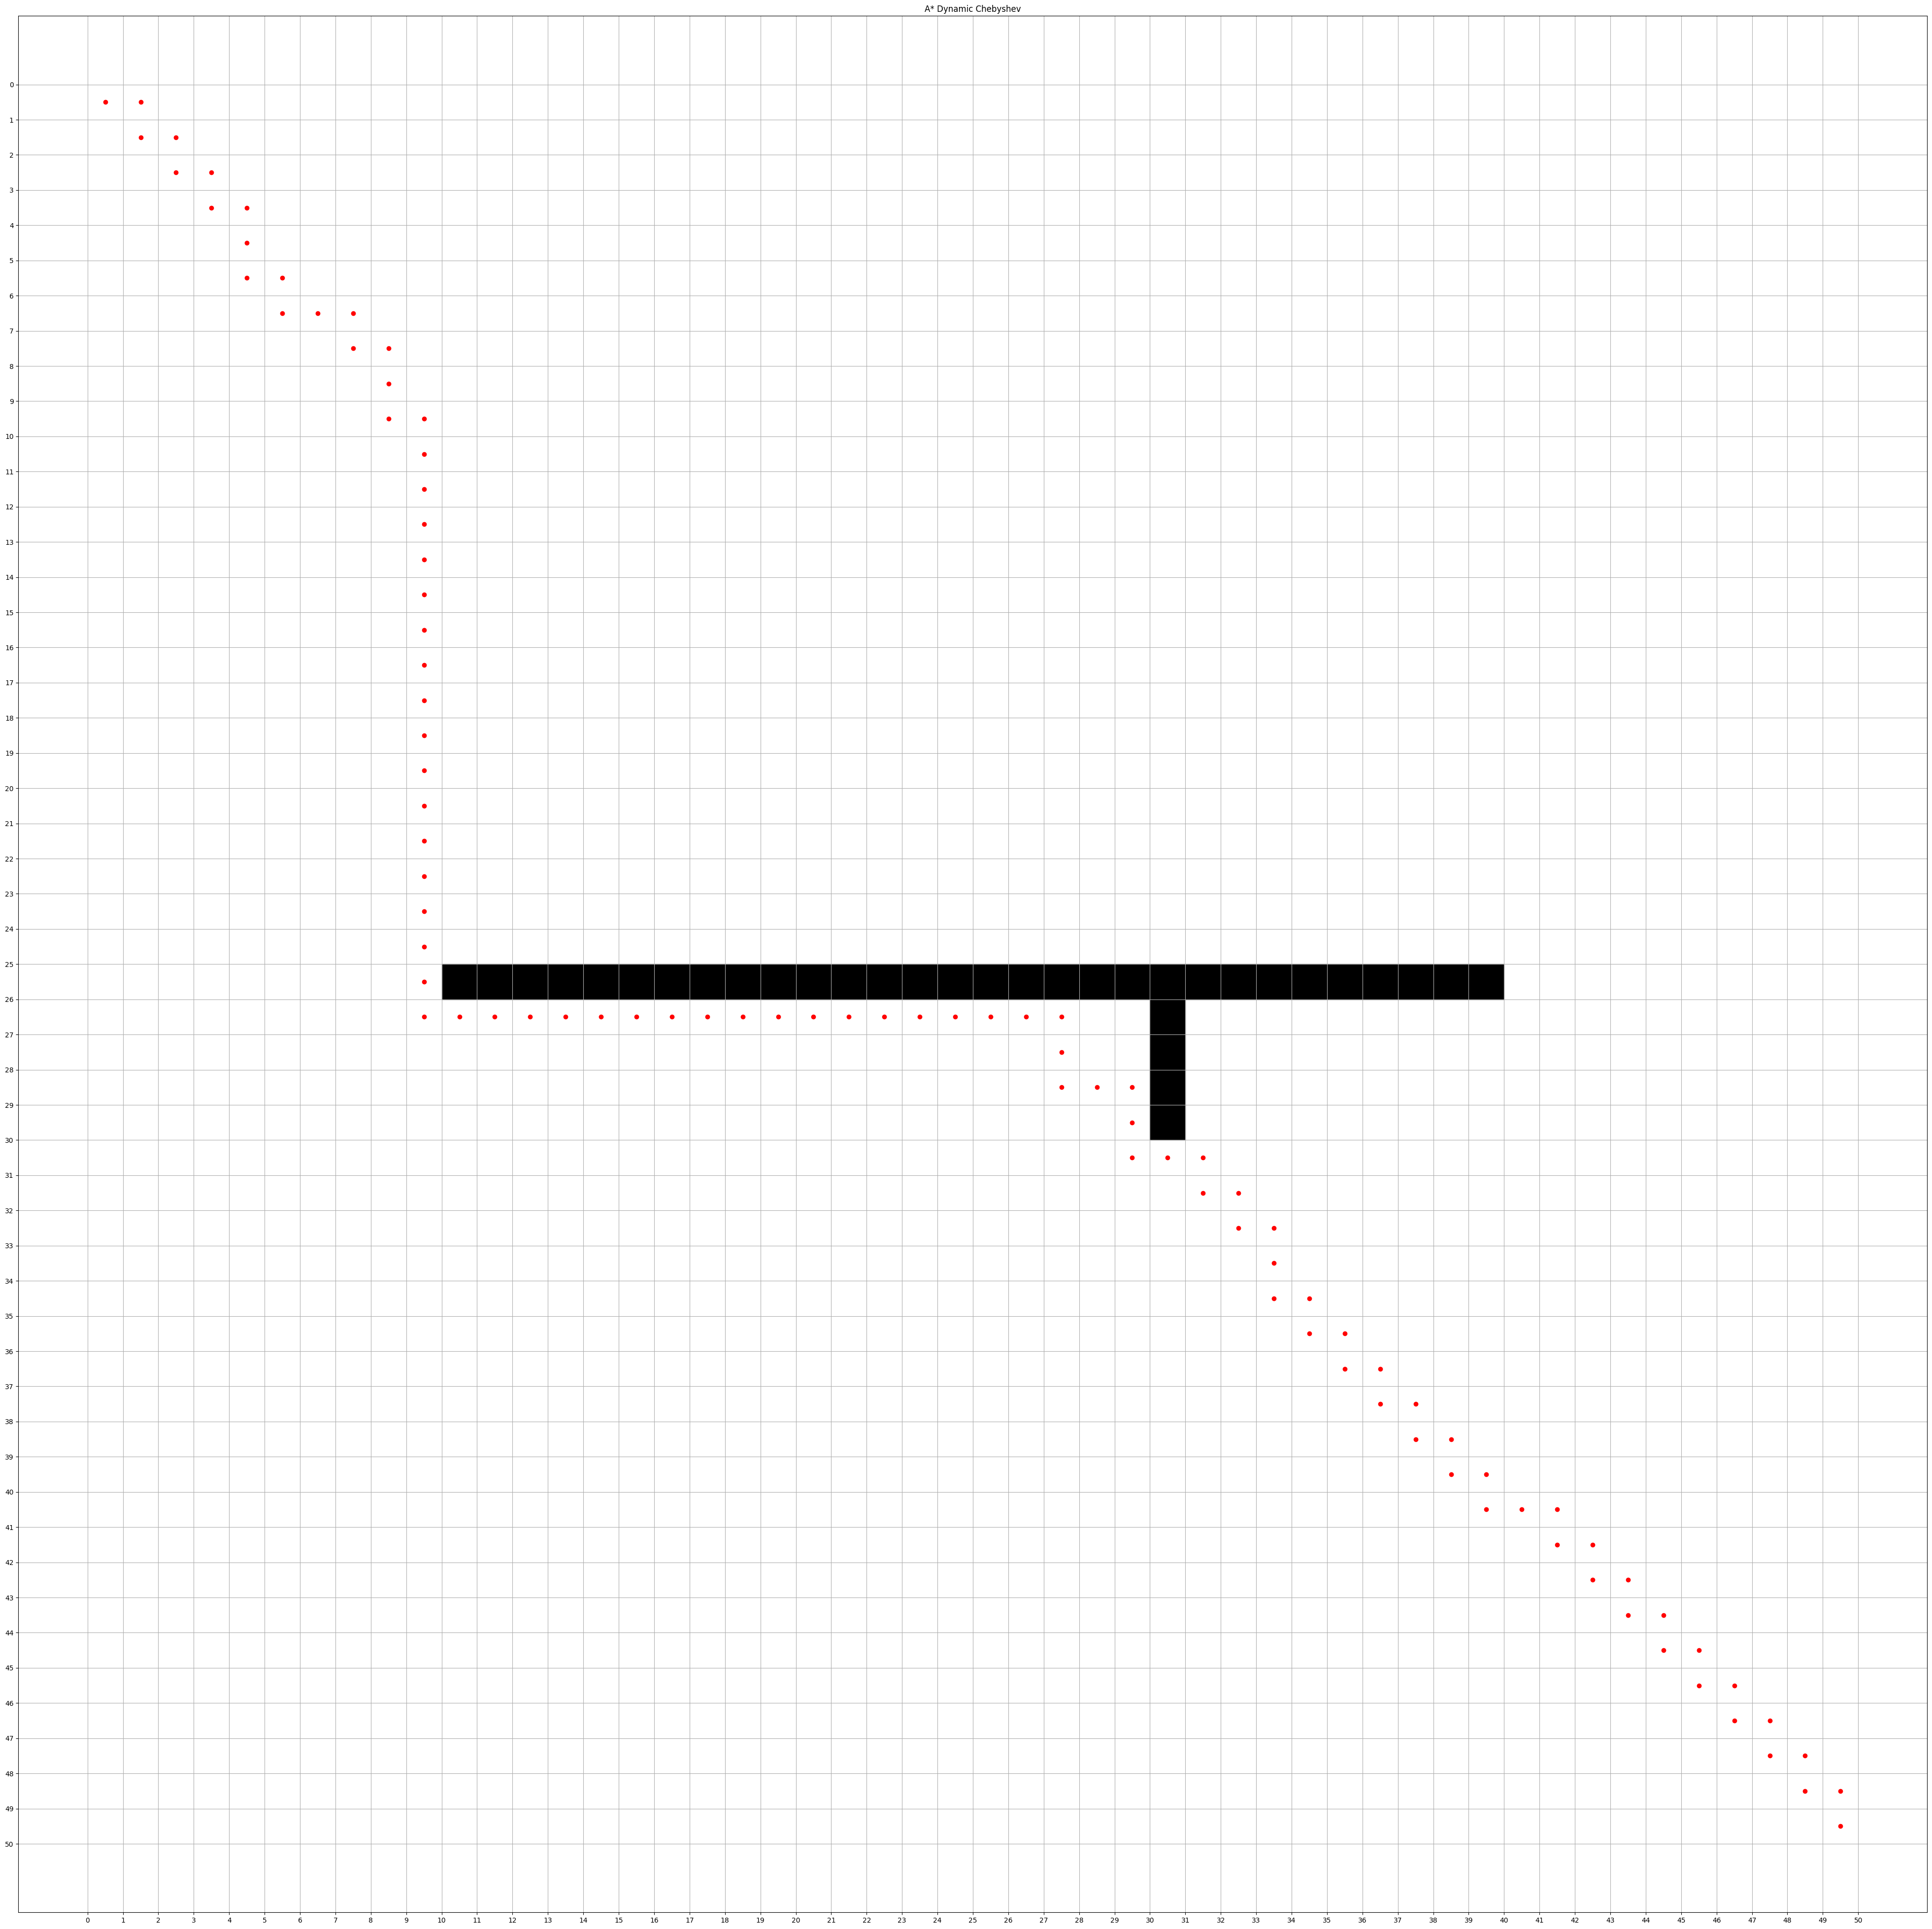

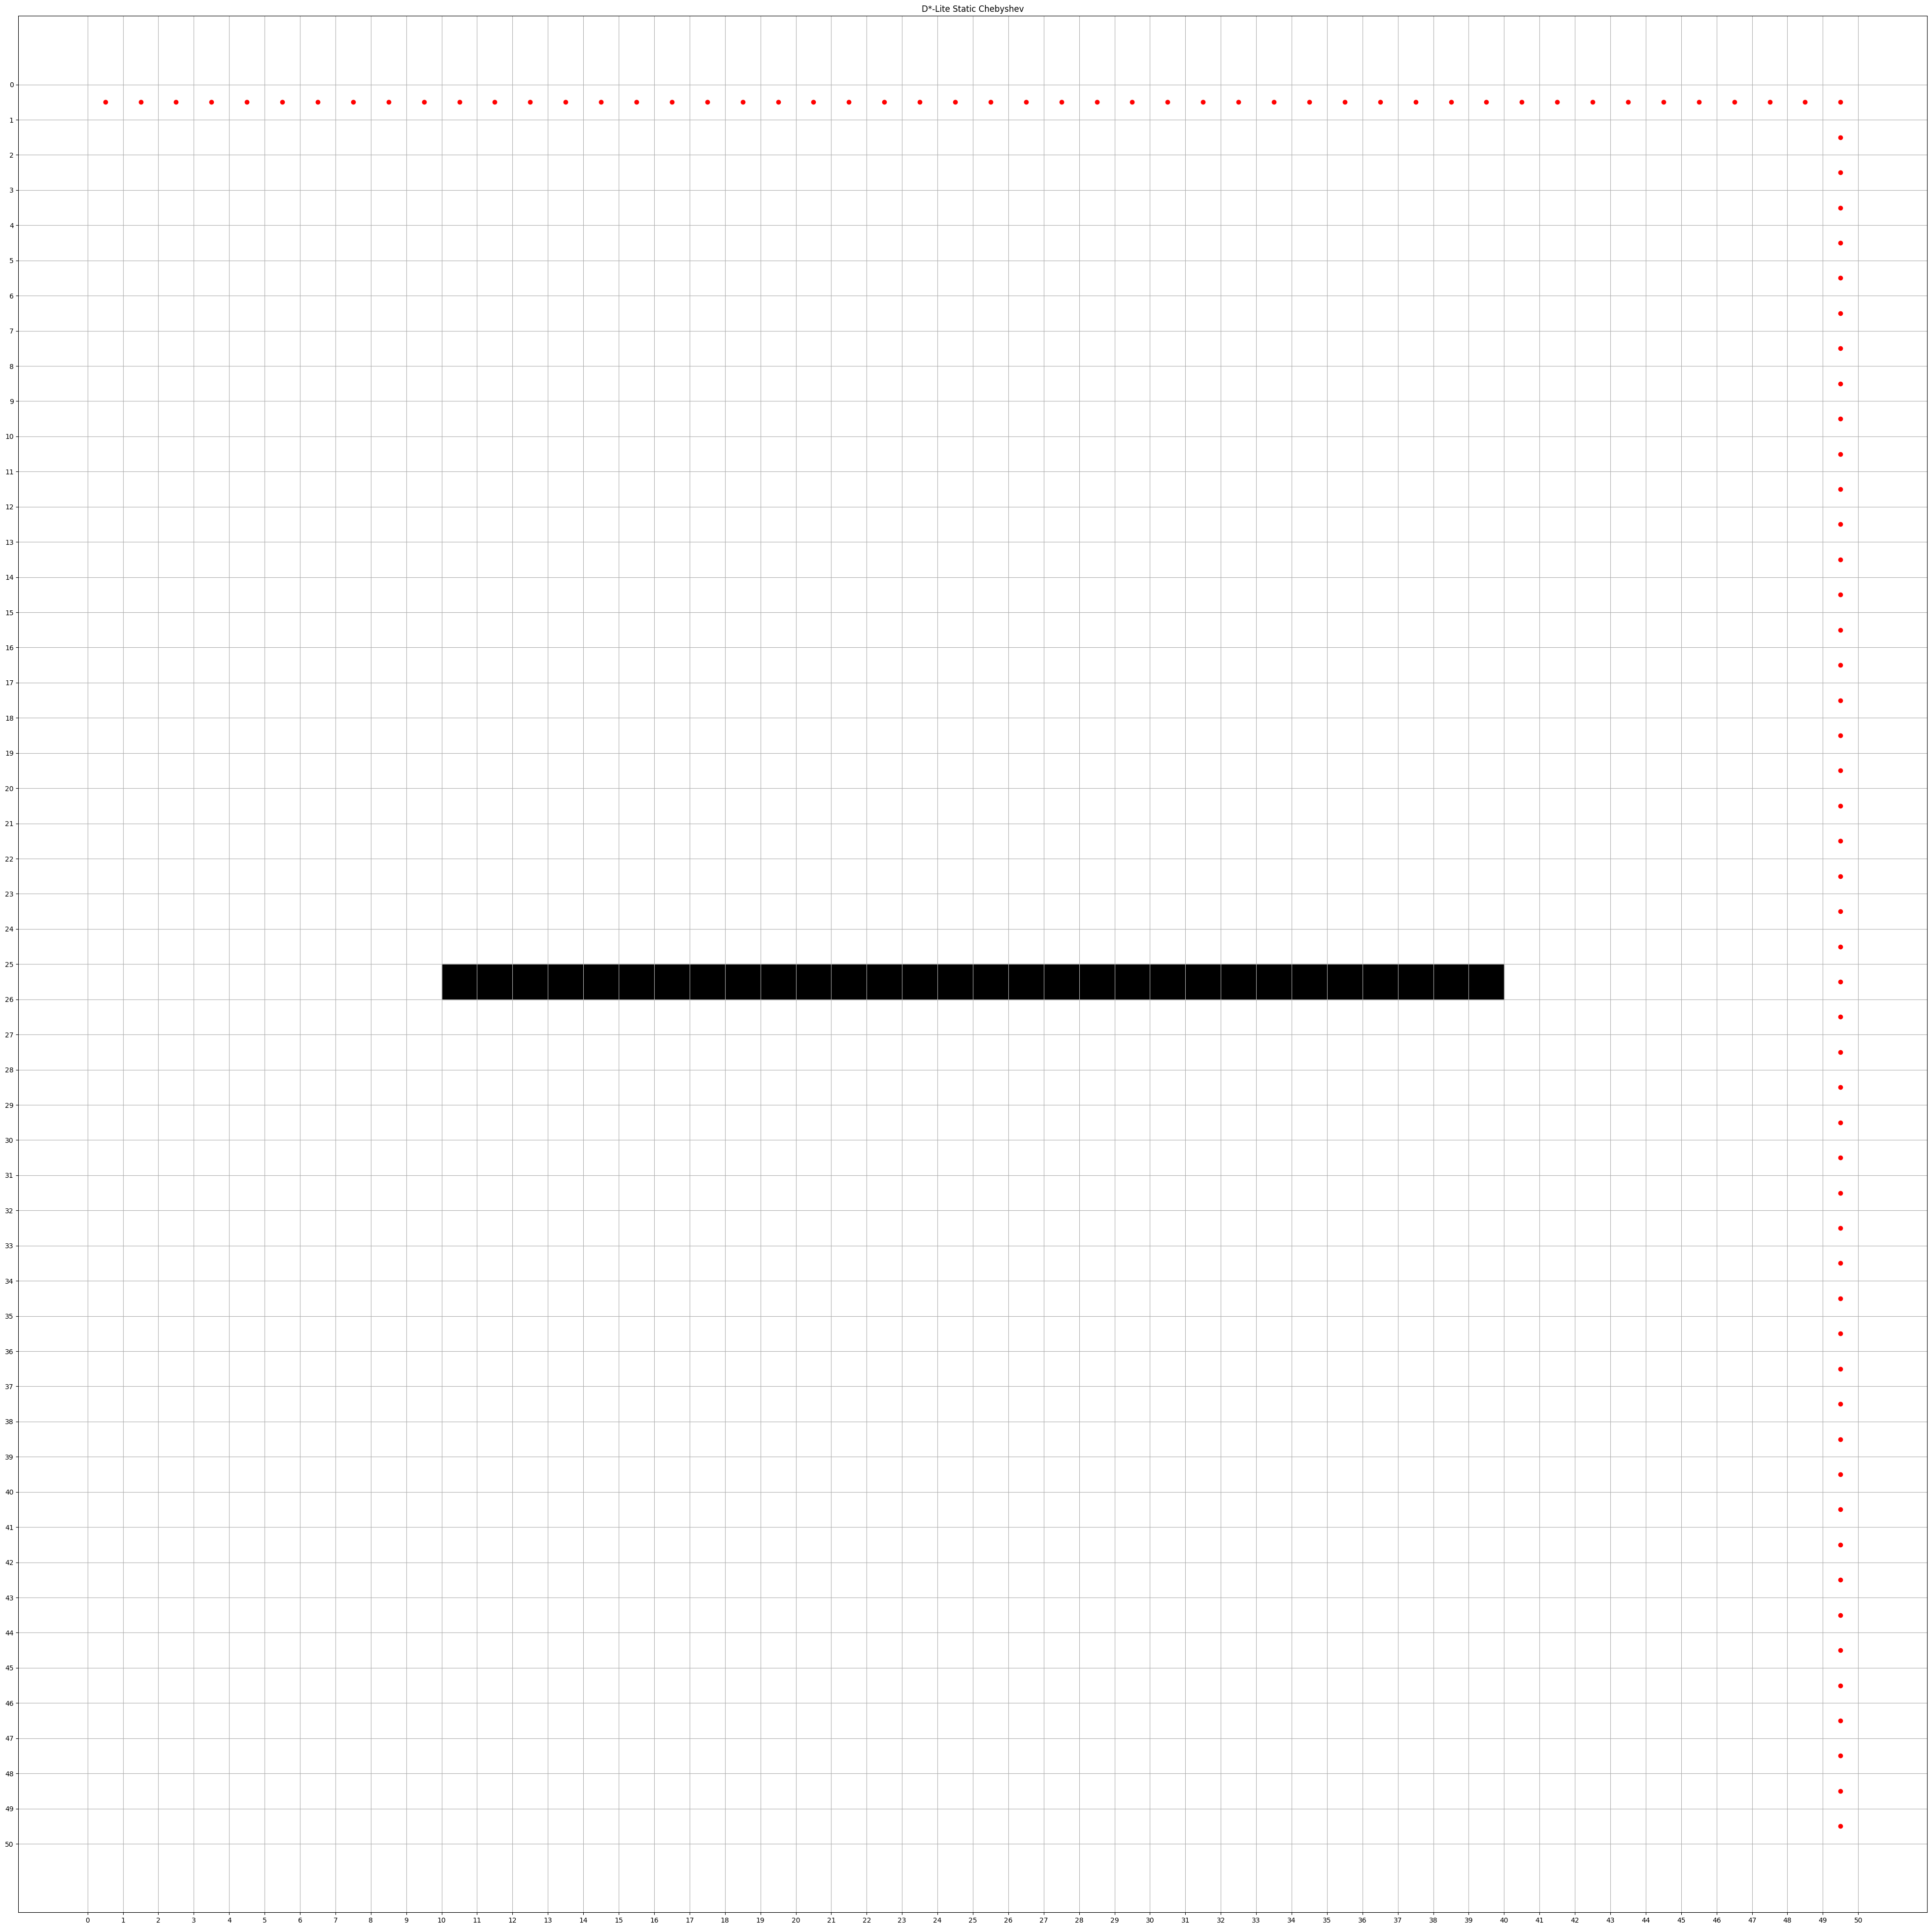

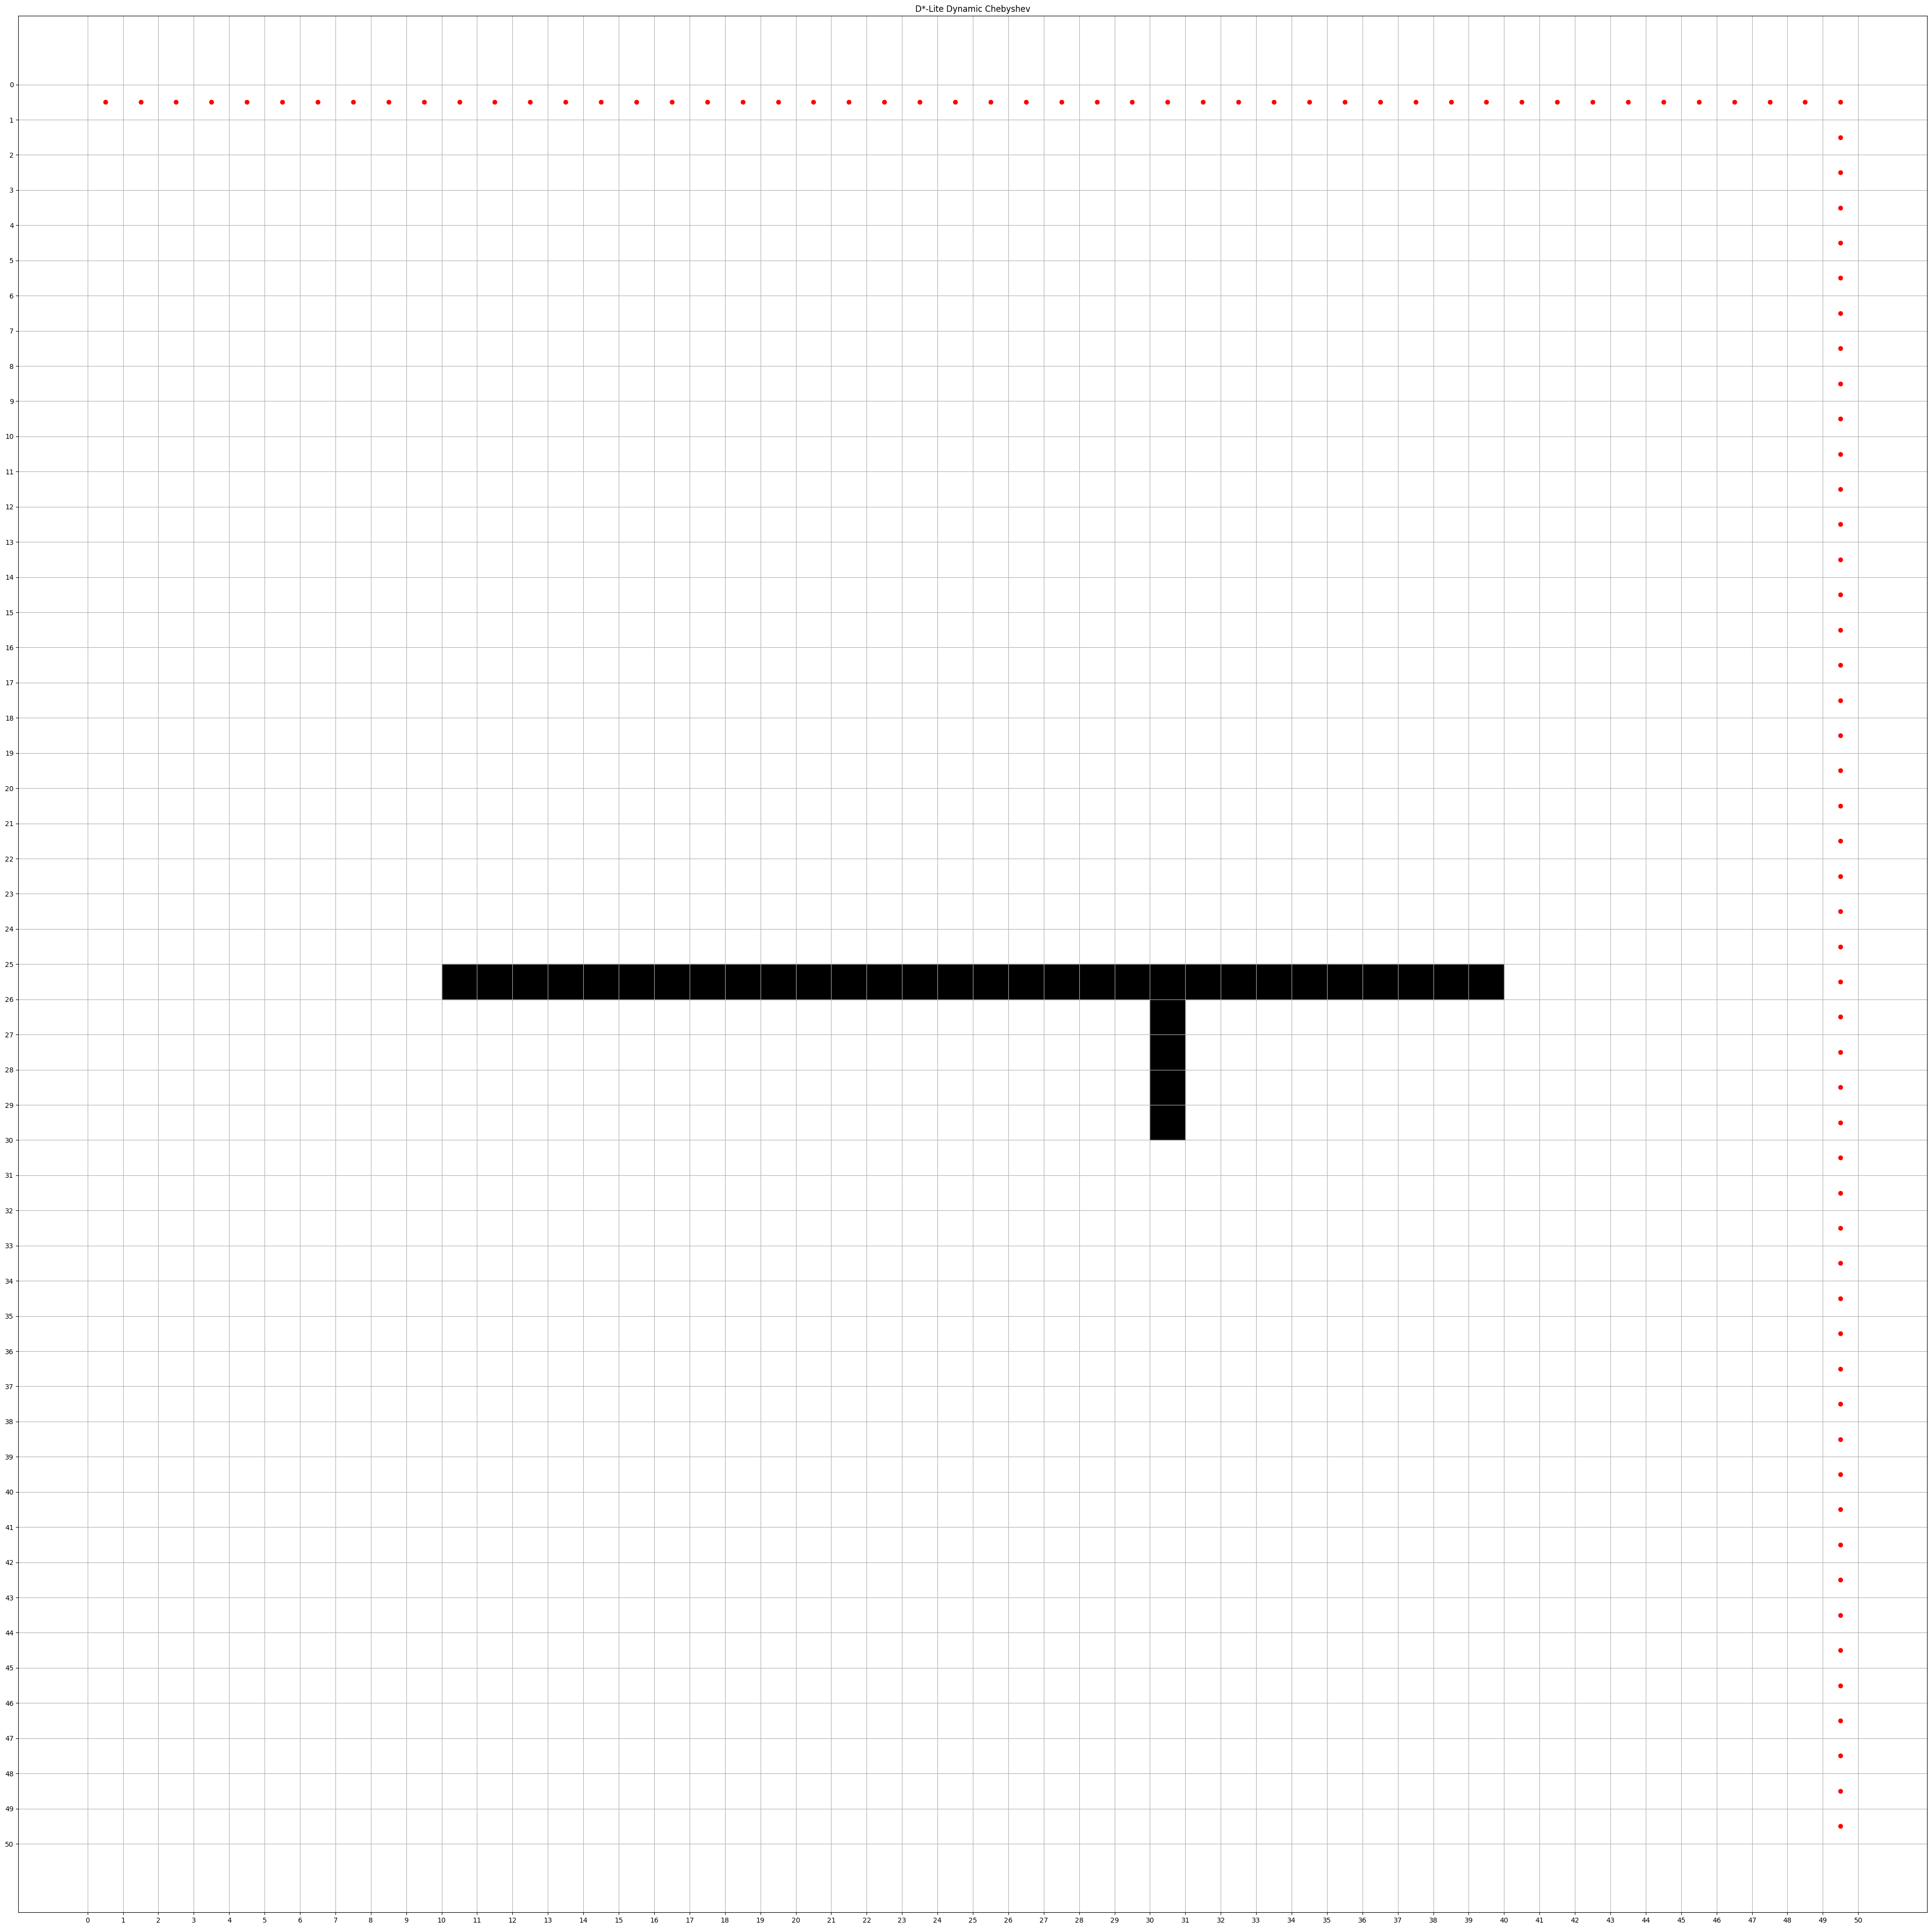


--- Summary Table (Averages over 10 runs) ---
Algorithm                      Length     Time (s)  
A* (Static, Manhattan)         99         0.022448
A* (Dynamic, Manhattan)        99         0.020953
D*-Lite (Static, Manhattan)    99         0.157989
D*-Lite (Dynamic, Manhattan)   99         0.085253
A* (Static, Euclidean)         99         0.038832
A* (Dynamic, Euclidean)        99         0.031253
D*-Lite (Static, Euclidean)    99         0.145103
D*-Lite (Dynamic, Euclidean)   99         0.128368
A* (Static, Chebyshev)         99         0.021222
A* (Dynamic, Chebyshev)        99         0.023781
D*-Lite (Static, Chebyshev)    99         0.137029
D*-Lite (Dynamic, Chebyshev)   99         0.105456


In [ ]:
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __lt__(self, other):
        return self.path_cost < other.path_cost

    def path(self):
        node, path_back = self, []
        while node:
            path_back.append(node.state)
            node = node.parent
        return list(reversed(path_back))

# -----------------------------
# Grid Problem for Static and Dynamic Pathfinding (AIMA)
# -----------------------------
class GridProblem:
    def __init__(self, grid, initial, goal):
        self.grid = grid
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        x, y = state
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.grid.shape[1] and 0 <= ny < self.grid.shape[0] and self.grid[ny][nx] >= 0:
                yield (nx, ny)

    def result(self, state, action):
        return action

    def goal_test(self, state):
        return state == self.goal

# -----------------------------
# A* Search (based on AIMA best-first graph search and PythonRobotics)
# -----------------------------
def astar_search(problem, h, dynamic_blocks=None):
    node = Node(problem.initial)
    frontier = [(h(node.state), node)]
    reached = {node.state: node}

    while frontier:
        _, current = heapq.heappop(frontier)
        if problem.goal_test(current.state):
            return current.path()
        if dynamic_blocks and current.state in dynamic_blocks:
            continue
        for action in problem.actions(current.state):
            if dynamic_blocks and action in dynamic_blocks:
                continue
            child_state = problem.result(current.state, action)
            cost = current.path_cost + 1
            if child_state not in reached or cost < reached[child_state].path_cost:
                child_node = Node(child_state, current, action, cost)
                reached[child_state] = child_node
                heapq.heappush(frontier, (child_node.path_cost + h(child_state), child_node))
    return []

# -----------------------------
# D*-Lite Implementation (based on Koenig & Likhachev and mdeyo)
# -----------------------------
class GraphNode:
    def __init__(self):
        self.g = float('inf')
        self.rhs = float('inf')
        self.children = {}
        self.parents = {}

class DStarLiteGraph:
    def __init__(self, grid, start, goal):
        self.cells = grid
        self.goal = goal
        self.start = start
        self.graph = defaultdict(GraphNode)
        for y in range(grid.shape[0]):
            for x in range(grid.shape[1]):
                if grid[y][x] >= 0:
                    self._link_neighbors((x, y))

    def _link_neighbors(self, state):
        x, y = state
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            neighbor = (nx, ny)
            if 0 <= nx < self.cells.shape[1] and 0 <= ny < self.cells.shape[0] and self.cells[ny][nx] >= 0:
                self.graph[state].children[neighbor] = 1
                self.graph[neighbor].parents[state] = 1

def manhattan(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def euclidean(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

#https://medium.com/@cheedellavamsikishore/robotic-path-planning-a-star-96a2c8f9467d
def chebyshev(a, b):
    return max(abs(a[0] - b[0]), abs(a[1] - b[1]))

def calculate_key(graph, state, s_start, k_m, heuristic):
    node = graph.graph[state]
    return (min(node.g, node.rhs) + heuristic(state, s_start) + k_m, min(node.g, node.rhs))

def update_vertex(graph, queue, state, s_start, k_m, heuristic):
    node = graph.graph[state]
    if state != graph.goal and node.children:
        node.rhs = min([graph.graph[s].g + cost for s, cost in node.children.items()])
    for i in range(len(queue)):
        if queue[i][2] == state:
            queue.pop(i)
            break
    if node.g != node.rhs:
        heapq.heappush(queue, calculate_key(graph, state, s_start, k_m, heuristic) + (state,))

def compute_shortest_path(graph, queue, s_start, k_m, heuristic):
    while queue and (graph.graph[s_start].rhs != graph.graph[s_start].g or queue[0][:2] < calculate_key(graph, s_start, s_start, k_m, heuristic)):
        k_old = queue[0][:2]
        u = heapq.heappop(queue)[2]
        node_u = graph.graph[u]
        if k_old < calculate_key(graph, u, s_start, k_m, heuristic):
            heapq.heappush(queue, calculate_key(graph, u, s_start, k_m, heuristic) + (u,))
        elif node_u.g > node_u.rhs:
            node_u.g = node_u.rhs
            for s in node_u.parents:
                update_vertex(graph, queue, s, s_start, k_m, heuristic)
        else:
            node_u.g = float('inf')
            update_vertex(graph, queue, u, s_start, k_m, heuristic)
            for s in node_u.parents:
                update_vertex(graph, queue, s, s_start, k_m, heuristic)

def d_star_lite(grid, start, goal, heuristic):
    graph = DStarLiteGraph(grid, start, goal)
    graph.graph[goal].rhs = 0
    queue = []
    k_m = 0
    heapq.heappush(queue, calculate_key(graph, goal, start, k_m, heuristic) + (goal,))
    compute_shortest_path(graph, queue, start, k_m, heuristic)

    path = [start]
    current = start
    while current != goal:
        next_states = list(graph.graph[current].children)
        if not next_states:
            break
        current = min(next_states, key=lambda s: graph.graph[s].g + graph.graph[current].children[s])
        path.append(current)
    return path

# -----------------------------
# Visualization and Main
# -----------------------------
def draw_grid(grid, path, title):
    plt.figure(figsize=(grid.shape[1], grid.shape[0]))
    for y in range(grid.shape[0]):
        for x in range(grid.shape[1]):
            if grid[y][x] == -1:
                plt.fill_between([x, x+1], y, y+1, color='black')
    for (x, y) in path:
        plt.plot(x + 0.5, y + 0.5, 'ro')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid(True, which='both')
    plt.xticks(np.arange(0, grid.shape[1]+1, 1))
    plt.yticks(np.arange(0, grid.shape[0]+1, 1))
    plt.show()

def run_experiment(rows, cols, obstacles, dynamic_blocks, start, goal, num_runs=10):
    grid = np.zeros((rows, cols), dtype=int)
    for (x, y) in obstacles:
        grid[y][x] = -1
    grid_dyn = grid.copy()
    for (x, y) in dynamic_blocks:
        grid_dyn[y][x] = -1

    print(f"\n--- {rows}x{cols} Grid ---")

    # Initialize time accumulators for each algorithm
    time_accumulators = {
        'astar_static_manhattan': 0,
        'astar_dynamic_manhattan': 0,
        'dstar_static_manhattan': 0,
        'dstar_dynamic_manhattan': 0,
        'astar_static_euclidean': 0,
        'astar_dynamic_euclidean': 0,
        'dstar_static_euclidean': 0,
        'dstar_dynamic_euclidean': 0,
        'astar_static_chebyshev': 0,
        'astar_dynamic_chebyshev': 0,
        'dstar_static_chebyshev': 0,
        'dstar_dynamic_chebyshev': 0,
    }

    # Store the final paths (from last run)
    final_paths = {}

    # Run each algorithm num_runs times
    for run in range(num_runs):
        print(f"\nRun {run + 1}/{num_runs}")

        # Run with Manhattan heuristic
        static_problem = GridProblem(grid, start, goal)
        t1 = time.time()
        path_astar_static_manhattan = astar_search(static_problem, lambda s: manhattan(s, goal))
        t2 = time.time()
        time_accumulators['astar_static_manhattan'] += t2 - t1
        if run == num_runs - 1:
            final_paths['astar_static_manhattan'] = path_astar_static_manhattan
            draw_grid(grid, path_astar_static_manhattan, "A* Static Manhattan")

        dynamic_problem = GridProblem(grid_dyn, start, goal)
        t3 = time.time()
        path_astar_dynamic_manhattan = astar_search(dynamic_problem, lambda s: manhattan(s, goal), dynamic_blocks)
        t4 = time.time()
        time_accumulators['astar_dynamic_manhattan'] += t4 - t3
        if run == num_runs - 1:
            final_paths['astar_dynamic_manhattan'] = path_astar_dynamic_manhattan
            draw_grid(grid_dyn, path_astar_dynamic_manhattan, "A* Dynamic Manhattan")

        t5 = time.time()
        path_dstar_static_manhattan = d_star_lite(grid, start, goal, manhattan)
        t6 = time.time()
        time_accumulators['dstar_static_manhattan'] += t6 - t5
        if run == num_runs - 1:
            final_paths['dstar_static_manhattan'] = path_dstar_static_manhattan
            draw_grid(grid, path_dstar_static_manhattan, "D*-Lite Static Manhattan")

        t7 = time.time()
        path_dstar_dynamic_manhattan = d_star_lite(grid_dyn, start, goal, manhattan)
        t8 = time.time()
        time_accumulators['dstar_dynamic_manhattan'] += t8 - t7
        if run == num_runs - 1:
            final_paths['dstar_dynamic_manhattan'] = path_dstar_dynamic_manhattan
            draw_grid(grid_dyn, path_dstar_dynamic_manhattan, "D*-Lite Dynamic Manhattan")

        # Run with Euclidean heuristic
        static_problem = GridProblem(grid, start, goal)
        t9 = time.time()
        path_astar_static_euclidean = astar_search(static_problem, lambda s: euclidean(s, goal))
        t10 = time.time()
        time_accumulators['astar_static_euclidean'] += t10 - t9
        if run == num_runs - 1:
            final_paths['astar_static_euclidean'] = path_astar_static_euclidean
            draw_grid(grid, path_astar_static_euclidean, "A* Static Euclidean")

        dynamic_problem = GridProblem(grid_dyn, start, goal)
        t11 = time.time()
        path_astar_dynamic_euclidean = astar_search(dynamic_problem, lambda s: euclidean(s, goal), dynamic_blocks)
        t12 = time.time()
        time_accumulators['astar_dynamic_euclidean'] += t12 - t11
        if run == num_runs - 1:
            final_paths['astar_dynamic_euclidean'] = path_astar_dynamic_euclidean
            draw_grid(grid_dyn, path_astar_dynamic_euclidean, "A* Dynamic Euclidean")

        t13 = time.time()
        path_dstar_static_euclidean = d_star_lite(grid, start, goal, euclidean)
        t14 = time.time()
        time_accumulators['dstar_static_euclidean'] += t14 - t13
        if run == num_runs - 1:
            final_paths['dstar_static_euclidean'] = path_dstar_static_euclidean
            draw_grid(grid, path_dstar_static_euclidean, "D*-Lite Static Euclidean")

        t15 = time.time()
        path_dstar_dynamic_euclidean = d_star_lite(grid_dyn, start, goal, euclidean)
        t16 = time.time()
        time_accumulators['dstar_dynamic_euclidean'] += t16 - t15
        if run == num_runs - 1:
            final_paths['dstar_dynamic_euclidean'] = path_dstar_dynamic_euclidean
            draw_grid(grid_dyn, path_dstar_dynamic_euclidean, "D*-Lite Dynamic Euclidean")

        # Run with Chebyshev heuristic
        static_problem = GridProblem(grid, start, goal)
        t17 = time.time()
        path_astar_static_chebyshev = astar_search(static_problem, lambda s: chebyshev(s, goal))
        t18 = time.time()
        time_accumulators['astar_static_chebyshev'] += t18 - t17
        if run == num_runs - 1:
            final_paths['astar_static_chebyshev'] = path_astar_static_chebyshev
            draw_grid(grid, path_astar_static_chebyshev, "A* Static Chebyshev")

        dynamic_problem = GridProblem(grid_dyn, start, goal)
        t19 = time.time()
        path_astar_dynamic_chebyshev = astar_search(dynamic_problem, lambda s: chebyshev(s, goal), dynamic_blocks)
        t20 = time.time()
        time_accumulators['astar_dynamic_chebyshev'] += t20 - t19
        if run == num_runs - 1:
            final_paths['astar_dynamic_chebyshev'] = path_astar_dynamic_chebyshev
            draw_grid(grid_dyn, path_astar_dynamic_chebyshev, "A* Dynamic Chebyshev")

        t21 = time.time()
        path_dstar_static_chebyshev = d_star_lite(grid, start, goal, chebyshev)
        t22 = time.time()
        time_accumulators['dstar_static_chebyshev'] += t22 - t21
        if run == num_runs - 1:
            final_paths['dstar_static_chebyshev'] = path_dstar_static_chebyshev
            draw_grid(grid, path_dstar_static_chebyshev, "D*-Lite Static Chebyshev")

        t23 = time.time()
        path_dstar_dynamic_chebyshev = d_star_lite(grid_dyn, start, goal, chebyshev)
        t24 = time.time()
        time_accumulators['dstar_dynamic_chebyshev'] += t24 - t23
        if run == num_runs - 1:
            final_paths['dstar_dynamic_chebyshev'] = path_dstar_dynamic_chebyshev
            draw_grid(grid_dyn, path_dstar_dynamic_chebyshev, "D*-Lite Dynamic Chebyshev")

    print("\n--- Summary Table (Averages over {} runs) ---".format(num_runs))
    print("{:<30} {:<10} {:<10}".format("Algorithm", "Length", "Time (s)"))
    print("{:<30} {:<10} {:.6f}".format(
        "A* (Static, Manhattan)",
        len(final_paths['astar_static_manhattan']),
        time_accumulators['astar_static_manhattan']/num_runs
    ))
    print("{:<30} {:<10} {:.6f}".format(
        "A* (Dynamic, Manhattan)",
        len(final_paths['astar_dynamic_manhattan']),
        time_accumulators['astar_dynamic_manhattan']/num_runs
    ))
    print("{:<30} {:<10} {:.6f}".format(
        "D*-Lite (Static, Manhattan)",
        len(final_paths['dstar_static_manhattan']),
        time_accumulators['dstar_static_manhattan']/num_runs
    ))
    print("{:<30} {:<10} {:.6f}".format(
        "D*-Lite (Dynamic, Manhattan)",
        len(final_paths['dstar_dynamic_manhattan']),
        time_accumulators['dstar_dynamic_manhattan']/num_runs
    ))
    print("{:<30} {:<10} {:.6f}".format(
        "A* (Static, Euclidean)",
        len(final_paths['astar_static_euclidean']),
        time_accumulators['astar_static_euclidean']/num_runs
    ))
    print("{:<30} {:<10} {:.6f}".format(
        "A* (Dynamic, Euclidean)",
        len(final_paths['astar_dynamic_euclidean']),
        time_accumulators['astar_dynamic_euclidean']/num_runs
    ))
    print("{:<30} {:<10} {:.6f}".format(
        "D*-Lite (Static, Euclidean)",
        len(final_paths['dstar_static_euclidean']),
        time_accumulators['dstar_static_euclidean']/num_runs
    ))
    print("{:<30} {:<10} {:.6f}".format(
        "D*-Lite (Dynamic, Euclidean)",
        len(final_paths['dstar_dynamic_euclidean']),
        time_accumulators['dstar_dynamic_euclidean']/num_runs
    ))
    print("{:<30} {:<10} {:.6f}".format(
        "A* (Static, Chebyshev)",
        len(final_paths['astar_static_chebyshev']),
        time_accumulators['astar_static_chebyshev']/num_runs
    ))
    print("{:<30} {:<10} {:.6f}".format(
        "A* (Dynamic, Chebyshev)",
        len(final_paths['astar_dynamic_chebyshev']),
        time_accumulators['astar_dynamic_chebyshev']/num_runs
    ))
    print("{:<30} {:<10} {:.6f}".format(
        "D*-Lite (Static, Chebyshev)",
        len(final_paths['dstar_static_chebyshev']),
        time_accumulators['dstar_static_chebyshev']/num_runs
    ))
    print("{:<30} {:<10} {:.6f}".format(
        "D*-Lite (Dynamic, Chebyshev)",
        len(final_paths['dstar_dynamic_chebyshev']),
        time_accumulators['dstar_dynamic_chebyshev']/num_runs
    ))


def main():
    run_experiment(
        rows=10,
        cols=10,
        obstacles=[(1, 1), (2, 2), (3, 3), (4, 4), (6, 0), (6, 1), (6, 2), (2, 5), (3, 5), (4, 5), (5, 5), (7, 7), (8, 8)],
        dynamic_blocks={(5, 6), (5, 7), (5, 8)},
        start=(0, 0),
        goal=(9, 9),
        num_runs=10  # Run each algorithm 10 times
    )

    run_experiment(
        rows=50,
        cols=50,
        obstacles=[(i, 25) for i in range(10, 40)],
        dynamic_blocks={(30, 26), (30, 27), (30, 28), (30, 29)},
        start=(0, 0),
        goal=(49, 49),
        num_runs=10  # Run each algorithm 10 times
    )

if __name__ == '__main__':
    main()
